In [1]:
from sklearn import metrics
import random
import tensorflow
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import random
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from numpy import mean
from numpy import std
from sklearn.metrics import precision_score
import statsmodels.api as sm
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import ParameterGrid
from xgboost import XGBClassifier
from xgboost import plot_tree
import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
from keras.optimizers import SGD
import statistics
import itertools
from itertools import product
from mpl_toolkits.mplot3d import Axes3D
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import BaggingClassifier
import warnings
warnings.filterwarnings('ignore')
import re
import operator as op
from sklearn.metrics import confusion_matrix
import pandas as pd
import scipy.stats as stats


C:\Users\shezo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\shezo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Importing CRSP crash data 
df1 = pd.read_csv("C:/Users/shezo/OneDrive/My Documents/MDS/Dissertation/Data/crash.csv")
df1.head()

,gvkey,fyear,SIC,BIG4,MODIFIED,VALUE,ASSETS,ASSET_GROWTH,LIAB_GROWTH,SALES_GROWTH,...,AGE,LIT,Z_SCORE,NETFILESIZE,WORDS,NEGATIVE,POSITIVE,UNCERTAIN,LITIGOUS,CRASH
0,10884,1993,100,1,0,6.324117,7.915988,-0.048556,-0.030367,-0.069889,...,63,0,1.341682,450656,60503,563,226,405,1883,0
1,10390,1994,100,1,1,5.025090,3.804883,-0.042524,-0.235625,-0.082085,...,44,0,13.269255,190514,20653,244,108,180,457,0
2,8596,1994,100,1,1,7.898852,7.133631,0.026246,-0.063346,0.100678,...,24,0,7.983232,91626,10501,88,133,104,63,0
3,2812,1994,100,0,0,7.221101,8.255486,0.136002,0.220105,0.119820,...,48,0,1.861746,415553,51758,584,321,520,1466,0
4,14881,1994,100,1,1,5.130932,5.765191,0.008217,-0.024667,0.097770,...,9,0,2.181140,362277,48629,659,430,281,1499,0


In [3]:
# Importing firm-level regulation data 
df2 = pd.read_stata('firmreg.dta')
df21 = df2[['gvkey', 'year', 'RegIn_Regulations']]
df21['year'] = df21['year'].astype(int)
df21.rename(columns ={'year':'fyear', 'RegIn_Regulations':'firmreg'}, inplace = True)

df21.head()

,gvkey,fyear,firmreg
0,1004,1993,90.173180
1,1009,1993,89.530067
2,1010,1993,91.638931
3,1011,1993,84.989334
4,1013,1993,88.758217


In [4]:
# Join firm-level regulation data using GVKEY and FYEAR match 
df = df21.merge(df1, how = 'inner', on = ['gvkey', 'fyear'])
df.head()

,gvkey,fyear,firmreg,SIC,BIG4,MODIFIED,VALUE,ASSETS,ASSET_GROWTH,LIAB_GROWTH,...,AGE,LIT,Z_SCORE,NETFILESIZE,WORDS,NEGATIVE,POSITIVE,UNCERTAIN,LITIGOUS,CRASH
0,1013,1993,88.758217,3661,0,0,6.918636,5.634983,0.163198,0.018541,...,31,1,13.407786,697262,90057,1598,610,553,2928,0
1,1045,1993,91.864807,4512,1,1,8.532791,9.869206,0.033144,-0.019991,...,67,0,1.083562,167342,17551,218,121,149,211,0
2,1075,1993,90.021400,4911,0,0,7.578714,8.847474,0.077518,0.073297,...,55,0,0.729895,168876,17293,294,81,202,321,1
3,1078,1993,96.334862,2834,0,1,10.099300,8.947490,0.107666,0.116887,...,67,1,6.238942,306808,39141,411,226,274,1338,1
4,1161,1993,88.758224,3674,1,1,7.402988,7.564877,0.332254,0.437530,...,45,1,3.929570,793777,104478,1924,513,874,3852,0


In [5]:
#Including Dodd-Frank proxy 
df['dodd'] = 1
df.loc[df['fyear'] <= 2010, "dodd"] = 0

In [6]:
#Adding Yearly Banking Regulation Index from "regulatory intensity (year-ff48)"
df['bankreg'] = 88.11152
df.loc[df['fyear'] == 1994, 'bankreg'] = 93.39980
df.loc[df['fyear'] == 1995, 'bankreg'] = 94.81907
df.loc[df['fyear'] == 1996, 'bankreg'] = 96.59152
df.loc[df['fyear'] == 1997, 'bankreg'] = 95.47455
df.loc[df['fyear'] == 1998, 'bankreg'] = 92.86000
df.loc[df['fyear'] == 1999, 'bankreg'] = 95.07188
df.loc[df['fyear'] == 2000, 'bankreg'] = 101.53664
df.loc[df['fyear'] == 2001, 'bankreg'] = 99.70758
df.loc[df['fyear'] == 2002, 'bankreg'] = 99.26804
df.loc[df['fyear'] == 2003, 'bankreg'] = 100.55630
df.loc[df['fyear'] == 2004, 'bankreg'] = 100.78033
df.loc[df['fyear'] == 2005, 'bankreg'] = 98.83892
df.loc[df['fyear'] == 2006, 'bankreg'] = 100.17723
df.loc[df['fyear'] == 2007, 'bankreg'] = 101.01414
df.loc[df['fyear'] == 2008, 'bankreg'] = 101.13760
df.loc[df['fyear'] == 2009, 'bankreg'] = 103.72409 
df.loc[df['fyear'] == 2010, 'bankreg'] = 107.13873
df.loc[df['fyear'] == 2011, 'bankreg'] = 107.69250
df.loc[df['fyear'] == 2012, 'bankreg'] = 109.85559
df.loc[df['fyear'] == 2013, 'bankreg'] = 107.62720
df.loc[df['fyear'] == 2014, 'bankreg'] = 106.49673
df.loc[df['fyear'] == 2015, 'bankreg'] = 107.46543
df.loc[df['fyear'] == 2016, 'bankreg'] = 107.64746

In [7]:
# Renamed columns 
df.rename(columns ={'fyear':'FYEAR', 'gvkey':'GVKEY', 'bankreg':'BANKREG', 'firmreg':'FIRMREG', 'dodd':'DODD'}, inplace = True)


In [8]:
#Setting Dependent variable (Y) and explanatory varaible (X)

X = df.loc[:, df.columns != 'CRASH']
y = df['CRASH']

## Data Cleansing

In [9]:
#Check for any duplicate rows 
df.duplicated().sum()

0

In [10]:
#Check for any missing values 
df.isna().sum()

GVKEY           0
FYEAR           0
FIRMREG         0
SIC             0
BIG4            0
MODIFIED        0
VALUE           0
ASSETS          0
ASSET_GROWTH    0
LIAB_GROWTH     0
SALES_GROWTH    0
MTB             0
ROA             0
LTM             0
AGE             0
LIT             0
Z_SCORE         0
NETFILESIZE     0
WORDS           0
NEGATIVE        0
POSITIVE        0
UNCERTAIN       0
LITIGOUS        0
CRASH           0
DODD            0
BANKREG         0
dtype: int64

### Class Imbalance 

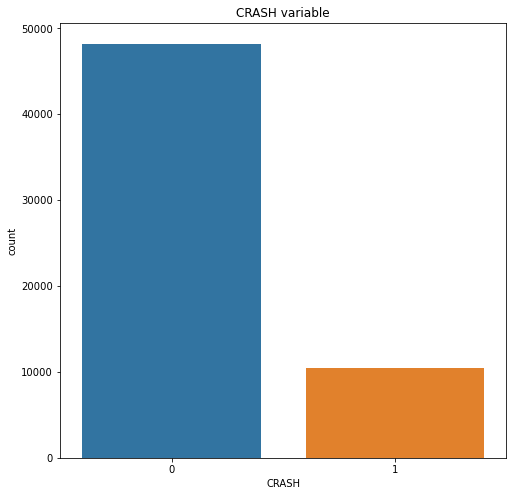

In [11]:
#Class size OG
plt.figure(figsize=(8, 8))
sns.countplot('CRASH', data=df)
plt.title('CRASH variable')
plt.show()

(-1.1041604857926717,
 1.106035687477261,
 -1.1058333465761097,
 1.1002778152534252)

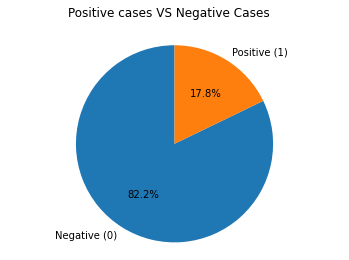

In [12]:
#Class Size (OG)
labels = 'Negative (0)', 'Positive (1)'
sizes = df['CRASH'].value_counts()
fig1, ax1 = plt.subplots()
fig1.suptitle('Positive cases VS Negative Cases')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1.axis('equal')

### Under and Oversampling

In [13]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek(random_state=42)
X, y = smt.fit_resample(X, y)

In [14]:
y.value_counts()

0    46195
1    46195
Name: CRASH, dtype: int64

In [15]:
# Join the new observations into a single dataframe 
temp = X.join(y)

### Class Balance 

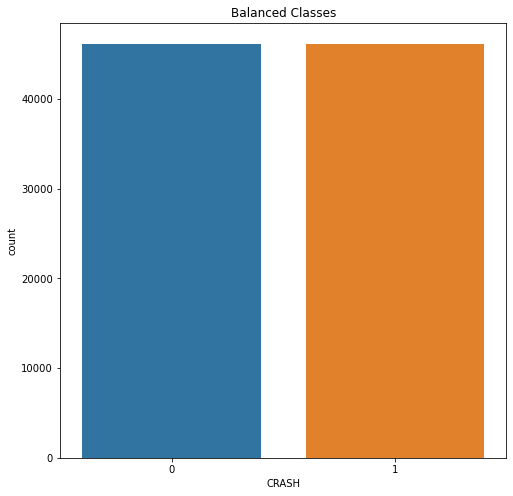

In [19]:
#Class size (after SMOTEEN)
plt.figure(figsize=(8, 8))
sns.countplot(y)
plt.title('Balanced Classes')
plt.show()

(-1.1, 1.1, -1.1, 1.1)

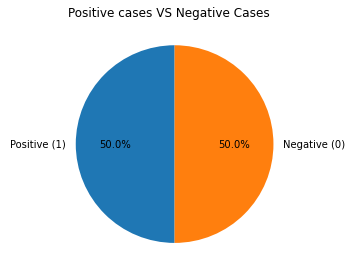

In [20]:
#Class Size (After resampling)
labels = 'Positive (1)', 'Negative (0)'
sizes = y.value_counts()
fig3, ax3 = plt.subplots()
fig3.suptitle('Positive cases VS Negative Cases')
ax3.pie(sizes, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax3.axis('equal')

# EDA 

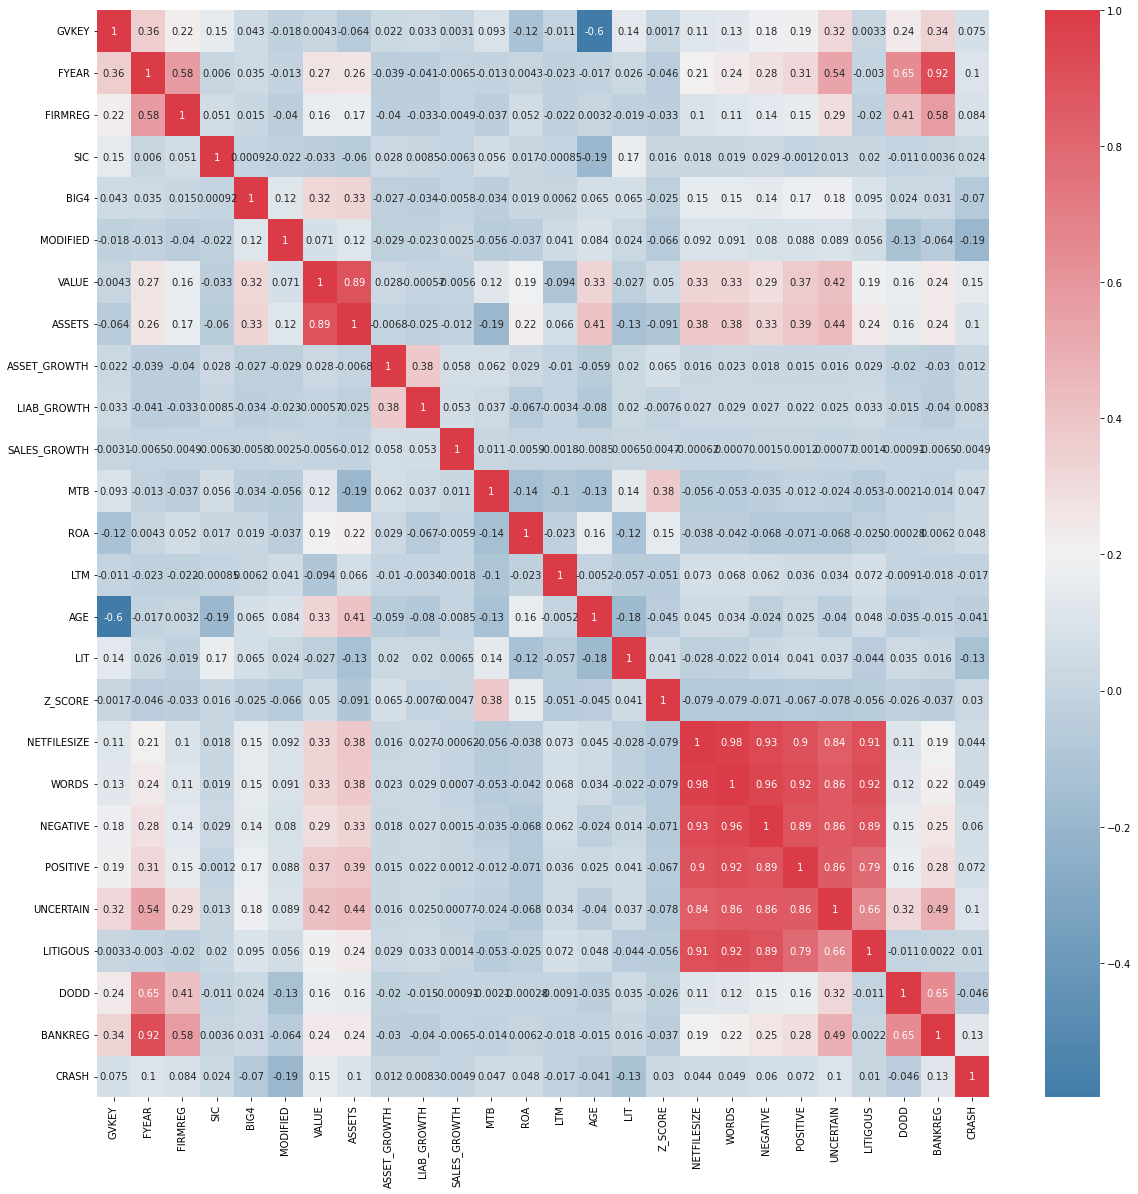

In [21]:
#Correlation Matrix (pre-FS)
plt.figure(figsize=(20,20))
corr = temp.corr()
sns.heatmap(corr, annot = True, cmap = sns.diverging_palette(240, 10, as_cmap=True))
plt.show()

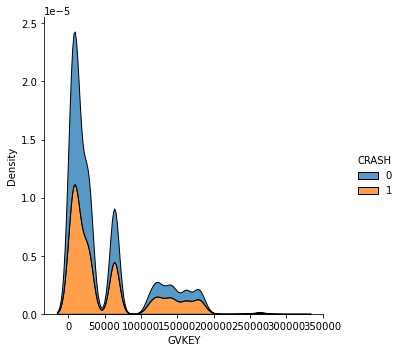

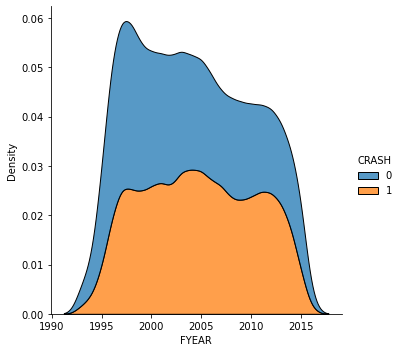

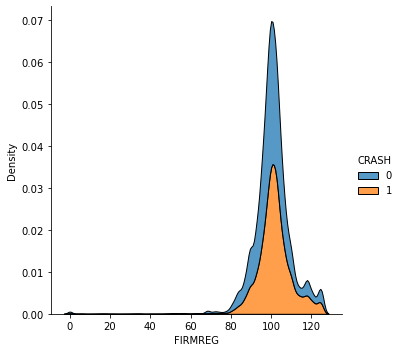

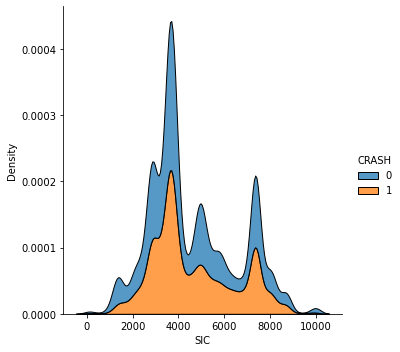

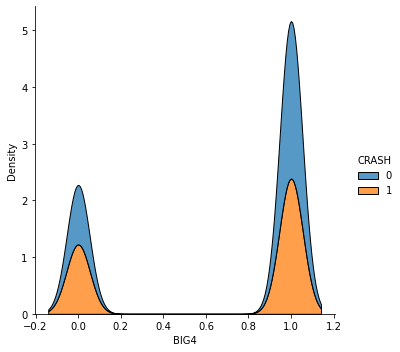

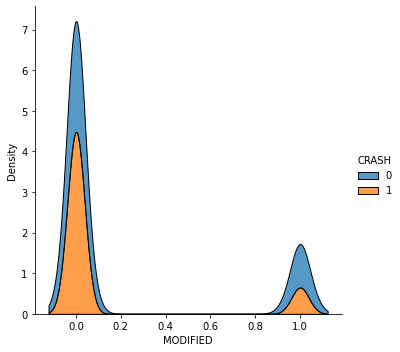

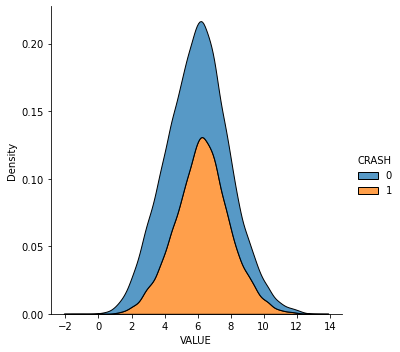

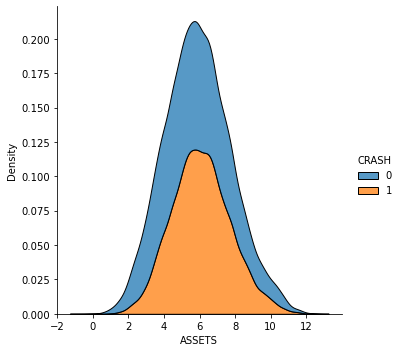

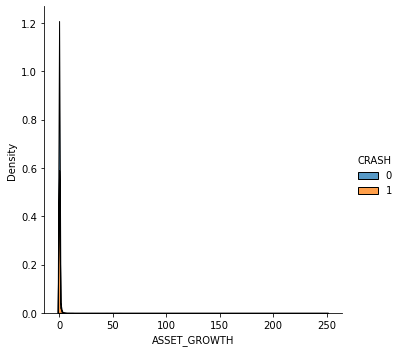

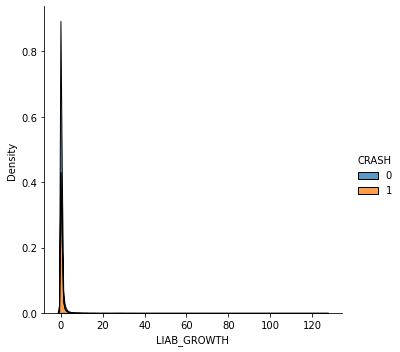

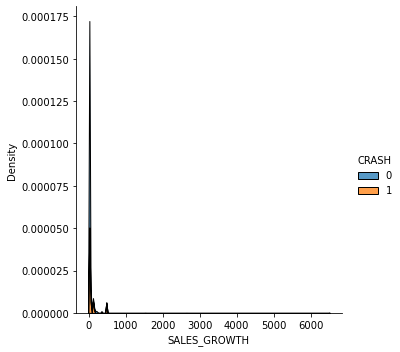

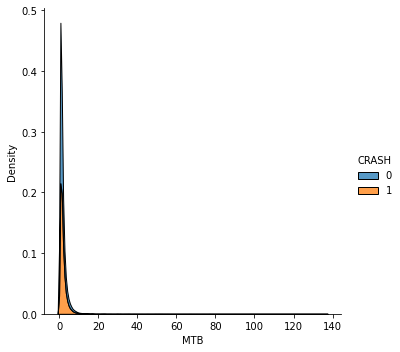

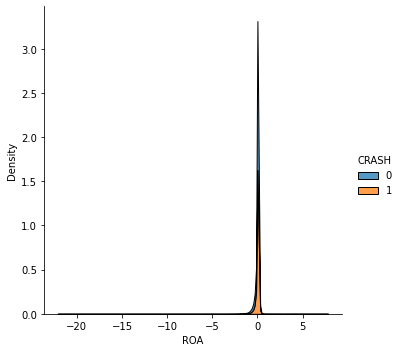

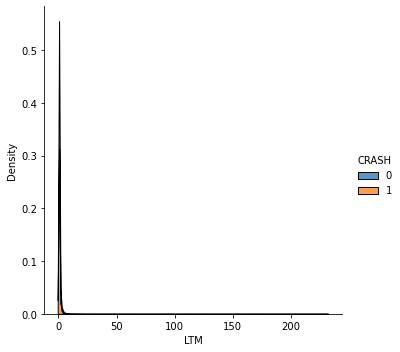

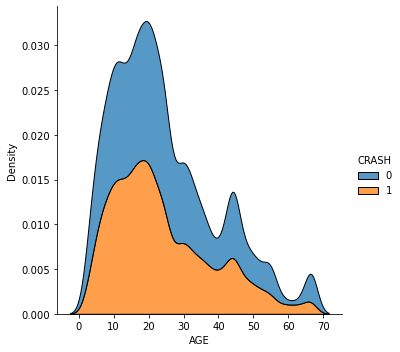

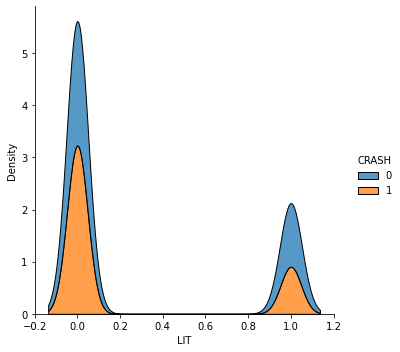

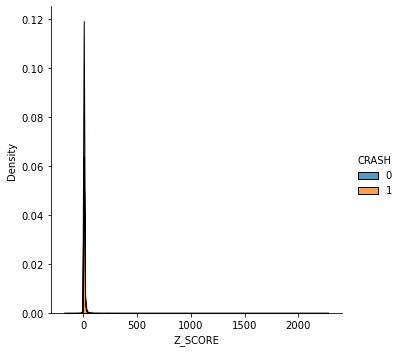

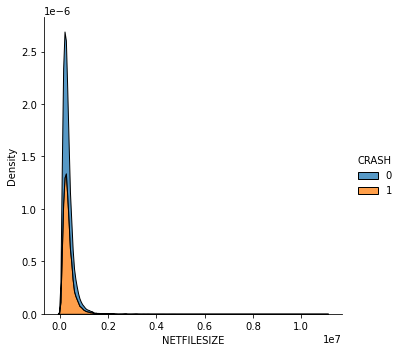

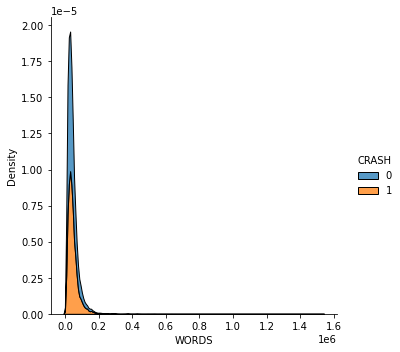

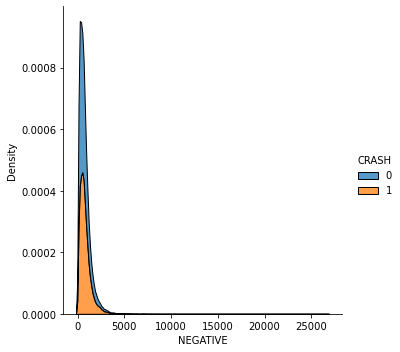

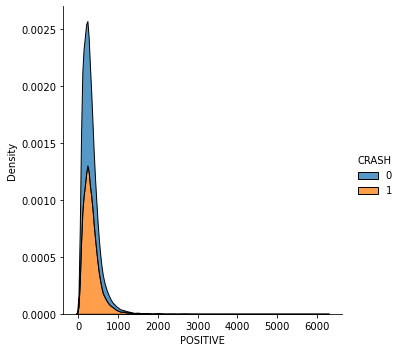

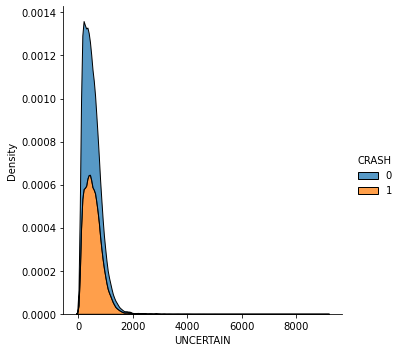

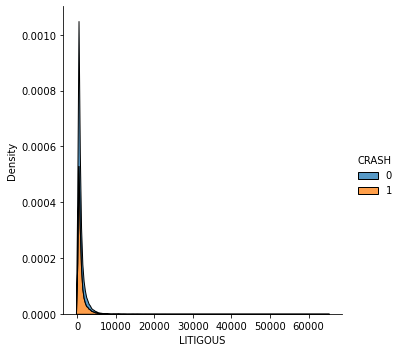

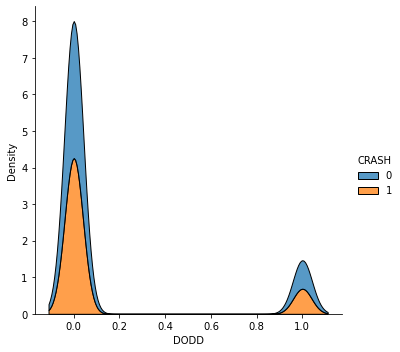

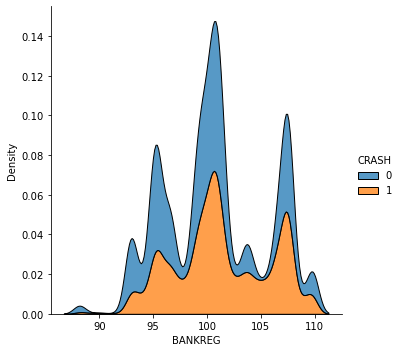

In [22]:
#Display plots for all variables 
variables = X.columns

for z in variables:
    sns.displot(data=temp, x= z, hue='CRASH', kind="kde", multiple="stack")


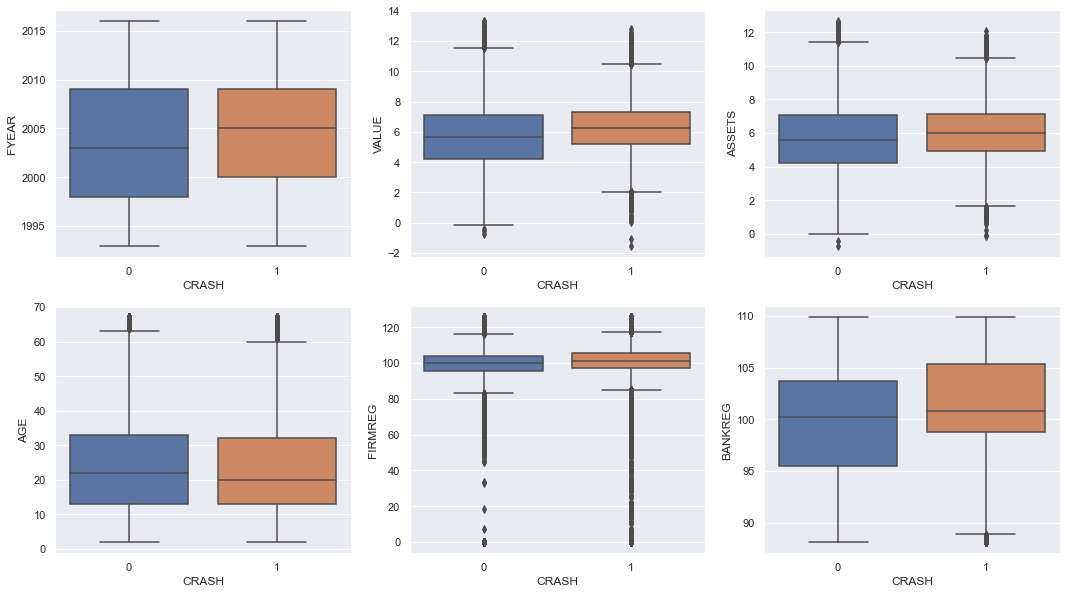

In [23]:
#Boxplots for selected variables 
sns.set(style="darkgrid")
variables = ['FYEAR', 'VALUE', 'ASSETS', 'AGE','FIRMREG', 'BANKREG', ]
fig, axes = plt.subplots(2,3, figsize = (18,10))

i = 0 
a = 0

for z in variables:
    if i > 2: 
        a += 1
        i = 0
    else: 
        pass
  
    
    sns.boxplot(ax = axes[a,i], x="CRASH", y=z, data=temp)
    
    i += 1

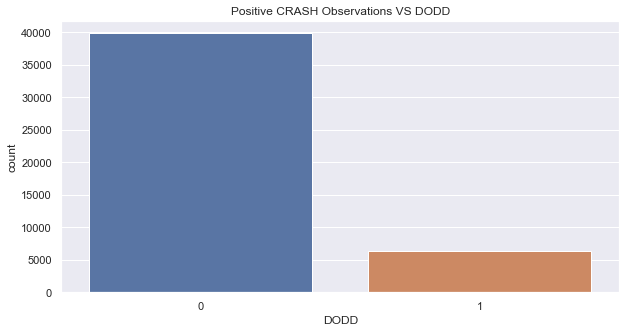

0    78026
1    14364
Name: DODD, dtype: int64

In [24]:
#Number of POSITIVE crashes vs DODD
bar = temp.loc[temp['CRASH'] == 1, ['DODD']]

plt.figure(figsize=(10, 5))
sns.countplot(bar['DODD'])
plt.title('Positive CRASH Observations VS DODD')
plt.show()

temp['DODD'].value_counts()

In [25]:
#Inlcude DODD in variables 
variables.append("DODD")

In [26]:
# Finding Means of classes for each variable
for z in variables: 
    print("Positive AVG:", mean(temp.loc[temp['CRASH'] == 1, [z]]))
    print("Negative AVG:", mean(temp.loc[temp['CRASH'] == 0, [z]]))

Positive AVG: FYEAR    2004.748479
dtype: float64
Negative AVG: FYEAR    2003.540297
dtype: float64
Positive AVG: VALUE    6.275441
dtype: float64
Negative AVG: VALUE    5.717128
dtype: float64
Positive AVG: ASSETS    6.076578
dtype: float64
Negative AVG: ASSETS    5.700012
dtype: float64
Positive AVG: AGE    23.855829
dtype: float64
Negative AVG: AGE    25.067172
dtype: float64
Positive AVG: FIRMREG    101.420036
dtype: float32
Negative AVG: FIRMREG    99.788681
dtype: float32
Positive AVG: BANKREG    101.347821
dtype: float64
Negative AVG: BANKREG    100.171613
dtype: float64
Positive AVG: DODD    0.138695
dtype: float64
Negative AVG: DODD    0.172248
dtype: float64


In [27]:
#Mean Vs Median to find skewness 
for z in variables:
    print("Positive Mean:", mean(temp.loc[temp['CRASH'] == 1, [z]]))
    print("Positive Median:", temp.loc[temp['CRASH'] == 1, [z]].median())
    print("Negative Mean:", mean(temp.loc[temp['CRASH'] == 0, [z]]))
    print("Negative Median", temp.loc[temp['CRASH'] == 0, [z]].median())

Positive Mean: FYEAR    2004.748479
dtype: float64
Positive Median: FYEAR    2005.0
dtype: float64
Negative Mean: FYEAR    2003.540297
dtype: float64
Negative Median FYEAR    2003.0
dtype: float64
Positive Mean: VALUE    6.275441
dtype: float64
Positive Median: VALUE    6.27878
dtype: float64
Negative Mean: VALUE    5.717128
dtype: float64
Negative Median VALUE    5.633638
dtype: float64
Positive Mean: ASSETS    6.076578
dtype: float64
Positive Median: ASSETS    6.017946
dtype: float64
Negative Mean: ASSETS    5.700012
dtype: float64
Negative Median ASSETS    5.601159
dtype: float64
Positive Mean: AGE    23.855829
dtype: float64
Positive Median: AGE    20.0
dtype: float64
Negative Mean: AGE    25.067172
dtype: float64
Negative Median AGE    22.0
dtype: float64
Positive Mean: FIRMREG    101.420036
dtype: float32
Positive Median: FIRMREG    101.16214
dtype: float32
Negative Mean: FIRMREG    99.788681
dtype: float32
Negative Median FIRMREG    99.847656
dtype: float32
Positive Mean: BANKRE

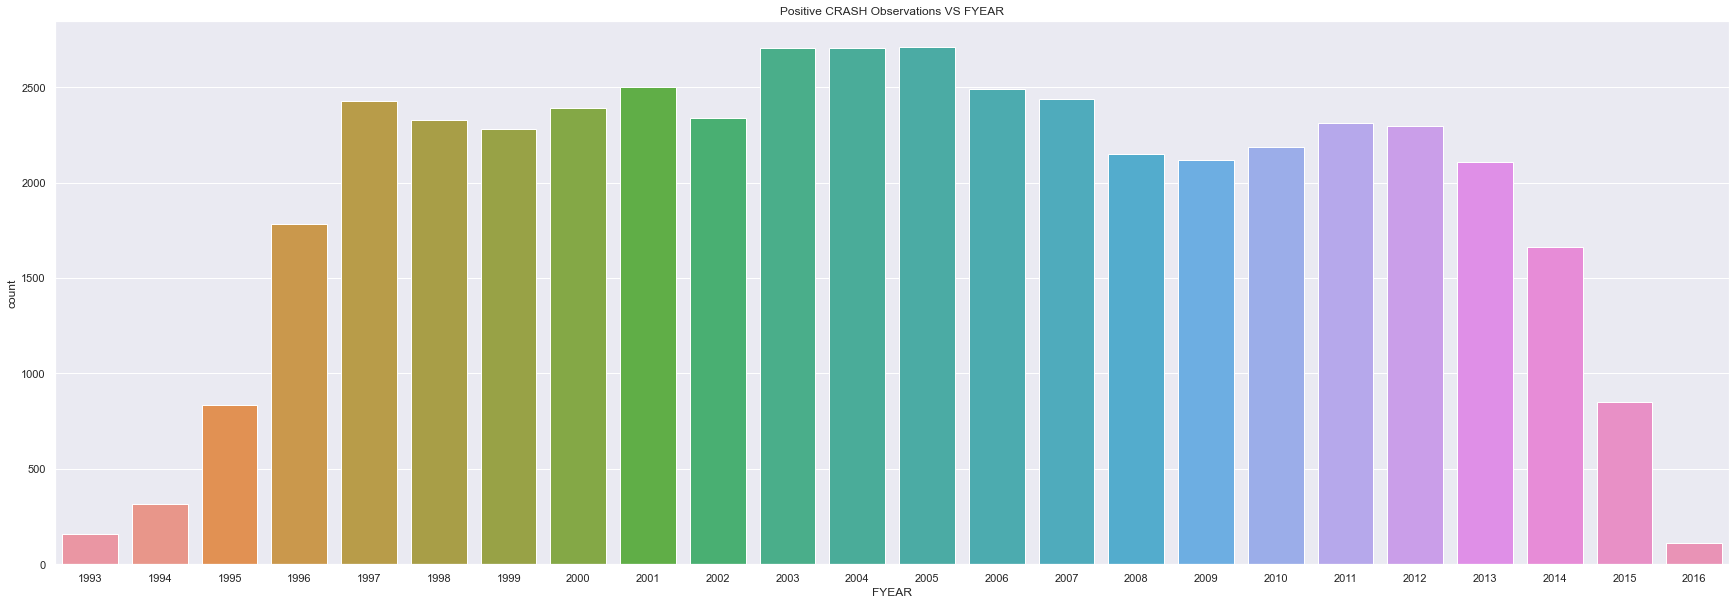

In [29]:
#Numver of crashes per year 
bar1 = temp.loc[temp['CRASH'] == 1, ['FYEAR']]
plt.figure(figsize=(30, 10))
sns.countplot(bar1['FYEAR'])
plt.title('Positive CRASH Observations VS FYEAR')
plt.show()

In [30]:
# Finding average FIRMREG per year 
yrs = []
for i in range(1993, 2017): 
    #i = "'"+ str(i) + "'"
    yrs.append(i)

avgfirmreg = []
for x in yrs: 
    z = temp.loc[temp['FYEAR'] == x, ['FIRMREG']].mean()
    avgfirmreg.append(z.to_string())


In [31]:
#Obtain only averages and clean data 
avgfirmreg2 = []
for x in avgfirmreg:
    z = remove_string = re.sub("FIRMREG    ", "", x)
    avgfirmreg2.append(float(z))

In [32]:
#Obtain number of positive crashes per year 
firmregfreq = list(bar1['FYEAR'].value_counts().sort_index())

In [33]:
# Create a dataframe with average BANKREG and FIRMREG 
df_reg = pd.DataFrame()
df_reg['FYEAR'] = yrs
df_reg['Average FIRMREG'] = avgfirmreg2
df_reg['Crashes'] = firmregfreq
df_reg['BANKREG'] = 88.11152
df_reg.loc[df_reg['FYEAR'] == 1994, 'BANKREG'] = 93.39980
df_reg.loc[df_reg['FYEAR'] == 1995, 'BANKREG'] = 94.81907
df_reg.loc[df_reg['FYEAR'] == 1996, 'BANKREG'] = 96.59152
df_reg.loc[df_reg['FYEAR'] == 1997, 'BANKREG'] = 95.47455
df_reg.loc[df_reg['FYEAR'] == 1998, 'BANKREG'] = 92.86000
df_reg.loc[df_reg['FYEAR'] == 1999, 'BANKREG'] = 95.07188
df_reg.loc[df_reg['FYEAR'] == 2000, 'BANKREG'] = 101.53664
df_reg.loc[df_reg['FYEAR'] == 2001, 'BANKREG'] = 99.70758
df_reg.loc[df_reg['FYEAR'] == 2002, 'BANKREG'] = 99.26804
df_reg.loc[df_reg['FYEAR'] == 2003, 'BANKREG'] = 100.55630
df_reg.loc[df_reg['FYEAR'] == 2004, 'BANKREG'] = 100.78033
df_reg.loc[df_reg['FYEAR'] == 2005, 'BANKREG'] = 98.83892
df_reg.loc[df_reg['FYEAR'] == 2006, 'BANKREG'] = 100.17723
df_reg.loc[df_reg['FYEAR'] == 2007, 'BANKREG'] = 101.01414
df_reg.loc[df_reg['FYEAR'] == 2008, 'BANKREG'] = 101.13760
df_reg.loc[df_reg['FYEAR'] == 2009, 'BANKREG'] = 103.72409 
df_reg.loc[df_reg['FYEAR'] == 2010, 'BANKREG'] = 107.13873
df_reg.loc[df_reg['FYEAR'] == 2011, 'BANKREG'] = 107.69250
df_reg.loc[df_reg['FYEAR'] == 2012, 'BANKREG'] = 109.85559
df_reg.loc[df_reg['FYEAR'] == 2013, 'BANKREG'] = 107.62720
df_reg.loc[df_reg['FYEAR'] == 2014, 'BANKREG'] = 106.49673
df_reg.loc[df_reg['FYEAR'] == 2015, 'BANKREG'] = 107.46543
df_reg.loc[df_reg['FYEAR'] == 2016, 'BANKREG'] = 107.64746

<AxesSubplot:xlabel='FYEAR', ylabel='Average FIRMREG'>

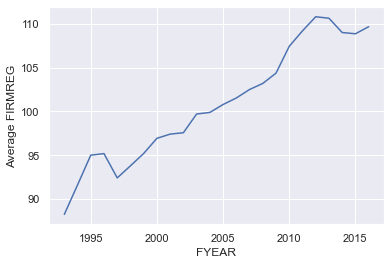

In [34]:
#Average FIRMREG vs FYEAR - line plot 
sns.lineplot(data=df_reg, x='FYEAR', y='Average FIRMREG')

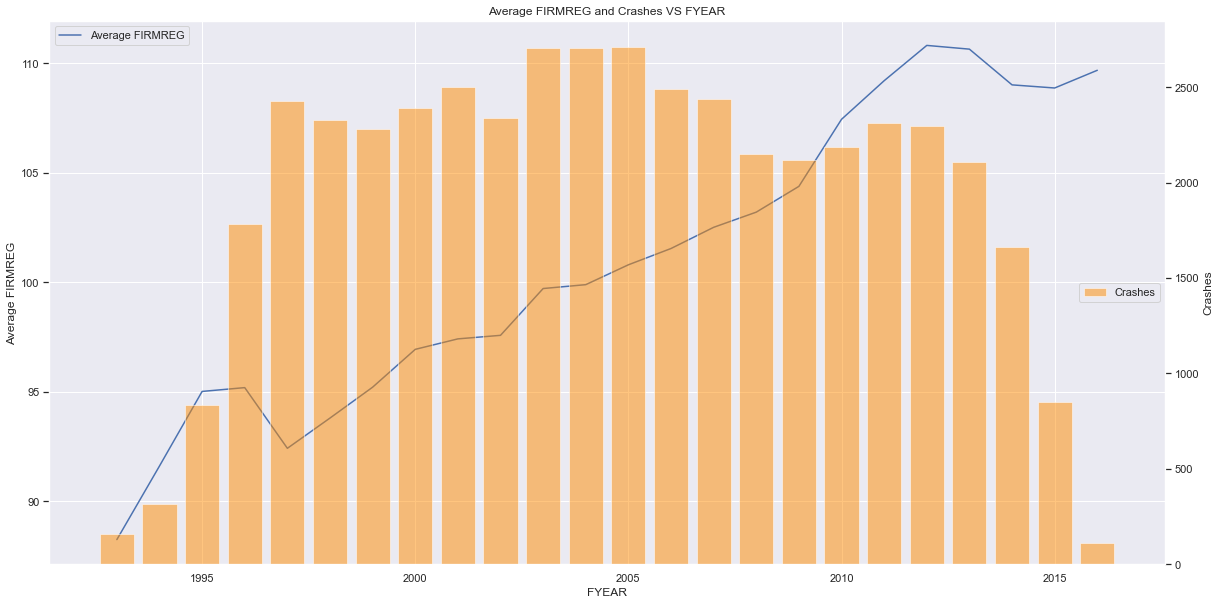

In [35]:
#Average FIRMREG and Number of Crashes VS FYEAR
fig, ax1 = plt.subplots(figsize=(20,10))

ax1.plot('FYEAR', 'Average FIRMREG', data=df_reg) 
ax1.set_ylabel('Average FIRMREG')
ax1.set_xlabel('FYEAR')
ax1.legend(['Average FIRMREG'], loc="upper left")
ax2 = ax1.twinx()
ax2.bar('FYEAR','Crashes', data=df_reg, color='darkorange', alpha = 0.5)
ax2.grid(False) 
ax2.set_ylabel('Crashes')

ax2.legend(['Crashes'], loc="center right")
plt.title('Average FIRMREG and Crashes VS FYEAR')

plt.show()


<AxesSubplot:xlabel='FYEAR', ylabel='BANKREG'>

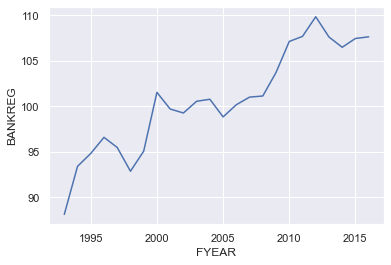

In [36]:
#Average BANKREG vs FYEAR
sns.lineplot(data=df_reg, x='FYEAR', y='BANKREG')

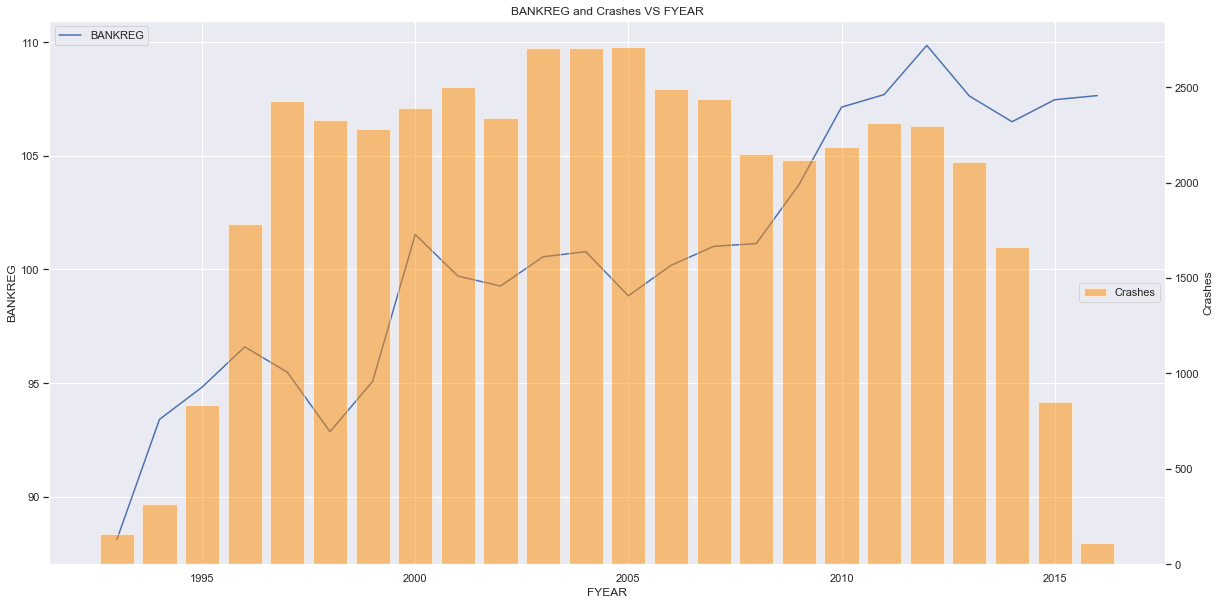

In [37]:
#Average BANKREG and Number of Crashes vs FYEAR
fig, ax1 = plt.subplots(figsize=(20,10))

ax1.plot('FYEAR', 'BANKREG', data=df_reg) 
ax1.set_ylabel('BANKREG')
ax1.set_xlabel('FYEAR')
ax1.legend(['BANKREG'], loc="upper left")
ax2 = ax1.twinx()
ax2.bar('FYEAR','Crashes', data=df_reg, color='darkorange', alpha = 0.5)
ax2.grid(False) 
ax2.set_ylabel('Crashes')

ax2.legend(['Crashes'], loc="center right")
plt.title('BANKREG and Crashes VS FYEAR')

plt.show()

# Logistic Regression 

In [111]:
# 5-fold CV results 

LG = LogisticRegression()
cv = KFold(n_splits=5, random_state=92, shuffle=True)
scores_prec = cross_val_score(LG, X, y, scoring='precision', cv=cv, n_jobs=-1)
scores_rec = cross_val_score(LG, X, y, scoring='recall', cv=cv, n_jobs=-1)
scores_roc = cross_val_score(LG, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(LG, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
scores_f1 = cross_val_score(LG, X, y, scoring='f1', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))
print('Precision: %.3f (%.3f)' % (mean(scores_prec), std(scores_prec)))
print('Recall: %.3f (%.3f)' % (mean(scores_rec), std(scores_rec)))
print('F1: %.3f (%.3f)' % (mean(scores_f1), std(scores_f1)))
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))

Accuracy: 0.560 (0.002)
Precision: 0.568 (0.004)
Recall: 0.501 (0.009)
F1: 0.532 (0.005)
AUC_ROC Score: 0.585 (0.003)


In [113]:
# Re-run 30 times for model comparison 
DT_all_lg = []
for i in range(30): 
    r = random.randint(0,1000) # This ensures splits are randomised 
    d = random.randint(0,1000) # This ensures new random state everytime model is ran
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=r)
    LG = LogisticRegression(random_state=d)
    LGP = LG.fit(X_train,y_train)
    y_pred = LGP.predict(X_test)
    score = metrics.accuracy_score(y_test, y_pred)
    DT_all_lg.append(score)

print(DT_all_lg)
print(mean(DT_all_lg))

[0.5544431215499513, 0.5592055417252949, 0.5619114622794674, 0.5572031605152072, 0.5629938305011365, 0.5598549626582964, 0.5588808312587943, 0.5511960168849442, 0.5611538045242992, 0.558123173503626, 0.5614785149907998, 0.5623985279792185, 0.5612079229353826, 0.5654832774109753, 0.5612079229353826, 0.5516830825846953, 0.5660244615218097, 0.5566619764043728, 0.5568243316376231, 0.5550925424829527, 0.5591514233142115, 0.5570408052819569, 0.559097304903128, 0.5629938305011365, 0.5585561207922936, 0.5570949236930404, 0.5636432514341378, 0.560287909946964, 0.5571490421041239, 0.556337265937872]
0.5591460114731032


# Decision Trees

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

### Full Model 

In [15]:
# Hold-out method Full decision tree (Gini)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

#Decision Tree w/ All (Gini)
DT = DecisionTreeClassifier(random_state=1)

# Training Decision Tree Classifer
DTree = DT.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = DTree.predict(X_test)

#Accuracy score for Full Decision Tree 
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7967312479705596


In [430]:
#5-fold CV for full decision tree (Gini)
DT = DecisionTreeClassifier()
cv = KFold(n_splits=5, random_state=32, shuffle=True)
scores_prec = cross_val_score(DT, X, y, scoring='precision', cv=cv, n_jobs=-1)
scores_rec = cross_val_score(DT, X, y, scoring='recall', cv=cv, n_jobs=-1)
scores_roc = cross_val_score(DT, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(DT, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
scores_f1 = cross_val_score(DT, X, y, scoring='f1', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))
print('Precision: %.3f (%.3f)' % (mean(scores_prec), std(scores_prec)))
print('Recall: %.3f (%.3f)' % (mean(scores_rec), std(scores_rec)))
print('F1: %.3f (%.3f)' % (mean(scores_f1), std(scores_f1)))
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))

Accuracy: 0.788 (0.002)
Precision: 0.777 (0.004)
Recall: 0.805 (0.003)
F1: 0.790 (0.003)
AUC_ROC Score: 0.787 (0.002)


In [27]:
#Entropy full decision tree
DT = DecisionTreeClassifier(random_state = 9, criterion="entropy")

# Training Decision Tree Classifer
DTree = DT.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = DTree.predict(X_test)

#Accuracy score for Full Decision Tree 
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7945665115272216


In [429]:
#5-fold CV for full decision tree (Entropy)
DT = DecisionTreeClassifier(criterion="entropy")
cv = KFold(n_splits=5, random_state=32, shuffle=True)
scores_prec = cross_val_score(DT, X, y, scoring='precision', cv=cv, n_jobs=-1)
scores_rec = cross_val_score(DT, X, y, scoring='recall', cv=cv, n_jobs=-1)
scores_roc = cross_val_score(DT, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(DT, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
scores_f1 = cross_val_score(DT, X, y, scoring='f1', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))
print('Precision: %.3f (%.3f)' % (mean(scores_prec), std(scores_prec)))
print('Recall: %.3f (%.3f)' % (mean(scores_rec), std(scores_rec)))
print('F1: %.3f (%.3f)' % (mean(scores_f1), std(scores_f1)))
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))

Accuracy: 0.794 (0.004)
Precision: 0.788 (0.002)
Recall: 0.805 (0.006)
F1: 0.796 (0.002)
AUC_ROC Score: 0.794 (0.005)


In [235]:
# Re-run 30 times for model comparison 

# Entropy model chosen due to higher performance 
DT_all_full2= []
for i in range(30): 
    r = random.randint(0,1000)
    d = random.randint(0,1000)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=r)
    DT = DecisionTreeClassifier(random_state=d, criterion="entropy")
    DTree = DT.fit(X_train,y_train)
    y_pred = DTree.predict(X_test)
    score = metrics.accuracy_score(y_test, y_pred)
    DT_all_full2.append(score)

print(DT_all_full2)
print(mean(DT_all_full2))

[0.7949994588158892, 0.7937547353609699, 0.8000324710466501, 0.7934841433055525, 0.7920770646173828, 0.793538261716636, 0.7970018400259768, 0.7937547353609699, 0.7915899989176318, 0.7984089187141465, 0.797380668903561, 0.7999242342244832, 0.8028466284229895, 0.7965688927373092, 0.7985712739473969, 0.7972183136703106, 0.8013313129126529, 0.7977594977811452, 0.7992206948803983, 0.798354800303063, 0.7915899989176318, 0.8015477865569867, 0.795702998159974, 0.7979759714254789, 0.7970559584370603, 0.7894252624742938, 0.7997618789912329, 0.7974347873146445, 0.7954324061045568, 0.8009524840350687]
0.7968232492694014


### Pre - Pruning 

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [191]:
#Pre-pruning (Gini) using GridSearch CV
param_grid = {
    "max_depth": [3,5,10,15,20],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

DT = DecisionTreeClassifier(random_state=2)
grid_cv_pre_gini = GridSearchCV(DT, param_grid, scoring="accuracy", n_jobs=-1, cv=5).fit(X_train, y_train)

print("Param for GS", grid_cv_pre_gini.best_params_)
print("CV score for GS", grid_cv_pre_gini.best_score_)

Param for GS {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5}
CV score for GS 0.7909676662482227


In [427]:
#5-fold cross-validation pre-pruned tree (Gini)
DT = DecisionTreeClassifier(random_state= 89, max_depth = 20, min_samples_leaf = 2, min_samples_split = 5)
cv = KFold(n_splits=5, random_state=2, shuffle=True)
scores_prec = cross_val_score(DT, X, y, scoring='precision', cv=cv, n_jobs=-1)
scores_rec = cross_val_score(DT, X, y, scoring='recall', cv=cv, n_jobs=-1)
scores_roc = cross_val_score(DT, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(DT, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
scores_f1 = cross_val_score(DT, X, y, scoring='f1', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))
print('Precision: %.3f (%.3f)' % (mean(scores_prec), std(scores_prec)))
print('Recall: %.3f (%.3f)' % (mean(scores_rec), std(scores_rec)))
print('F1: %.3f (%.3f)' % (mean(scores_f1), std(scores_f1)))
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))

Accuracy: 0.795 (0.003)
Precision: 0.804 (0.007)
Recall: 0.779 (0.010)
F1: 0.791 (0.003)
AUC_ROC Score: 0.830 (0.004)


In [198]:
#Pre-pruning (Entropy) using GridSearch CV
param_grid = {
    "max_depth": [3,5,10,15,20],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

DT = DecisionTreeClassifier(random_state=2, criterion="entropy" )
grid_cv_pre_en = GridSearchCV(DT, param_grid, scoring="accuracy", n_jobs=-1, cv=5).fit(X_train, y_train)

print("Param for GS", grid_cv_pre_en.best_params_)
print("CV score for GS", grid_cv_pre_en.best_score_)

Param for GS {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}
CV score for GS 0.7866651452964257


In [428]:
#5-fold cross-validation pre-pruned tree (Entropy)
DT = DecisionTreeClassifier(random_state=21, max_depth = 20, min_samples_leaf = 2, min_samples_split = 2, criterion="entropy")
cv = KFold(n_splits=5, random_state=12, shuffle=True)
scores_prec = cross_val_score(DT, X, y, scoring='precision', cv=cv, n_jobs=-1)
scores_rec = cross_val_score(DT, X, y, scoring='recall', cv=cv, n_jobs=-1)
scores_roc = cross_val_score(DT, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(DT, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
scores_f1 = cross_val_score(DT, X, y, scoring='f1', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))
print('Precision: %.3f (%.3f)' % (mean(scores_prec), std(scores_prec)))
print('Recall: %.3f (%.3f)' % (mean(scores_rec), std(scores_rec)))
print('F1: %.3f (%.3f)' % (mean(scores_f1), std(scores_f1)))
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))

Accuracy: 0.799 (0.007)
Precision: 0.814 (0.021)
Recall: 0.776 (0.010)
F1: 0.794 (0.005)
AUC_ROC Score: 0.838 (0.005)


In [244]:
# Obtain 5-fold CV accuracy score for each combination 
mean_sco = (grid_cv_pre_en.cv_results_['mean_test_score'])

In [247]:
#Combination of all parameters 
md = [3,5,10,15,20]
ms_leaf = [1,2,5]
ms_split =[2,5,7,10]
comb = list(itertools.product(md, ms_leaf, ms_split))
print(comb)

[(3, 1, 2), (3, 1, 5), (3, 1, 7), (3, 1, 10), (3, 2, 2), (3, 2, 5), (3, 2, 7), (3, 2, 10), (3, 5, 2), (3, 5, 5), (3, 5, 7), (3, 5, 10), (5, 1, 2), (5, 1, 5), (5, 1, 7), (5, 1, 10), (5, 2, 2), (5, 2, 5), (5, 2, 7), (5, 2, 10), (5, 5, 2), (5, 5, 5), (5, 5, 7), (5, 5, 10), (10, 1, 2), (10, 1, 5), (10, 1, 7), (10, 1, 10), (10, 2, 2), (10, 2, 5), (10, 2, 7), (10, 2, 10), (10, 5, 2), (10, 5, 5), (10, 5, 7), (10, 5, 10), (15, 1, 2), (15, 1, 5), (15, 1, 7), (15, 1, 10), (15, 2, 2), (15, 2, 5), (15, 2, 7), (15, 2, 10), (15, 5, 2), (15, 5, 5), (15, 5, 7), (15, 5, 10), (20, 1, 2), (20, 1, 5), (20, 1, 7), (20, 1, 10), (20, 2, 2), (20, 2, 5), (20, 2, 7), (20, 2, 10), (20, 5, 2), (20, 5, 5), (20, 5, 7), (20, 5, 10)]


In [248]:
#Seperating the parameters into their own lists 
md1 = []
ms_leaf1 = []
ms_split1 = []
for x in comb: 
    md1.append(x[0])
    ms_leaf1.append(x[1])
    ms_split1.append(x[2])

In [250]:
#Putting the lists into a dictionary 
d_prune = {'Max Depth': md1, 'Min Sample Leaf': ms_leaf1, 'Min Sample Split': ms_split1, 'AUC':mean_sco}
df_prune = pd.DataFrame(d_prune)

C:\Users\shezo\AppData\Local\Temp\ipykernel_16892\1299295737.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(img, label='Average Accuarcy Score', orientation = 'horizontal')


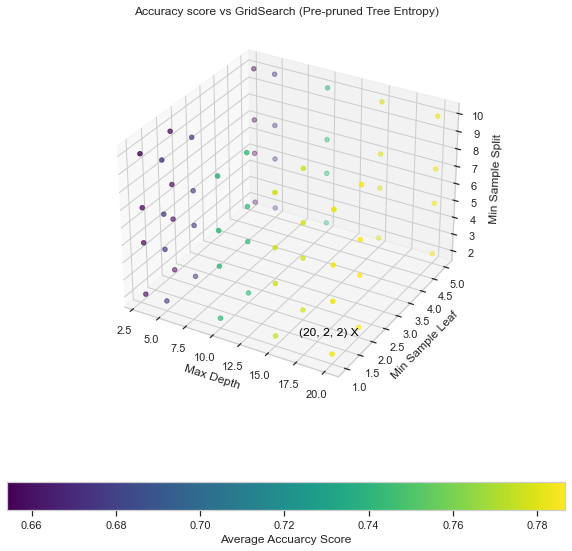

In [254]:
#Creating a 4D plot of pre-pruning scores and results 
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Accuracy score vs GridSearch (Pre-pruned Tree Entropy)")
xp = md1
ax.set_xlabel('Max Depth')

yp = ms_leaf1
ax.set_ylabel('Min Sample Leaf')
zp = ms_split1
ax.set_zlabel('Min Sample Split')
cp = mean_sco
ax.text(20, 2, 2, "(20, 2, 2) X", color='black', verticalalignment= 'top',horizontalalignment = 'right')
img = ax.scatter(xp, yp, zp, c=cp, cmap="viridis")
fig.colorbar(img, label='Average Accuarcy Score', orientation = 'horizontal')
plt.show()

In [234]:
# Re-run 30 times for model comparison 

# Entropy model chosen due to higher performance 
# Optimal paramters are inputted 
DT_all_pre2= []
for i in range(30): 
    r = random.randint(0,1000)
    d = random.randint(0,1000)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=r)
    DT = DecisionTreeClassifier(random_state=d, max_depth = 20, min_samples_leaf = 2, min_samples_split = 2, criterion="entropy")
    DTree = DT.fit(X_train,y_train)
    y_pred = DTree.predict(X_test)
    score = metrics.accuracy_score(y_test, y_pred)
    DT_all_pre2.append(score)

print(DT_all_pre2)
print(mean(DT_all_pre2))

[0.8075549301872497, 0.7947829851715553, 0.7944582747050547, 0.7957571165710575, 0.7918064725619656, 0.7961900638597251, 0.8028466284229895, 0.8004112999242342, 0.8074466933650828, 0.7930511960168849, 0.8010607208572357, 0.7938088537720532, 0.7940794458274705, 0.7966771295594761, 0.7970018400259768, 0.7949453404048057, 0.7853122632319515, 0.7864487498647039, 0.8021430890789046, 0.8058772594436627, 0.7952700508713064, 0.8070678644874987, 0.7942418010607208, 0.803496049355991, 0.8019807338456543, 0.7975971425478948, 0.8039289966446586, 0.8014395497348198, 0.8006277735685681, 0.802900746834073]
0.7983403687267739


### Post - pruned

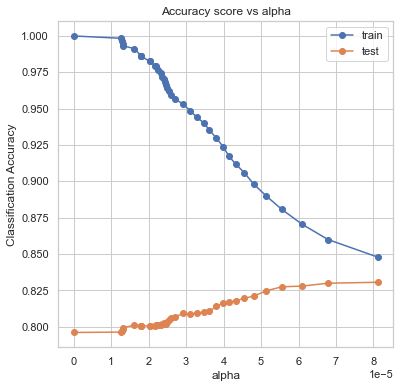

In [210]:
#Post-pruned decision tree (Gini) - Cost complexity pruning
DT = DecisionTreeClassifier(random_state = 2)
DT.fit(X_train,y_train)

#Finding all ccp alphas 
path = DT.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas= path.ccp_alphas

# Testing every 100th ccp alpha to reduce computation time 
ccp_alphas = ccp_alphas[0::100]

#Train models using alpha scores 
DTs = []
for ccp_alpha in ccp_alphas:
    DT = DecisionTreeClassifier(random_state=2, ccp_alpha=ccp_alpha)
    DT.fit(X_train, y_train)
    DTs.append(DT)

DTs = DTs[:-1]
ccp_alphas = ccp_alphas[:-1]

# Split into training and testing 
train_scores = [accuracy_score(y_train, DT.predict(X_train)) for DT in DTs]
test_scores = [accuracy_score(y_test, DT.predict(X_test)) for DT in DTs]


fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlabel("alpha")
ax.set_ylabel("Classification Accuracy")
ax.set_title("Accuracy score vs alpha")
ax.plot(ccp_alphas, train_scores, marker='o', label="train")
ax.plot(ccp_alphas, test_scores, marker='o', label="test")
ax.legend()

plt.show()

#Finding maximum test accuracy and corresponding ccp_alpha (Gini)
maxT = max(test_scores)
print(maxT)
maxT_index = test_scores.index(maxT)
maxT_ccp_gini = ccp_alphas[maxT_index]
print(maxT_ccp_gini)

In [212]:
# 5-fold CV for post-pruned Decision tree (Gini)
DT = DecisionTreeClassifier(random_state=2, ccp_alpha = maxT_ccp_gini)
cv = KFold(n_splits=5, random_state=2, shuffle=True)
scores_prec = cross_val_score(DT, X, y, scoring='precision', cv=cv, n_jobs=-1)
scores_rec = cross_val_score(DT, X, y, scoring='recall', cv=cv, n_jobs=-1)
scores_roc = cross_val_score(DT, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(DT, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
scores_f1 = cross_val_score(DT, X, y, scoring='f1', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))
print('Precision: %.3f (%.3f)' % (mean(scores_prec), std(scores_prec)))
print('Recall: %.3f (%.3f)' % (mean(scores_rec), std(scores_rec)))
print('F1: %.3f (%.3f)' % (mean(scores_f1), std(scores_f1)))
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))

Accuracy: 0.827 (0.004)
Precision: 0.931 (0.010)
Recall: 0.705 (0.008)
F1: 0.803 (0.006)
AUC_ROC Score: 0.871 (0.005)


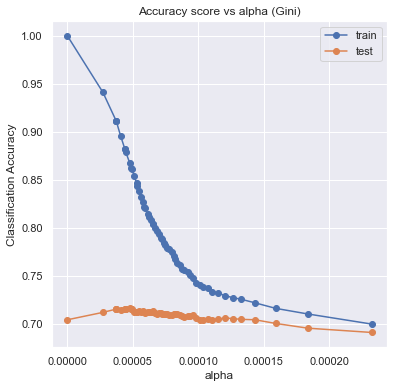

0.7162030522783851
4.7632637987379676e-05


In [64]:
#Post-pruned decision tree (Entropy) - Cost complexity pruning
DT = DecisionTreeClassifier(random_state = 23, criterion = "entropy")
DT.fit(X_train,y_train)

path = DT.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas


ccp_alphas = ccp_alphas[0::100]

DTs = []
for ccp_alpha in ccp_alphas:
    DT = DecisionTreeClassifier(random_state=2, ccp_alpha=ccp_alpha)
    DT.fit(X_train, y_train)
    DTs.append(DT)

DTs = DTs[:-1]
ccp_alphas = ccp_alphas[:-1]

train_scores = [accuracy_score(y_train, DT.predict(X_train)) for DT in DTs]
test_scores = [accuracy_score(y_test, DT.predict(X_test)) for DT in DTs]

fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlabel("alpha")
ax.set_ylabel("Classification Accuracy")
ax.set_title("Accuracy score vs alpha (Gini)")
ax.plot(ccp_alphas, train_scores, marker='o', label="train")
ax.plot(ccp_alphas, test_scores, marker='o', label="test")
ax.legend()
plt.show()

#Finding maximum test accuracy and corresponding ccp_alpha (Entropy)
maxT = max(test_scores)
print(maxT)
maxT_index = test_scores.index(maxT)
maxT_ccp_entropy = ccp_alphas[maxT_index]
print(maxT_ccp_entropy)

In [65]:
# 5-fold CV for post-pruned Decision tree (Entropy)
DT = DecisionTreeClassifier(criterion = "entropy", random_state=2, ccp_alpha = maxT_ccp_entropy)
cv = KFold(n_splits=5, random_state=2, shuffle=True)
scores_prec = cross_val_score(DT, X, y, scoring='precision', cv=cv, n_jobs=-1)
scores_rec = cross_val_score(DT, X, y, scoring='recall', cv=cv, n_jobs=-1)
scores_roc = cross_val_score(DT, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(DT, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
scores_f1 = cross_val_score(DT, X, y, scoring='f1', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))
print('Precision: %.3f (%.3f)' % (mean(scores_prec), std(scores_prec)))
print('Recall: %.3f (%.3f)' % (mean(scores_rec), std(scores_rec)))
print('F1: %.3f (%.3f)' % (mean(scores_f1), std(scores_f1)))
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))

Accuracy: 0.798 (0.001)
Precision: 0.793 (0.003)
Recall: 0.808 (0.004)
F1: 0.800 (0.003)
AUC_ROC Score: 0.807 (0.001)


In [220]:
# Re-run 30 times for model comparison 

# Gini model chosen due to higher performance 
DT_all_post2= []
for i in range(30): 
    r = random.randint(0,1000)
    d = random.randint(0,1000)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=r)
    DT = DecisionTreeClassifier(random_state=d, ccp_alpha = maxT_ccp_gini)
    DTree = DT.fit(X_train,y_train)
    y_pred = DTree.predict(X_test)
    score = metrics.accuracy_score(y_test, y_pred)
    DT_all_post2.append(score)

print(DT_all_post2)
print(mean(DT_all_post2))

[0.8300140707868817, 0.8274705054659596, 0.8328823465743046, 0.8284446368654617, 0.8229786773460331, 0.8385106613269835, 0.8229786773460331, 0.8184868492261067, 0.8254681242558718, 0.8269834397662085, 0.8307717285420501, 0.8315293862972183, 0.8335858859183894, 0.824764584911787, 0.8185409676371902, 0.8165927048381859, 0.8298517155536314, 0.8361835696503951, 0.828606992098712, 0.826334018833207, 0.8201104015586103, 0.826442255655374, 0.8223833748241152, 0.8228704405238663, 0.8323411624634701, 0.8214633618356965, 0.8195692174477758, 0.8282281632211278, 0.8124255871847602, 0.8306634917198831]
0.8262492333225094


### Bagging Classifier

In [256]:
#5-fold CV for Bagging (not tuned)
BDT = BaggingClassifier()
cv = KFold(n_splits=5, random_state=2, shuffle=True)
scores_prec = cross_val_score(BDT, X, y, scoring='precision', cv=cv, n_jobs=-1)
scores_rec = cross_val_score(BDT, X, y, scoring='recall', cv=cv, n_jobs=-1)
scores_roc = cross_val_score(BDT, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(BDT, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
scores_f1 = cross_val_score(BDT, X, y, scoring='f1', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))
print('Precision: %.3f (%.3f)' % (mean(scores_prec), std(scores_prec)))
print('Recall: %.3f (%.3f)' % (mean(scores_rec), std(scores_rec)))
print('F1: %.3f (%.3f)' % (mean(scores_f1), std(scores_f1)))
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))

Accuracy: 0.854 (0.004)
Precision: 0.932 (0.004)
Recall: 0.761 (0.006)
F1: 0.840 (0.004)
AUC_ROC Score: 0.902 (0.002)


In [194]:
#Bagging Classifier tuning using GridSearch CV
BDT = BaggingClassifier()
param_grid = {
    "n_estimators": [10, 50, 100, 500],
     "max_features": [1, 2, 5, 10, 13]
}


cv = KFold(n_splits=5, random_state=2, shuffle=True)
grid_cv_bag = GridSearchCV(BDT, param_grid, scoring="accuracy", n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv_bag.best_params_)
print("CV score for GS", grid_cv_bag.best_score_)

Param for GS {'max_features': 5, 'n_estimators': 500}
CV score for GS 0.8960385847291947


In [215]:
# 5-fold CV for Tuned Bagging Classifier 
BDT = BaggingClassifier(n_estimators = 500, max_features = 5)
cv = KFold(n_splits=5, random_state=2, shuffle=True)
scores_prec = cross_val_score(BDT, X, y, scoring='precision', cv=cv, n_jobs=-1)
scores_rec = cross_val_score(BDT, X, y, scoring='recall', cv=cv, n_jobs=-1)
scores_roc = cross_val_score(BDT, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(BDT, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
scores_f1 = cross_val_score(BDT, X, y, scoring='f1', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))
print('Precision: %.3f (%.3f)' % (mean(scores_prec), std(scores_prec)))
print('Recall: %.3f (%.3f)' % (mean(scores_rec), std(scores_rec)))
print('F1: %.3f (%.3f)' % (mean(scores_f1), std(scores_f1)))
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))

Accuracy: 0.902 (0.003)
Precision: 0.964 (0.007)
Recall: 0.833 (0.003)
F1: 0.894 (0.002)
AUC_ROC Score: 0.950 (0.001)


In [258]:
#5-fold CV accuracy score for each combination 
mean_sco_bag = (grid_cv_bag.cv_results_['mean_test_score'])

In [259]:
#Combination of all parameters 
mf = [1, 2, 5, 10, 13]
ne = [10, 50, 100, 500]

comb1 = list(itertools.product(mf, ne))
print(comb1)

[(1, 10), (1, 50), (1, 100), (1, 500), (2, 10), (2, 50), (2, 100), (2, 500), (5, 10), (5, 50), (5, 100), (5, 500), (10, 10), (10, 50), (10, 100), (10, 500), (13, 10), (13, 50), (13, 100), (13, 500)]


In [260]:
#Seperating the parameters into their own lists 
mf1 = []
ne1 = []
for x in comb1: 
    mf1.append(x[0])
    ne1.append(x[1])
print(mf1)
print(ne1)
print(mean_sco_bag)

[1, 1, 1, 1, 2, 2, 2, 2, 5, 5, 5, 5, 10, 10, 10, 10, 13, 13, 13, 13]
[10, 50, 100, 500, 10, 50, 100, 500, 10, 50, 100, 500, 10, 50, 100, 500, 10, 50, 100, 500]
[0.64202044 0.70823488 0.72691757 0.75354499 0.67802416 0.795
 0.82289727 0.86502868 0.79307941 0.86607028 0.88391605 0.89603858
 0.84833318 0.88122367 0.88548551 0.89128964 0.84533    0.87827415
 0.8837807  0.88733901]


In [263]:
# Storing lists into dictionary 
GridSearchBag = {"Number of Estimators" : ne1,
                 "Maximum Features" : mf1,
                 "Average Accuracy Score" : mean_sco_bag   
                }

GSBag = pd.DataFrame(GridSearchBag)

Text(0.5, 1.0, 'Accuracy Score VS Number of Estimators')

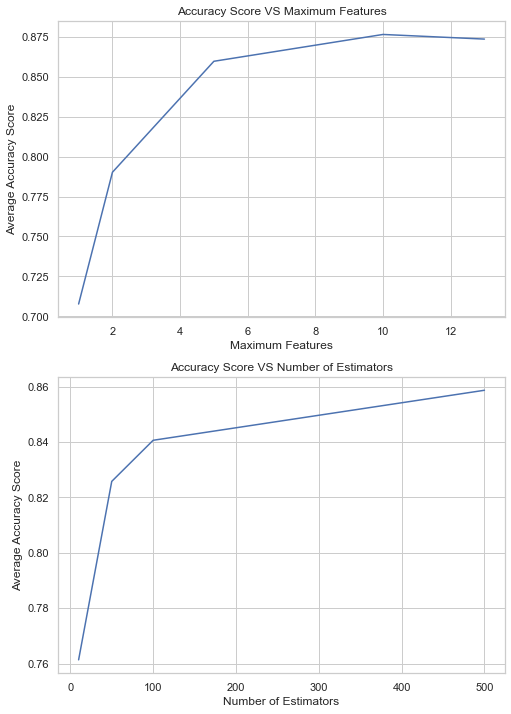

In [276]:
#Plotting average accuracy score vs each parameter 

mf1_mean = list(GSBag.groupby(["Maximum Features"])["Average Accuracy Score"].mean())
ne1_mean = list(GSBag.groupby(["Number of Estimators"])["Average Accuracy Score"].mean())

fig, (ax1, ax2) = plt.subplots(2, figsize=(8,12))

ax1.plot(mf, mf1_mean)
ax1.set_xlabel('Maximum Features')
ax1.set_ylabel('Average Accuracy Score')
ax1.set_title('Accuracy Score VS Maximum Features')

ax2.plot(ne, ne1_mean)
ax2.set_xlabel('Number of Estimators')
ax2.set_ylabel('Average Accuracy Score')
ax2.set_title('Accuracy Score VS Number of Estimators')

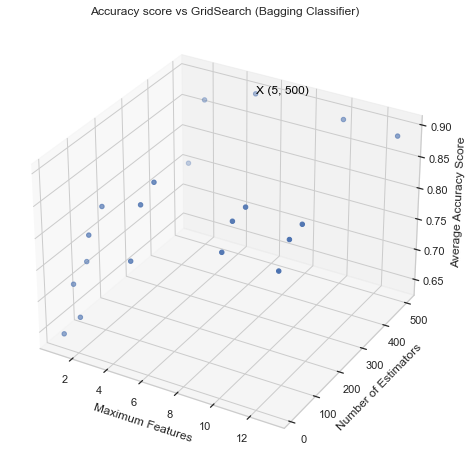

In [279]:
#3D plot for accuracy scores and paramters 
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Accuracy score vs GridSearch (Bagging Classifier)")
xp = mf1
ax.set_xlabel('Maximum Features')

yp = ne1
ax.set_ylabel('Number of Estimators')
zp = mean_sco_bag
ax.set_zlabel('Average Accuracy Score')
ax.text(5, 500, 0.8960385847291947, "X (5, 500)", color='black')
img = ax.scatter(xp, yp, zp)
plt.show()

In [165]:
# Re-run 30 times for model comparison 

# Tuned bagging model chosen due to higher performance
DT_all_bag2= []
for i in range(30): 
    r = random.randint(0,1000)
    d = random.randint(0,1000)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=r)
    BDT = BaggingClassifier(n_estimators = 500, max_features = 5, random_state=d)
    BDTree = BDT.fit(X_train,y_train)
    y_pred = BDTree.predict(X_test)
    score = metrics.accuracy_score(y_test, y_pred)
    DT_all_bag2.append(score)

print(DT_all_bag2)
print(mean(DT_all_bag2))

[0.9027492152830393, 0.9005844788397013, 0.9022080311722048, 0.8998268210845329, 0.8976620846411949, 0.9000432947288668, 0.9010715445394524, 0.9049139517263773, 0.8991774001515316, 0.9014503734170365, 0.8999891763177833, 0.9038315835047083, 0.898744452862864, 0.9055633726593787, 0.8996103474401992, 0.9007468340729516, 0.9007468340729516, 0.9015586102392034, 0.8990691633293646, 0.9011256629505358, 0.8999891763177833, 0.9048057149042105, 0.9025327416387054, 0.8990150449182812, 0.9027492152830393, 0.8993938737958653, 0.8984738608074467, 0.9012880181837861, 0.8979867951076956, 0.9012338997727026]
0.9009380524587798


### Random Forest

In [280]:
#5-fold CV for Random Forest Classifier 
RF = RandomForestClassifier(random_state= 1)
cv = KFold(n_splits=5, random_state=2, shuffle=True)
scores_prec = cross_val_score(RF, X, y, scoring='precision', cv=cv, n_jobs=-1)
scores_rec = cross_val_score(RF, X, y, scoring='recall', cv=cv, n_jobs=-1)
scores_roc = cross_val_score(RF, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(RF, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
scores_f1 = cross_val_score(RF, X, y, scoring='f1', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))
print('Precision: %.3f (%.3f)' % (mean(scores_prec), std(scores_prec)))
print('Recall: %.3f (%.3f)' % (mean(scores_rec), std(scores_rec)))
print('F1: %.3f (%.3f)' % (mean(scores_f1), std(scores_f1)))
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))

Accuracy: 0.858 (0.001)
Precision: 0.899 (0.004)
Recall: 0.806 (0.004)
F1: 0.850 (0.001)
AUC_ROC Score: 0.923 (0.002)


In [195]:
#Finding optimal paramters using GridSearch CV
param_grid = {
    "min_samples_leaf": [1, 3, 4], 
    "n_estimators" : [10, 20, 50, 100], 
    "max_features" : [3,4,5, 6]   
}

RF = RandomForestClassifier(random_state= 49)
grid_cv_rf = GridSearchCV(RF, param_grid, scoring="accuracy", n_jobs=-1, cv=5).fit(X_train, y_train)

print("Param for GS", grid_cv_rf.best_params_)
print("CV score for GS", grid_cv_rf.best_score_)

Param for GS {'max_features': 6, 'min_samples_leaf': 1, 'n_estimators': 100}
CV score for GS 0.8499566483615636


In [282]:
#Finding 5-fold CV accuracy scores for each combination 
mean_sco_rf = list(grid_cv_rf.cv_results_['mean_test_score'])

In [121]:
#Combination of all parameters 
msrf = [1, 3, 4] 
nerf = [10, 20, 50, 100] 
mfrf = [3,4,5, 6]

combrf = list(itertools.product(mfrf, msrf, nerf))
print(combrf)

[(3, 1, 10), (3, 1, 20), (3, 1, 50), (3, 1, 100), (3, 3, 10), (3, 3, 20), (3, 3, 50), (3, 3, 100), (3, 4, 10), (3, 4, 20), (3, 4, 50), (3, 4, 100), (4, 1, 10), (4, 1, 20), (4, 1, 50), (4, 1, 100), (4, 3, 10), (4, 3, 20), (4, 3, 50), (4, 3, 100), (4, 4, 10), (4, 4, 20), (4, 4, 50), (4, 4, 100), (5, 1, 10), (5, 1, 20), (5, 1, 50), (5, 1, 100), (5, 3, 10), (5, 3, 20), (5, 3, 50), (5, 3, 100), (5, 4, 10), (5, 4, 20), (5, 4, 50), (5, 4, 100), (6, 1, 10), (6, 1, 20), (6, 1, 50), (6, 1, 100), (6, 3, 10), (6, 3, 20), (6, 3, 50), (6, 3, 100), (6, 4, 10), (6, 4, 20), (6, 4, 50), (6, 4, 100)]


In [123]:
#Sepearing parameters into their own lists 
msrf1 = []
nerf1 = []
mfrf1 = []
for x in combrf: 
    mfrf1.append(x[0])
    msrf1.append(x[1])
    nerf1.append(x[2])
    

C:\Users\shezo\AppData\Local\Temp\ipykernel_16892\799436796.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(img, label='Accuracy Score', orientation = 'horizontal')


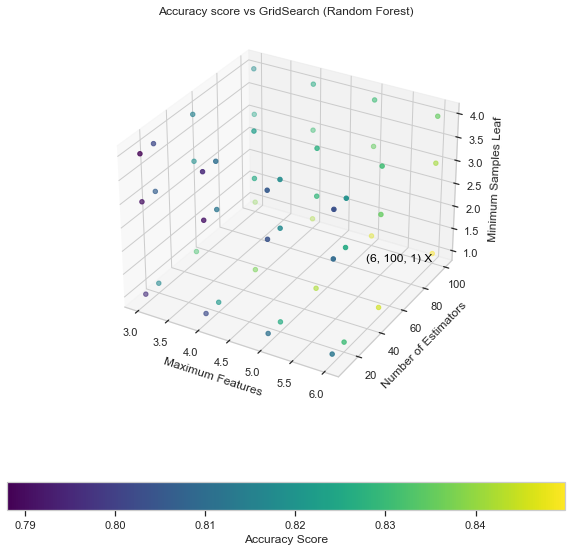

In [284]:
#Plotting parameters and accuracy scores on 4D graph 
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Accuracy score vs GridSearch (Random Forest)")
xrf = mfrf1
ax.set_xlabel('Maximum Features')

yrf = nerf1
ax.set_ylabel('Number of Estimators')
zrf = msrf1
ax.set_zlabel('Minimum Samples Leaf')
crf = mean_sco_rf
ax.text(6, 100, 1, "(6, 100, 1) X", color='black', verticalalignment= 'top',horizontalalignment = 'right')
img = ax.scatter(xrf, yrf, zrf, c=crf, cmap="viridis")
fig.colorbar(img, label='Accuracy Score', orientation = 'horizontal')
plt.show()

In [216]:
# 5-fold CV for tuned Random Forest model 
RF = RandomForestClassifier(random_state= 56, max_features = 6, min_samples_leaf = 1, n_estimators = 100) 
cv = KFold(n_splits=5, random_state=2, shuffle=True)
scores_prec = cross_val_score(RF, X, y, scoring='precision', cv=cv, n_jobs=-1)
scores_rec = cross_val_score(RF, X, y, scoring='recall', cv=cv, n_jobs=-1)
scores_roc = cross_val_score(RF, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(RF, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
scores_f1 = cross_val_score(RF, X, y, scoring='f1', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))
print('Precision: %.3f (%.3f)' % (mean(scores_prec), std(scores_prec)))
print('Recall: %.3f (%.3f)' % (mean(scores_rec), std(scores_rec)))
print('F1: %.3f (%.3f)' % (mean(scores_f1), std(scores_f1)))
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))

Accuracy: 0.861 (0.003)
Precision: 0.909 (0.004)
Recall: 0.802 (0.006)
F1: 0.852 (0.003)
AUC_ROC Score: 0.924 (0.002)


In [166]:
# Re-run 30 times for model comparison 

# Tuned Random Forest model chosen due to higher performance
RF_all2= []
for i in range(30): 
    r = random.randint(0,1000)
    d = random.randint(0,1000)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=r)
    RF = RandomForestClassifier(random_state= d, max_features = 6, min_samples_leaf = 1, n_estimators = 100 )
    RFTree = RF.fit(X_train,y_train)
    y_pred = RFTree.predict(X_test)
    score = metrics.accuracy_score(y_test, y_pred)
    RF_all2.append(score)

print(RF_all2)
print(mean(RF_all2))

[0.8580474077281091, 0.8616192228596169, 0.8611321571598658, 0.8589674207165278, 0.858642710250027, 0.8566944474510229, 0.8599415521160299, 0.8638921961251218, 0.858155644550276, 0.8608615651044486, 0.8643792618248728, 0.8596168416495291, 0.8583179997835264, 0.8679510769563805, 0.8585344734278602, 0.8668145903236281, 0.8557203160515208, 0.8616192228596169, 0.860428617815781, 0.8638380777140383, 0.8621062885593679, 0.8645957354692066, 0.866435761446044, 0.8588591838943609, 0.8611321571598658, 0.8668687087347116, 0.8628098279034527, 0.8572356315618573, 0.8617274596817838, 0.8588591838943609]
0.8611934913590936


### XGBoost 

In [221]:
# 5-fold CV for Boosting Classifier (not tuned)
XDT = XGBClassifier()
cv = KFold(n_splits=5, random_state=2, shuffle=True)
scores_prec = cross_val_score(XDT, X, y, scoring='precision', cv=cv, n_jobs=-1)
scores_rec = cross_val_score(XDT, X, y, scoring='recall', cv=cv, n_jobs=-1)
scores_roc = cross_val_score(XDT, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(XDT, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
scores_f1 = cross_val_score(XDT, X, y, scoring='f1', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))
print('Precision: %.3f (%.3f)' % (mean(scores_prec), std(scores_prec)))
print('Recall: %.3f (%.3f)' % (mean(scores_rec), std(scores_rec)))
print('F1: %.3f (%.3f)' % (mean(scores_f1), std(scores_f1)))
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))

Accuracy: 0.871 (0.002)
Precision: 0.964 (0.002)
Recall: 0.772 (0.004)
F1: 0.857 (0.002)
AUC_ROC Score: 0.914 (0.001)


In [218]:
#Finding optimal paramters using GridSearch CV
param_grid = { 'max_depth': [1,3,5,7,10],
              'learning_rate': [0.01, 0.05, 0.1],
               "n_estimators": [10, 50, 100, 500]
             }
XDT = XGBClassifier()
cv = KFold(n_splits=5, random_state=2, shuffle=True)
grid_cv_xg = GridSearchCV(XDT, param_grid, scoring="accuracy", n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv_xg.best_params_)
print("CV score for GS", grid_cv_xg.best_score_)

C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:41:49] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Param for GS {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}
CV score for GS 0.8792347706599802


In [230]:
#5-fold CV for tuned Boosting Classifier 
XDT = XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=500)
cv = KFold(n_splits=5, random_state=2, shuffle=True)
scores_prec = cross_val_score(XDT, X, y, scoring='precision', cv=cv, n_jobs=-1)
scores_rec = cross_val_score(XDT, X, y, scoring='recall', cv=cv, n_jobs=-1)
scores_roc = cross_val_score(XDT, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(XDT, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
scores_f1 = cross_val_score(XDT, X, y, scoring='f1', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))
print('Precision: %.3f (%.3f)' % (mean(scores_prec), std(scores_prec)))
print('Recall: %.3f (%.3f)' % (mean(scores_rec), std(scores_rec)))
print('F1: %.3f (%.3f)' % (mean(scores_f1), std(scores_f1)))
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))

Accuracy: 0.883 (0.002)
Precision: 0.968 (0.002)
Recall: 0.792 (0.003)
F1: 0.871 (0.002)
AUC_ROC Score: 0.927 (0.002)


In [285]:
# 5-fold CV scores for Boosting Classifier 
mean_sco_xg = list(grid_cv_xg.cv_results_['mean_test_score'])

In [78]:
#Combination of all parameters
mdx = [1,3,5,7,10]
nex = [10, 50, 100, 500]
lrx = [0.01, 0.05, 0.1]

combx = list(itertools.product(lrx, mdx, nex))
print(combx)

[(0.01, 1, 10), (0.01, 1, 50), (0.01, 1, 100), (0.01, 1, 500), (0.01, 3, 10), (0.01, 3, 50), (0.01, 3, 100), (0.01, 3, 500), (0.01, 5, 10), (0.01, 5, 50), (0.01, 5, 100), (0.01, 5, 500), (0.01, 7, 10), (0.01, 7, 50), (0.01, 7, 100), (0.01, 7, 500), (0.01, 10, 10), (0.01, 10, 50), (0.01, 10, 100), (0.01, 10, 500), (0.05, 1, 10), (0.05, 1, 50), (0.05, 1, 100), (0.05, 1, 500), (0.05, 3, 10), (0.05, 3, 50), (0.05, 3, 100), (0.05, 3, 500), (0.05, 5, 10), (0.05, 5, 50), (0.05, 5, 100), (0.05, 5, 500), (0.05, 7, 10), (0.05, 7, 50), (0.05, 7, 100), (0.05, 7, 500), (0.05, 10, 10), (0.05, 10, 50), (0.05, 10, 100), (0.05, 10, 500), (0.1, 1, 10), (0.1, 1, 50), (0.1, 1, 100), (0.1, 1, 500), (0.1, 3, 10), (0.1, 3, 50), (0.1, 3, 100), (0.1, 3, 500), (0.1, 5, 10), (0.1, 5, 50), (0.1, 5, 100), (0.1, 5, 500), (0.1, 7, 10), (0.1, 7, 50), (0.1, 7, 100), (0.1, 7, 500), (0.1, 10, 10), (0.1, 10, 50), (0.1, 10, 100), (0.1, 10, 500)]


In [80]:
#Sepearing parameters into their own lists 
mdx1 = []
nex1 = []
lrx1 = []
for x in combx: 
    lrx1.append(x[0])
    mdx1.append(x[1])
    nex1.append(x[2])

In [ ]:
# Putting paramters and accuracy scores into dictionary
GridSearchXG = {"Number of Estimators" : nex1,
                 "Maximum Depth" : mdx1,
                 "Average Accuracy Score" : mean_sco_xg,
                 "Learning Rate" : lrx1
                }

GSXG = pd.DataFrame(GridSearchXG)

C:\Users\shezo\AppData\Local\Temp\ipykernel_16892\1034067102.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(img, label='Accuracy Score', orientation = 'horizontal')


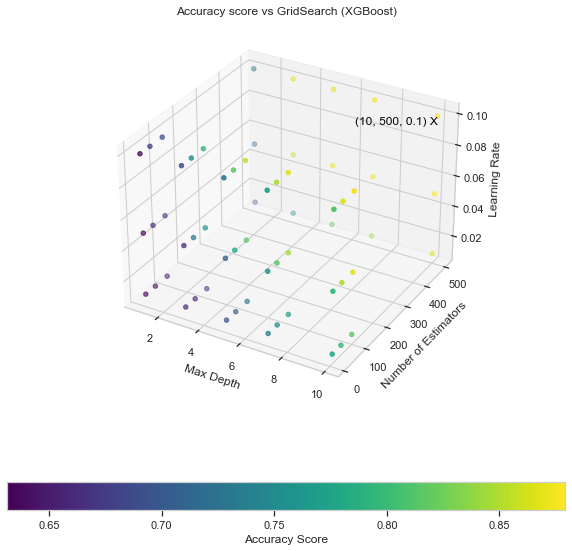

In [288]:
#Plotting parameters and accuracy scores on 4D graph 
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Accuracy score vs GridSearch (XGBoost)")
xx = mdx1
ax.set_xlabel('Max Depth')

yx = nex1
ax.set_ylabel('Number of Estimators')
zx = lrx1
ax.set_zlabel('Learning Rate')
cx = mean_sco_xg
ax.text(10, 500, 0.1, "(10, 500, 0.1) X", color='black', verticalalignment= 'top',horizontalalignment = 'right')
img = ax.scatter(xx, yx, zx, c=cx, cmap="viridis")
fig.colorbar(img, label='Accuracy Score', orientation = 'horizontal')
plt.show()

Text(0.5, 1.0, 'Accuracy Score VS Learning Rate')

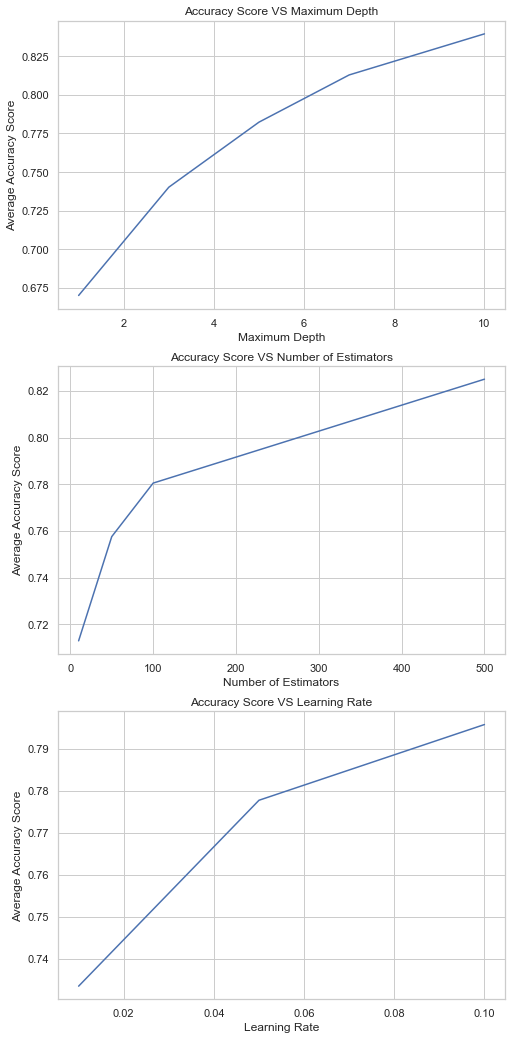

In [292]:
#Plotting average accuracy score vs each parameter 
mdx1_mean = list(GSXG.groupby(["Maximum Depth"])["Average Accuracy Score"].mean())
nex1_mean = list(GSXG.groupby(["Number of Estimators"])["Average Accuracy Score"].mean())
lrx1_mean = list(GSXG.groupby(["Learning Rate"])["Average Accuracy Score"].mean())


fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8,18))

ax1.plot(mdx, mdx1_mean)
ax1.set_xlabel("Maximum Depth")
ax1.set_ylabel('Average Accuracy Score')
ax1.set_title('Accuracy Score VS Maximum Depth')

ax2.plot(nex, nex1_mean)
ax2.set_xlabel("Number of Estimators")
ax2.set_ylabel('Average Accuracy Score')
ax2.set_title('Accuracy Score VS Number of Estimators')

ax3.plot(lrx, lrx1_mean)
ax3.set_xlabel("Learning Rate")
ax3.set_ylabel('Average Accuracy Score')
ax3.set_title('Accuracy Score VS Learning Rate')

In [168]:
# Re-run 30 times for model comparison 

# Tuned Boosting Classifier model chosen due to higher performance
DT_all_xg2= []
for i in range(30): 
    r = random.randint(0,1000)
    d = random.randint(0,1000)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=r)
    XDT = XGBClassifier(max_depth = 10, n_estimators=500, learning_rate=0.1, random_state=d)
    XDT2 = XDT.fit(X_train,y_train)
    y_pred = XDT2.predict(X_test)
    score = metrics.accuracy_score(y_test, y_pred)
    DT_all_xg2.append(score)


print(DT_all_xg2)
print(mean(DT_all_xg2))

C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:14:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0


C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:17:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1


C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:20:50] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
2


C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:23:46] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
3


C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:26:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
4


C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:29:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
5


C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:31:45] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6


C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:34:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
7


C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:37:06] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
8


C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:39:41] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
9


C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:42:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
10


C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:44:49] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
11


C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:47:21] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
12


C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:49:53] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
13


C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:52:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
14


C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:54:58] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
15


C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:57:24] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
16


C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:59:56] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
17


C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:02:29] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
18


C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:04:56] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
19


C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:07:28] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
20


C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:09:58] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
21


C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:12:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
22


C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:14:59] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
23


C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:17:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
24


C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:20:05] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
25


C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:22:38] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
26


C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:25:05] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
27


C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:27:37] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
28


C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:30:11] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
29
[0.8832124688819136, 0.8815889165494101, 0.8811018508496591, 0.8860807446693365, 0.882779521593246, 0.8796406537504059, 0.8825089295378288, 0.8775841541292347, 0.8803983115055742, 0.8859183894360861, 0.883970126637082, 0.8823465743045784, 0.8828877584154129, 0.8822383374824115, 0.8811018508496591, 0.8832665872929971, 0.8794782985171555, 0.883970126637082, 0.8826171663599957, 0.8844030739257496, 0.8825630479489123, 0.8820759822491612, 0.8843489555146661, 0.8857019157917524, 0.8813724429050763, 0.8824006927156619, 0.8831583504708301, 0.8796947721614894, 0.8788288775841542, 0.8826171663599957]
0.8823285348342172


# Model Comparison 

In [67]:
#All accuracy scores for highest performing models 
DT_all_lg = [0.5544431215499513, 0.5592055417252949, 0.5619114622794674, 0.5572031605152072, 0.5629938305011365, 0.5598549626582964, 0.5588808312587943, 0.5511960168849442, 0.5611538045242992, 0.558123173503626, 0.5614785149907998, 0.5623985279792185, 0.5612079229353826, 0.5654832774109753, 0.5612079229353826, 0.5516830825846953, 0.5660244615218097, 0.5566619764043728, 0.5568243316376231, 0.5550925424829527, 0.5591514233142115, 0.5570408052819569, 0.559097304903128, 0.5629938305011365, 0.5585561207922936, 0.5570949236930404, 0.5636432514341378, 0.560287909946964, 0.5571490421041239, 0.556337265937872]
DT_all_full2 = [0.7949994588158892, 0.7937547353609699, 0.8000324710466501, 0.7934841433055525, 0.7920770646173828, 0.793538261716636, 0.7970018400259768, 0.7937547353609699, 0.7915899989176318, 0.7984089187141465, 0.797380668903561, 0.7999242342244832, 0.8028466284229895, 0.7965688927373092, 0.7985712739473969, 0.7972183136703106, 0.8013313129126529, 0.7977594977811452, 0.7992206948803983, 0.798354800303063, 0.7915899989176318, 0.8015477865569867, 0.795702998159974, 0.7979759714254789, 0.7970559584370603, 0.7894252624742938, 0.7997618789912329, 0.7974347873146445, 0.7954324061045568, 0.8009524840350687]
DT_all_pre2 = [0.8075549301872497, 0.7947829851715553, 0.7944582747050547, 0.7957571165710575, 0.7918064725619656, 0.7961900638597251, 0.8028466284229895, 0.8004112999242342, 0.8074466933650828, 0.7930511960168849, 0.8010607208572357, 0.7938088537720532, 0.7940794458274705, 0.7966771295594761, 0.7970018400259768, 0.7949453404048057, 0.7853122632319515, 0.7864487498647039, 0.8021430890789046, 0.8058772594436627, 0.7952700508713064, 0.8070678644874987, 0.7942418010607208, 0.803496049355991, 0.8019807338456543, 0.7975971425478948, 0.8039289966446586, 0.8014395497348198, 0.8006277735685681, 0.802900746834073]
DT_all_post2 = [0.8300140707868817, 0.8274705054659596, 0.8328823465743046, 0.8284446368654617, 0.8229786773460331, 0.8385106613269835, 0.8229786773460331, 0.8184868492261067, 0.8254681242558718, 0.8269834397662085, 0.8307717285420501, 0.8315293862972183, 0.8335858859183894, 0.824764584911787, 0.8185409676371902, 0.8165927048381859, 0.8298517155536314, 0.8361835696503951, 0.828606992098712, 0.826334018833207, 0.8201104015586103, 0.826442255655374, 0.8223833748241152, 0.8228704405238663, 0.8323411624634701, 0.8214633618356965, 0.8195692174477758, 0.8282281632211278, 0.8124255871847602, 0.8306634917198831]
DT_all_bag2 = [0.9027492152830393, 0.9005844788397013, 0.9022080311722048, 0.8998268210845329, 0.8976620846411949, 0.9000432947288668, 0.9010715445394524, 0.9049139517263773, 0.8991774001515316, 0.9014503734170365, 0.8999891763177833, 0.9038315835047083, 0.898744452862864, 0.9055633726593787, 0.8996103474401992, 0.9007468340729516, 0.9007468340729516, 0.9015586102392034, 0.8990691633293646, 0.9011256629505358, 0.8999891763177833, 0.9048057149042105, 0.9025327416387054, 0.8990150449182812, 0.9027492152830393, 0.8993938737958653, 0.8984738608074467, 0.9012880181837861, 0.8979867951076956, 0.9012338997727026]
DT_all_xg2 = [0.8832124688819136, 0.8815889165494101, 0.8811018508496591, 0.8860807446693365, 0.882779521593246, 0.8796406537504059, 0.8825089295378288, 0.8775841541292347, 0.8803983115055742, 0.8859183894360861, 0.883970126637082, 0.8823465743045784, 0.8828877584154129, 0.8822383374824115, 0.8811018508496591, 0.8832665872929971, 0.8794782985171555, 0.883970126637082, 0.8826171663599957, 0.8844030739257496, 0.8825630479489123, 0.8820759822491612, 0.8843489555146661, 0.8857019157917524, 0.8813724429050763, 0.8824006927156619, 0.8831583504708301, 0.8796947721614894, 0.8788288775841542, 0.8826171663599957]
RF_all2 = [0.8580474077281091, 0.8616192228596169, 0.8611321571598658, 0.8589674207165278, 0.858642710250027, 0.8566944474510229, 0.8599415521160299, 0.8638921961251218, 0.858155644550276, 0.8608615651044486, 0.8643792618248728, 0.8596168416495291, 0.8583179997835264, 0.8679510769563805, 0.8585344734278602, 0.8668145903236281, 0.8557203160515208, 0.8616192228596169, 0.860428617815781, 0.8638380777140383, 0.8621062885593679, 0.8645957354692066, 0.866435761446044, 0.8588591838943609, 0.8611321571598658, 0.8668687087347116, 0.8628098279034527, 0.8572356315618573, 0.8617274596817838, 0.8588591838943609]

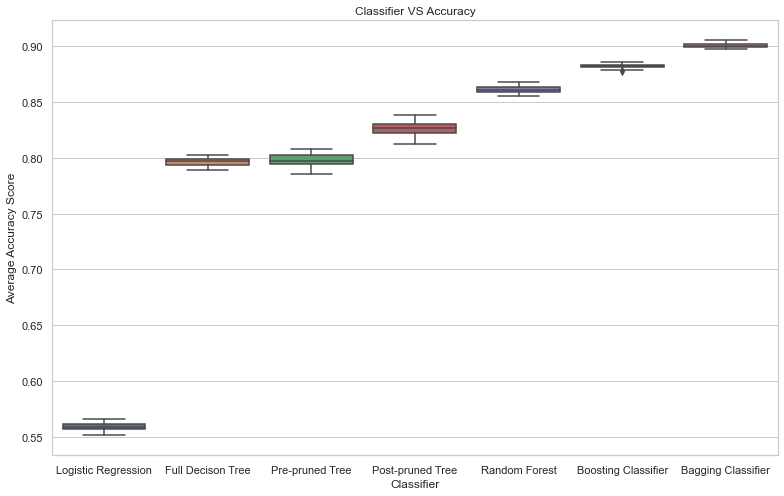

In [131]:
#Storing accuracy scores in dictionary 
model_comp2 = {'Logistic Regression':DT_all_lg,'Full Decison Tree':DT_all_full2, 'Pre-pruned Tree': DT_all_pre2, 'Post-pruned Tree': DT_all_post2, 
             'Bagging Classifier':DT_all_bag2, 'Boosting Classifier': DT_all_xg2, 'Random Forest': RF_all2 }

#Plotting results in Boxplot 
models3, values3 = zip(*sorted(model_comp2.items(), key=op.itemgetter(1)))

fig = plt.figure(figsize = (13,8))
ax = fig.add_subplot(111)

sns.set(context='notebook', style='whitegrid', rc = {'figure.figsize':(17,10)})
sns.boxplot(data=values3)
plt.title('Classifier VS Accuracy')
plt.xlabel("Classifier")
plt.ylabel('Average Accuracy Score')

plt.xticks(plt.xticks()[0], models3)

plt.show()

# Out of sample test


In [135]:
# Splitting training data (1993-2015) and test data (2016)
df_old = df[df['FYEAR'] != 2016]
df_new = df[df['FYEAR'] == 2016]

X_old = df_old.loc[:, df_old.columns != 'CRASH']
y_old = df_old['CRASH']
X_new = df_new.loc[:, df_new.columns != 'CRASH']
y_new = df_new['CRASH']

In [136]:
#SMOTENN training data
smt = SMOTEENN(random_state=42)
X_old, y_old = smt.fit_resample(X_old, y_old)

In [137]:
#SMOTENN test data 
smt = SMOTEENN(random_state=42)
X_new, y_new = smt.fit_resample(X_new, y_new)

In [454]:
#Full Decision Tree out-of-sample test 
ost_full1 = []
ost_full2 = []
ost_full3 = []
ost_full4 = []
ost_full5 = []


for i in range(30): 
    d = random.randint(0,1000)
    DT = DecisionTreeClassifier(criterion="entropy", random_state = d)
    DT2 = DT.fit(X_old,y_old)
    y_pred = DT2.predict(X_new)
    score_prec = metrics.precision_score(y_new, y_pred)
    ost_full1.append(score_prec)
    score_acc = metrics.accuracy_score(y_new, y_pred)
    ost_full2.append(score_acc)
    score_rec = metrics.recall_score(y_new, y_pred)
    ost_full3.append(score_rec)
    score_roc = metrics.roc_auc_score(y_new, y_pred)
    ost_full4.append(score_roc)
    score_f1 = metrics.f1_score(y_new, y_pred)
    ost_full5.append(score_f1)


print('Best Accuracy:', max(ost_full2))
print('AVG Accuracy:', mean(ost_full2))
print('AVG Precision:', mean(ost_full1))
print('AVG Recall:', mean(ost_full3))
print('AVG F1:', mean(ost_full5))
print('AVG AUC:', mean(ost_full4))

Best Accuracy: 0.5577889447236181
AVG Accuracy: 0.5281407035175879
AVG Precision: 0.5579693474588197
AVG Recall: 0.6651376146788991
AVG F1: 0.6067383522677471
AVG AUC: 0.5136799184505607


In [455]:
#Pre-pruned decision tree out-of-sample test 

ost_full1 = []
ost_full2 = []
ost_full3 = []
ost_full4 = []
ost_full5 = []


for i in range(30): 
    d = random.randint(0,1000)
    DT = DecisionTreeClassifier(random_state=d, max_depth = 20, min_samples_leaf = 2, min_samples_split = 2, criterion="entropy")
    DT2 = DT.fit(X_old,y_old)
    y_pred = DT2.predict(X_new)
    score_prec = metrics.precision_score(y_new, y_pred)
    ost_full1.append(score_prec)
    score_acc = metrics.accuracy_score(y_new, y_pred)
    ost_full2.append(score_acc)
    score_rec = metrics.recall_score(y_new, y_pred)
    ost_full3.append(score_rec)
    score_roc = metrics.roc_auc_score(y_new, y_pred)
    ost_full4.append(score_roc)
    score_f1 = metrics.f1_score(y_new, y_pred)
    ost_full5.append(score_f1)


print('Best Accuracy:', max(ost_full2))
print('AVG Accuracy:', mean(ost_full2))
print('AVG Precision:', mean(ost_full1))
print('AVG Recall:', mean(ost_full3))
print('AVG F1:', mean(ost_full5))
print('AVG AUC:', mean(ost_full4))

Best Accuracy: 0.5628140703517588
AVG Accuracy: 0.5296482412060302
AVG Precision: 0.5609868607164756
AVG Recall: 0.6495412844036698
AVG F1: 0.6019703804659279
AVG AUC: 0.5169928644240571


In [451]:
#Post-pruned Out-of-sample test 
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_old, y_old, test_size=0.2, random_state=9)

DT = DecisionTreeClassifier(random_state = 2)
DT.fit(X_train1,y_train1)

path = DT.cost_complexity_pruning_path(X_train1, y_train1)
ccp_alphas = path.ccp_alphas

ccp_alphas = ccp_alphas[0::100]

DTs = []
for ccp_alpha in ccp_alphas:
    DT = DecisionTreeClassifier(random_state=2, ccp_alpha=ccp_alpha)
    DT.fit(X_train1, y_train1)
    DTs.append(DT)

DTs = DTs[:-1]
ccp_alphas = ccp_alphas[:-1]

test_scores = [accuracy_score(y_test1, DT.predict(X_test1)) for DT in DTs]

maxT = max(test_scores)
maxT_index = test_scores.index(maxT)
maxT_ccp_gini = ccp_alphas[maxT_index]


ost_full1 = []
ost_full2 = []
ost_full3 = []
ost_full4 = []
ost_full5 = []


for i in range(30): 
    d = random.randint(0,1000)
    DT = DecisionTreeClassifier(random_state=d, ccp_alpha = maxT_ccp_gini)
    DT2 = DT.fit(X_old,y_old)
    y_pred = DT2.predict(X_new)
    score_prec = metrics.precision_score(y_new, y_pred)
    ost_full1.append(score_prec)
    score_acc = metrics.accuracy_score(y_new, y_pred)
    ost_full2.append(score_acc)
    score_rec = metrics.recall_score(y_new, y_pred)
    ost_full3.append(score_rec)
    score_roc = metrics.roc_auc_score(y_new, y_pred)
    ost_full4.append(score_roc)
    score_f1 = metrics.f1_score(y_new, y_pred)
    ost_full5.append(score_f1)


print('Best Accuracy:', max(ost_full2))
print('AVG Accuracy:', mean(ost_full2))
print('AVG Precision:', mean(ost_full1))
print('AVG Recall:', mean(ost_full3))
print('AVG F1:', mean(ost_full5))
print('AVG AUC:', mean(ost_full4))

Best Accuracy: 0.5477386934673367
AVG Accuracy: 0.5395309882747069
AVG Precision: 0.5712370337270465
AVG Recall: 0.6388379204892967
AVG F1: 0.603138841613112
AVG AUC: 0.5290485898742779


In [450]:
#Random Forest (tuned) out-of-sample test 
ost_full1 = []
ost_full2 = []
ost_full3 = []
ost_full4 = []
ost_full5 = []


for i in range(30): 
    d = random.randint(0,1000)
    RF = RandomForestClassifier(random_state= d, max_features = 6, min_samples_leaf = 1, n_estimators = 100)
    RF2 = RF.fit(X_old,y_old)
    y_pred = RF2.predict(X_new)
    score_prec = metrics.precision_score(y_new, y_pred)
    ost_full1.append(score_prec)
    score_acc = metrics.accuracy_score(y_new, y_pred)
    ost_full2.append(score_acc)
    score_rec = metrics.recall_score(y_new, y_pred)
    ost_full3.append(score_rec)
    score_roc = metrics.roc_auc_score(y_new, y_pred)
    ost_full4.append(score_roc)
    score_f1 = metrics.f1_score(y_new, y_pred)
    ost_full5.append(score_f1)


print('Best Accuracy:', max(ost_full2))
print('AVG Accuracy:', mean(ost_full2))
print('AVG Precision:', mean(ost_full1))
print('AVG Recall:', mean(ost_full3))
print('AVG F1:', mean(ost_full5))
print('AVG AUC:', mean(ost_full4))

Best Accuracy: 0.6633165829145728
AVG Accuracy: 0.6159128978224455
AVG Precision: 0.6837920874114544
AVG Recall: 0.55565749235474
AVG F1: 0.6126542027766674
AVG AUC: 0.6222731906218145


In [147]:
#Bagging (tuned) out-of-sample test 
ost_full1 = []
ost_full2 = []
ost_full3 = []
ost_full4 = []
ost_full5 = []


for i in range(30): 
    d = random.randint(0,1000)
    BDT = BaggingClassifier(n_estimators = 500, max_features = 5, random_state = d)
    BDT2 = BDT.fit(X_old,y_old)
    y_pred = BDT2.predict(X_new)
    score_prec = metrics.precision_score(y_new, y_pred)
    ost_full1.append(score_prec)
    score_acc = metrics.accuracy_score(y_new, y_pred)
    ost_full2.append(score_acc)
    score_rec = metrics.recall_score(y_new, y_pred)
    ost_full3.append(score_rec)
    score_roc = metrics.roc_auc_score(y_new, y_pred)
    ost_full4.append(score_roc)
    score_f1 = metrics.f1_score(y_new, y_pred)
    ost_full5.append(score_f1)


print('Best Accuracy:', max(ost_full2))
print('AVG Accuracy:', mean(ost_full2))
print('AVG Precision:', mean(ost_full1))
print('AVG Recall:', mean(ost_full3))
print('AVG F1:', mean(ost_full5))
print('AVG AUC:', mean(ost_full4))

Best Accuracy: 0.6482412060301508
AVG Accuracy: 0.6351758793969849
AVG Precision: 0.6043495930517063
AVG Recall: 0.9672782874617737
AVG F1: 0.7438795396732688
AVG AUC: 0.6001206252123683


In [448]:
#Boosting (tuned) out-of-sample test 

ost_full1 = []
ost_full2 = []
ost_full3 = []
ost_full4 = []
ost_full5 = []


for i in range(30): 
    d = random.randint(0,1000)
    XDT = XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=500, random_state = d)
    XDT2 = XDT.fit(X_old,y_old)
    y_pred = XDT2.predict(X_new)
    score_prec = metrics.precision_score(y_new, y_pred)
    ost_full1.append(score_prec)
    score_acc = metrics.accuracy_score(y_new, y_pred)
    ost_full2.append(score_acc)
    score_rec = metrics.recall_score(y_new, y_pred)
    ost_full3.append(score_rec)
    score_roc = metrics.roc_auc_score(y_new, y_pred)
    ost_full4.append(score_roc)
    score_f1 = metrics.f1_score(y_new, y_pred)
    ost_full5.append(score_f1)



print('Best Accuracy:', max(ost_full2))
print('AVG Accuracy:', mean(ost_full2))
print('AVG Precision:', mean(ost_full1))
print('AVG Recall:', mean(ost_full3))
print('AVG F1:', mean(ost_full5))
print('AVG AUC:', mean(ost_full4))

Best Accuracy: 0.6532663316582915
AVG Accuracy: 0.6532663316582915
AVG Precision: 0.6162790697674418
AVG Recall: 0.9724770642201835
AVG F1: 0.7544483985765125
AVG AUC: 0.6195718654434251


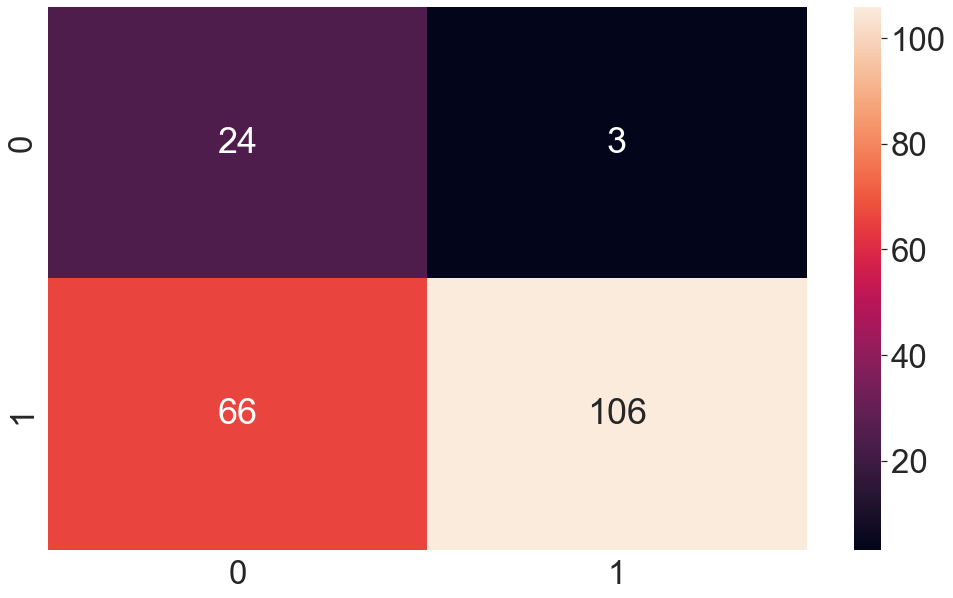

              precision    recall  f1-score   support

           0       0.27      0.89      0.41        27
           1       0.97      0.62      0.75       172

    accuracy                           0.65       199
   macro avg       0.62      0.75      0.58       199
weighted avg       0.88      0.65      0.71       199



In [469]:
#Boosting Classifier Confusion Matrix 
XDT = XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=500, random_state=43)
XDT2 = XDT.fit(X_old,y_old)
y_pred = XDT2.predict(X_new)
sns.set(font_scale=3)
cm = confusion_matrix(y_pred, y_new)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()

print(classification_report(y_pred, y_new))

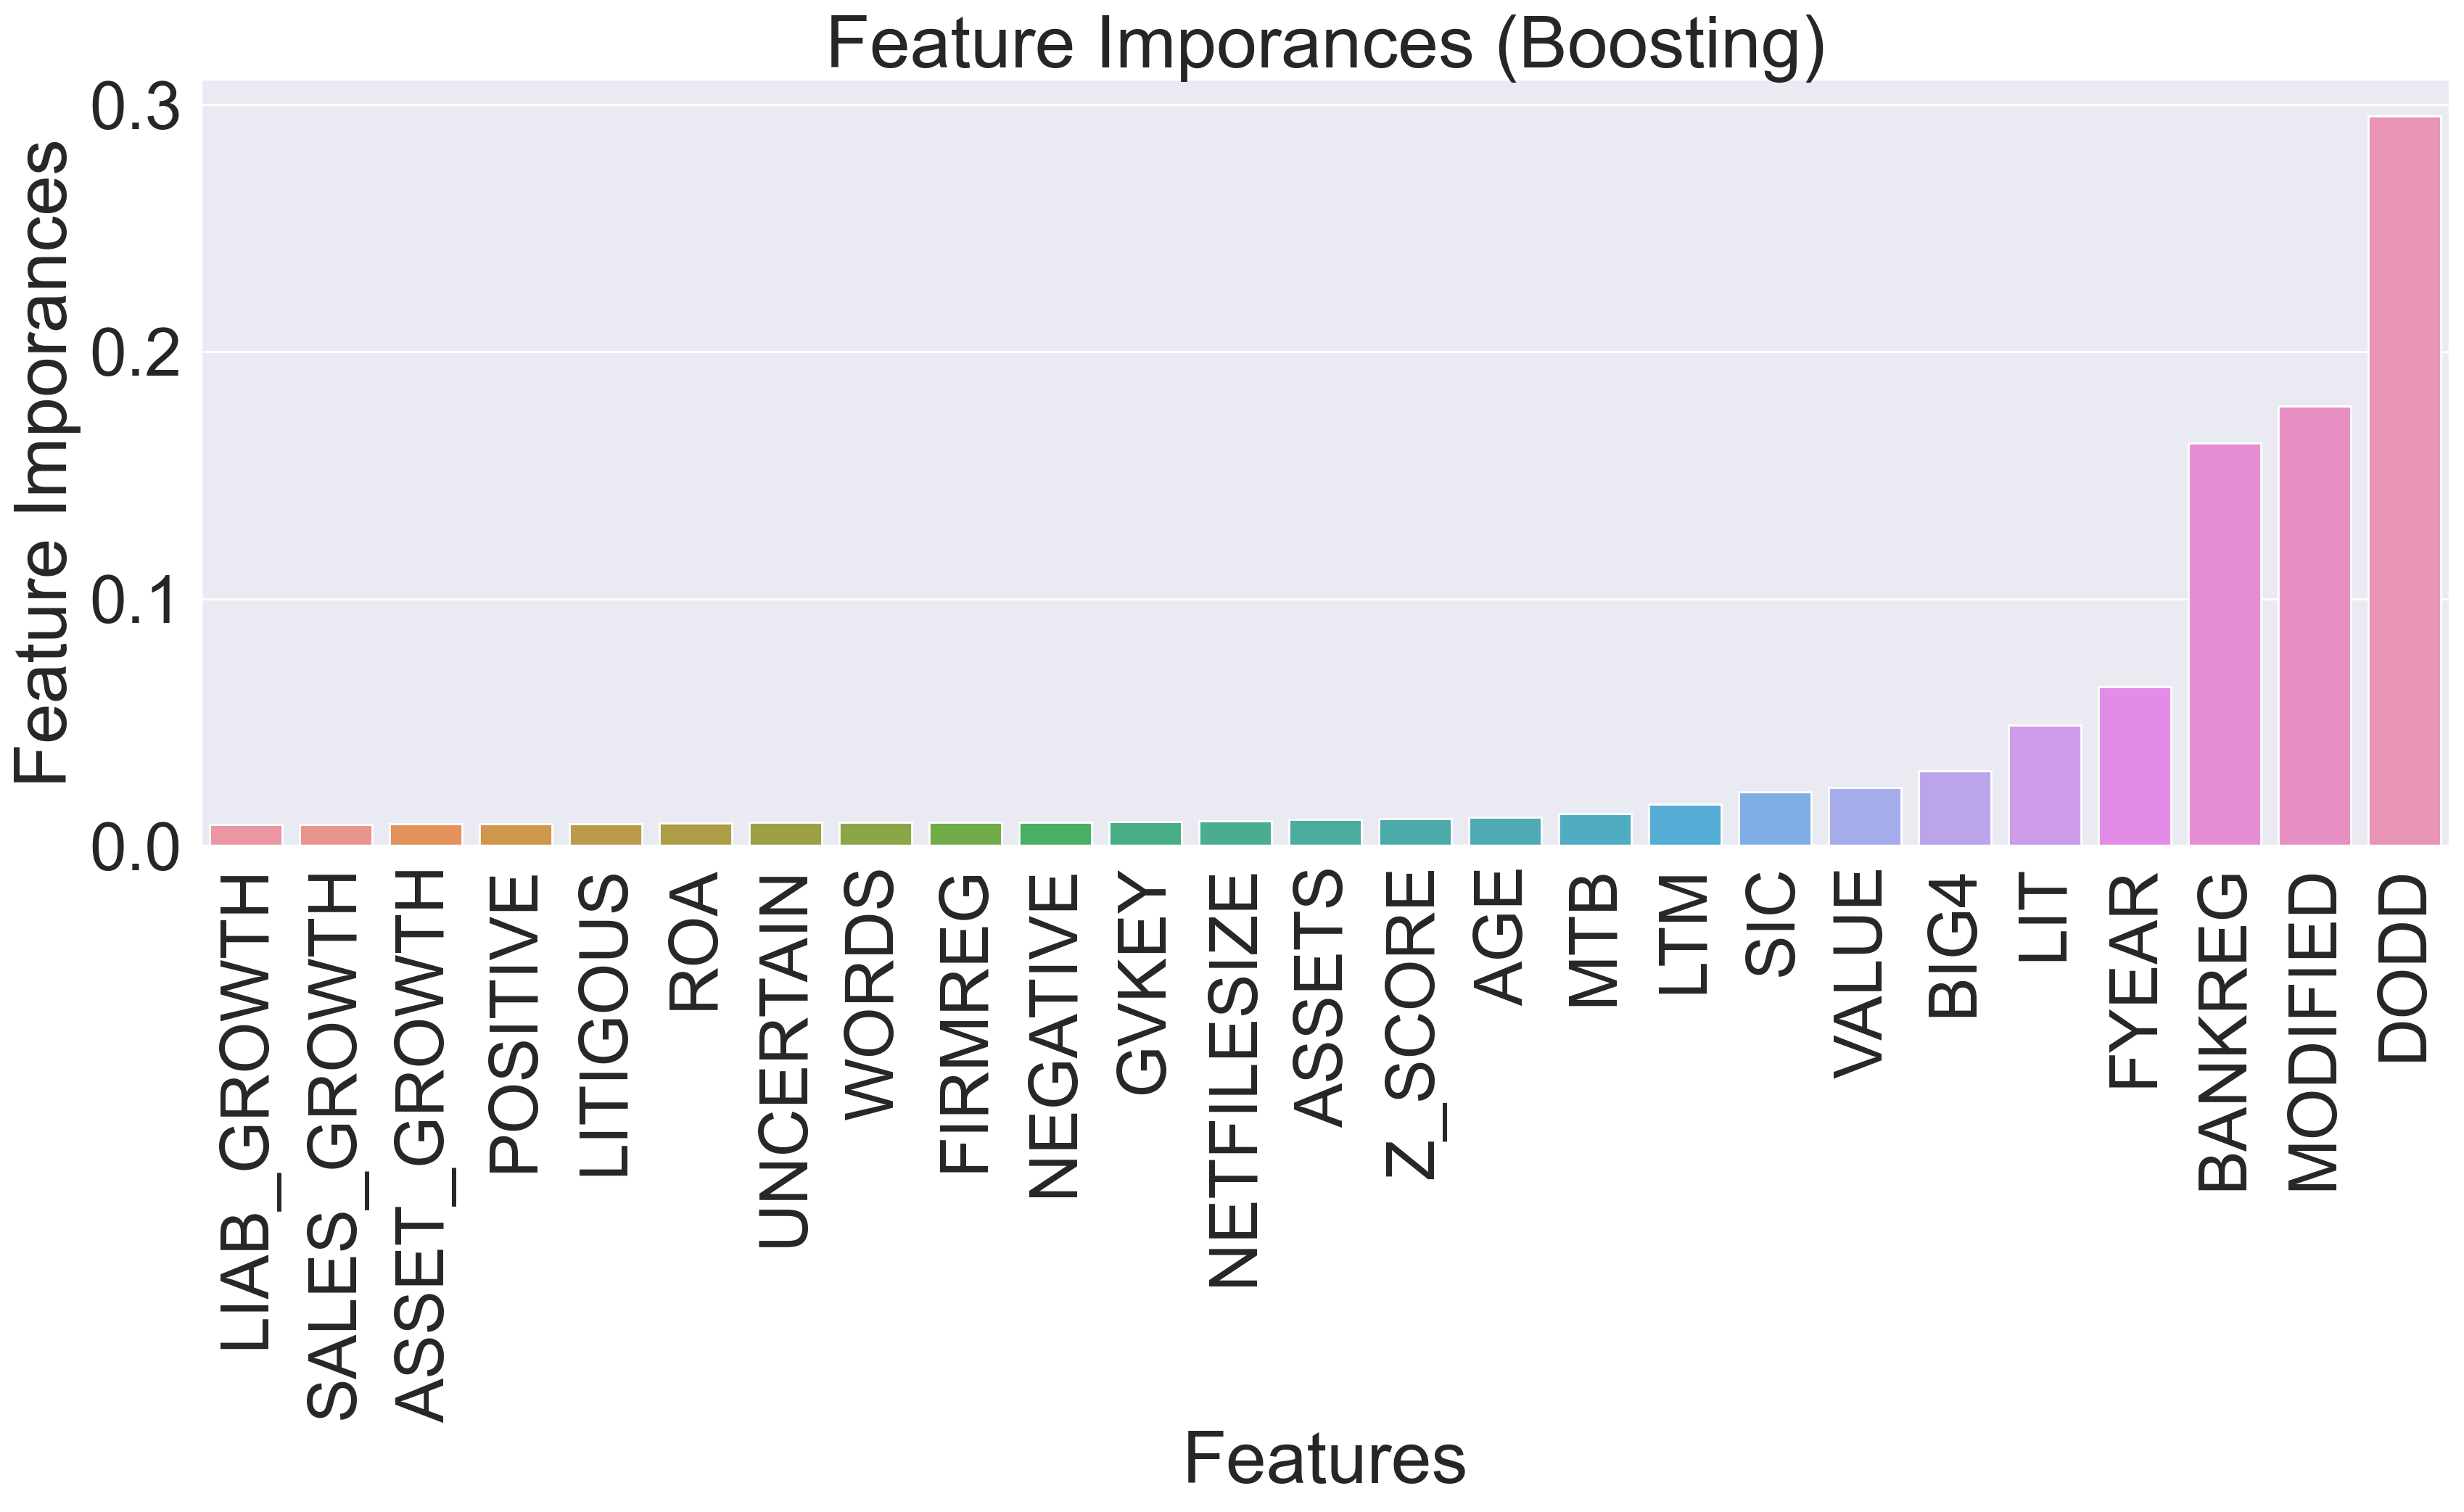

In [484]:
#Feature importance for Boosting Classifier 
XDT = XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=500, random_state=43)
XDTree = XDT.fit(X_train,y_train)
feature_importancesXDT =pd.DataFrame({"Features":X.columns,
              "Feature Imporances": XDT.feature_importances_}).sort_values(by="Feature Imporances")

feature_importancesXDT.head()

plt.figure(figsize=(20,7),dpi=200)

sns.barplot(data=feature_importancesXDT,x="Features",y="Feature Imporances")
plt.title("Feature Imporances (Boosting)")
plt.xticks(rotation=90)
plt.show()

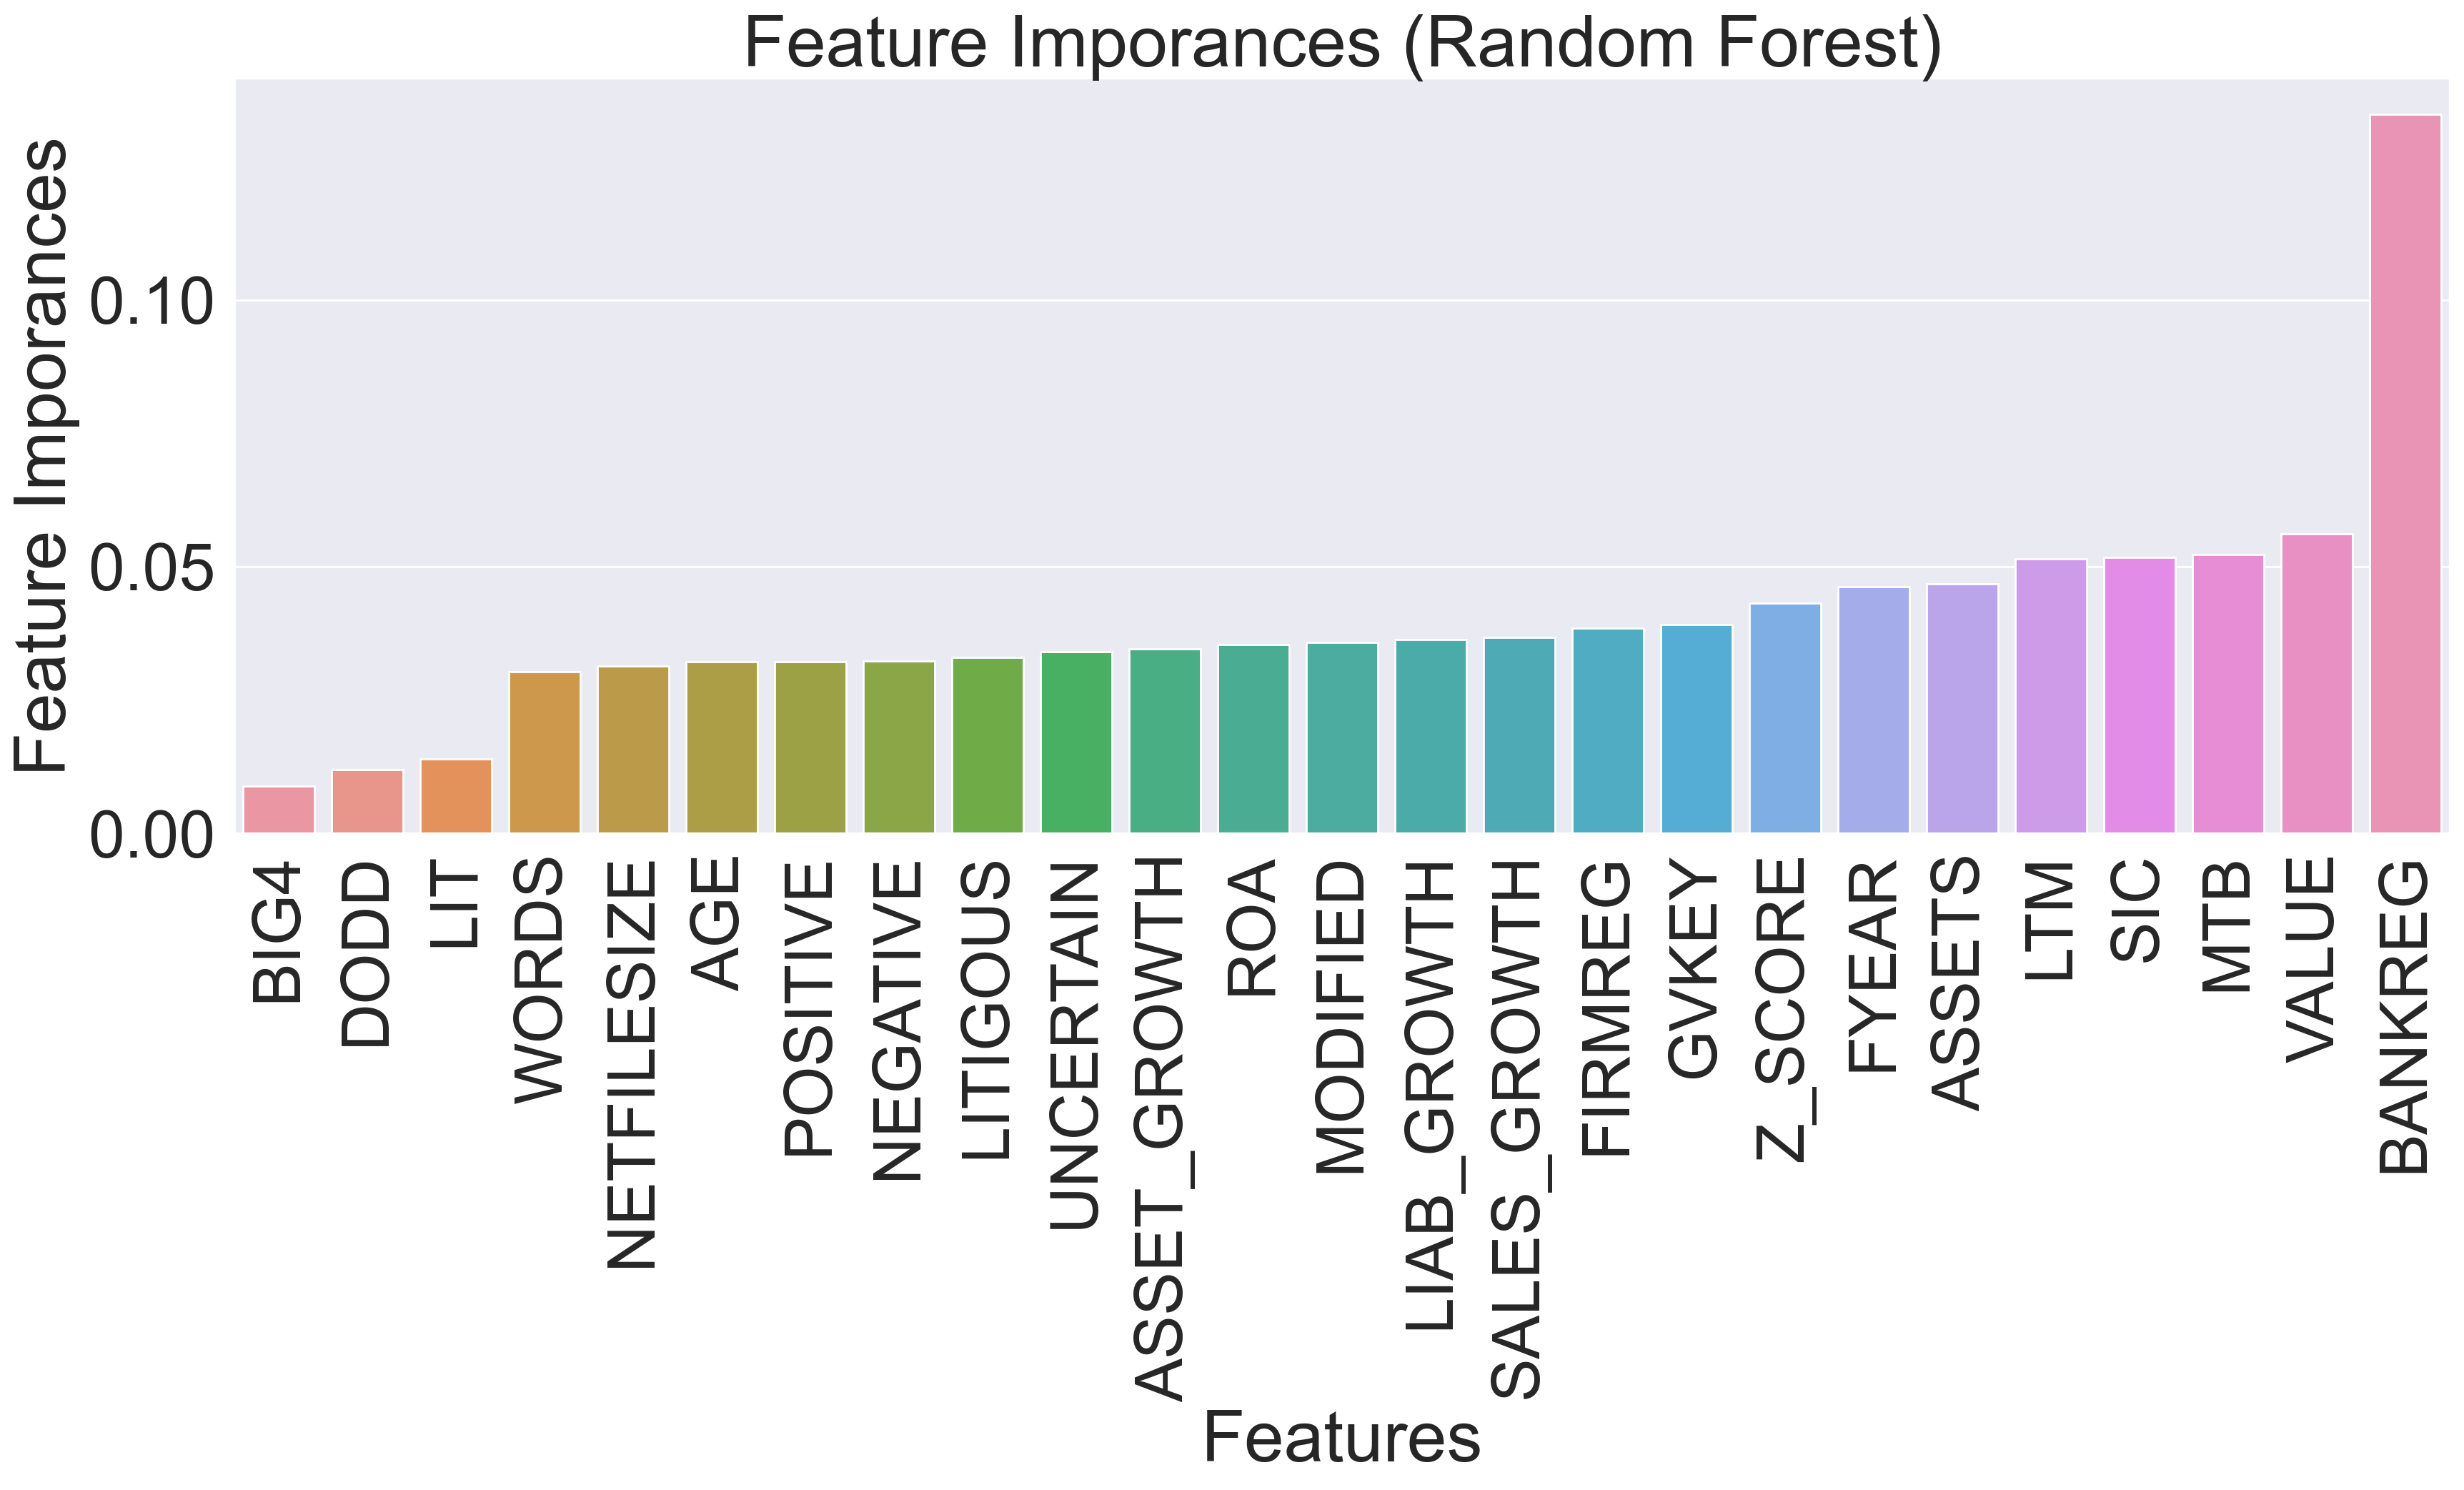

In [480]:
#Feature importance for random forest classifier 
RF = RandomForestClassifier(random_state= d, max_features = 6, min_samples_leaf = 1, n_estimators = 100)
RFTree = RF.fit(X_train,y_train)
feature_importancesRF =pd.DataFrame({"Features":X.columns,
              "Feature Imporances": RF.feature_importances_}).sort_values(by="Feature Imporances")

feature_importancesRF.head()
plt.figure(figsize=(20,7),dpi=200)
sns.barplot(data=feature_importancesRF,x="Features",y="Feature Imporances")
plt.title("Feature Imporances (Random Forest)")
plt.xticks(rotation=90)
plt.show()

# Regulation Importance (T-test)

In [38]:
#Includes only BANKREG 
X_reg = X.loc[:, X.columns != 'DODD']
X_reg = X_reg.loc[:, X_reg.columns != 'FIRMREG']

#Includes only DODD 
X_dodd = X.loc[:, X.columns != 'BANKREG']
X_dodd = X_dodd.loc[:, X_dodd.columns != 'FIRMREG']

#Included only FIRMREG 
X_firm = X.loc[:, X.columns != 'BANKREG']
X_firm = X_firm.loc[:, X_firm.columns != 'DODD']

#Does not inlcude any of the indicators 
X_none = X.loc[:, X.columns != 'DODD']
X_none = X_none.loc[:, X_none.columns != 'BANKREG']
X_none = X_none.loc[:, X_none.columns != 'FIRMREG']

## BANKREG INDEX

### Full Decision Tree (BANKREG)

In [3]:
#Full Decision Tree (Gini)
X_train, X_test, y_train, y_test = train_test_split(X_reg, y, test_size=0.2, random_state=0)

DT2 = DecisionTreeClassifier(random_state=109)

# Training Decision Tree Classifer
DTree2 = DT2.fit(X_train,y_train)

#Predict the response for test dataset
y_pred2 = DTree2.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred2))

Accuracy:  0.7904535122848794


In [4]:
#5-fold CV for full decision tree (Gini)
DT = DecisionTreeClassifier(random_state=109)
cv = KFold(n_splits=5, random_state=2, shuffle=True)
scores_acc = cross_val_score(DT, X_reg, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

Accuracy:  0.786 (0.003)


In [5]:
#Full Decision Tree (Entropy)
DT = DecisionTreeClassifier(random_state = 9, criterion="entropy")
# Training Decision Tree Classifer
DTree = DT.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = DTree.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.7919688277952159


In [6]:
#5-fold CV for full decision tree (Entropy)
DT = DecisionTreeClassifier(random_state=109, criterion="entropy")
cv = KFold(n_splits=5, random_state=2, shuffle=True)
scores_acc = cross_val_score(DT, X_reg, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

Accuracy:  0.793 (0.002)


In [8]:
# Re-run 30 times for t-test

# Entropy model chosen due to higher performance
DT_reg_full= []
for i in range(30): 
    r = random.randint(0,1000)
    d = random.randint(0,1000)
    DT = DecisionTreeClassifier(random_state=d, criterion='entropy')
    cv = KFold(n_splits=5, random_state=r, shuffle=True)
    scores = cross_val_score(DT, X_reg, y, scoring='accuracy', cv=cv, n_jobs=-1)
    scores = mean(scores)
    DT_reg_full.append(scores)

print(DT_reg_full)
print(mean(DT_reg_full))

[0.7916224699642818, 0.7920229462062993, 0.7927806039614678, 0.7919038857019158, 0.7932784933434355, 0.7906916332936464, 0.7921203593462496, 0.7923043619439334, 0.7928780171014178, 0.7928780171014178, 0.7930403723346682, 0.7917631778330988, 0.7921095356640329, 0.7926182487282173, 0.7940577984630371, 0.7924775408594005, 0.793321788072302, 0.792423422448317, 0.7901937439116787, 0.7910055200779305, 0.792142006710683, 0.793505790669986, 0.7931053144279685, 0.7927806039614678, 0.7922610672150665, 0.7914601147310314, 0.7910596384890141, 0.791200346357831, 0.792033769888516, 0.7915034094598983]
0.792218133275607


### Pre-Pruning (BANKREG)

In [9]:
#Pre-pruning using GridSearch CV (Gini)
param_grid = {
    "max_depth": [3,5,10,15,20],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

DT = DecisionTreeClassifier(random_state=2)
grid_cv_pre_regindex = GridSearchCV(DT, param_grid, scoring="accuracy", n_jobs=-1, cv=5).fit(X_train, y_train)

print("Param for GS", grid_cv_pre_regindex.best_params_)
print("CV score for GS", grid_cv_pre_regindex.best_score_)

Param for GS {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}
CV score for GS 0.7926588757488217


In [10]:
#5-fold cross-validation pre-pruned tree (Gini)
DT = DecisionTreeClassifier(random_state=20, max_depth = 20, min_samples_leaf = 2, min_samples_split = 2)
cv = KFold(n_splits=5, random_state=2, shuffle=True)
scores_acc = cross_val_score(DT, X_reg, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

Accuracy: 0.793 (0.003)


In [11]:
#Pre-pruning using GridSearch CV (Entropy)
param_grid = {
    "max_depth": [3,5,10,15,20],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

DT = DecisionTreeClassifier(random_state=2, criterion = 'entropy')
grid_cv = GridSearchCV(DT, param_grid, scoring="accuracy", n_jobs=-1, cv=5).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)

Param for GS {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}
CV score for GS 0.7889246638281402


In [12]:
#5-fold cross-validation pre-pruned tree (Entropy)
DT = DecisionTreeClassifier(random_state= 90, max_depth = 20, min_samples_leaf = 2, min_samples_split = 2, criterion = 'entropy')
cv = KFold(n_splits=5, random_state=2, shuffle=True)
scores_acc = cross_val_score(DT, X_reg, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

Accuracy: 0.791 (0.002)


In [13]:
# Re-run 30 times for t-test

# Gini model chosen due to higher performance
DT_reg_pre = []
for i in range(30): 
    r = random.randint(0,1000)
    d = random.randint(0,1000)
    DT = DecisionTreeClassifier(random_state=20, max_depth = 20, min_samples_leaf = 2, min_samples_split = 2)
    cv = KFold(n_splits=5, random_state=r, shuffle=True)
    scores = cross_val_score(DT, X_reg, y, scoring='accuracy', cv=cv, n_jobs=-1)
    scores = mean(scores)
    DT_reg_pre.append(scores)

print(DT_reg_pre)
print(mean(DT_reg_pre))

[0.798354800303063, 0.7996103474401991, 0.7944690983872714, 0.7949994588158892, 0.8000324710466501, 0.7937980300898365, 0.7937547353609699, 0.8022296785366381, 0.7974672583612945, 0.7995887000757658, 0.7977919688277952, 0.8006277735685681, 0.7990042212360644, 0.7982682108453296, 0.8, 0.7973157268102609, 0.8000974131399502, 0.799686113215716, 0.8041671176534259, 0.8007576577551683, 0.7958004112999242, 0.7971966663058773, 0.7919038857019157, 0.8010715445394523, 0.8007576577551683, 0.7981816213875961, 0.7973265504924776, 0.8010715445394524, 0.7985712739473969, 0.7977053793700617]
0.7983869105603059


### Post-pruning (BANKREG)

In [14]:
#Post-pruned decision tree (Gini)
DT = DecisionTreeClassifier(random_state = 2)
DT.fit(X_train,y_train)

path = DT.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

ccp_alphas = ccp_alphas[0::100]

DTs = []
for ccp_alpha in ccp_alphas:
    DT = DecisionTreeClassifier(random_state=2, ccp_alpha=ccp_alpha)
    DT.fit(X_train, y_train)
    DTs.append(DT)

DTs = DTs[:-1]
ccp_alphas = ccp_alphas[:-1]

test_scores = [accuracy_score(y_test, DT.predict(X_test)) for DT in DTs]

#Finding maximum test accuracy and corresponding ccp_alpha (Gini)
maxT = max(test_scores)
maxT_index = test_scores.index(maxT)
maxT_ccp_gini = ccp_alphas[maxT_index]

# 5-fold CV for post-pruned Decision tree (Gini)
DT = DecisionTreeClassifier(random_state=2, ccp_alpha = maxT_ccp_gini)
cv = KFold(n_splits=5, random_state=2, shuffle=True)
scores_acc = cross_val_score(DT, X_reg, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

Accuracy: 0.821 (0.006)


In [15]:
#Post-pruned decision tree (Entropy)
DT = DecisionTreeClassifier(random_state = 61, criterion = 'entropy')
DT.fit(X_train,y_train)

path = DT.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

ccp_alphas = ccp_alphas[0::100]

DTs = []
for ccp_alpha in ccp_alphas:
    DT = DecisionTreeClassifier(random_state=2, ccp_alpha=ccp_alpha)
    DT.fit(X_train, y_train)
    DTs.append(DT)

DTs = DTs[:-1]
ccp_alphas = ccp_alphas[:-1]

test_scores = [accuracy_score(y_test, DT.predict(X_test)) for DT in DTs]

#Finding maximum test accuracy and corresponding ccp_alpha (Gini)
maxT = max(test_scores)
maxT_index = test_scores.index(maxT)
maxT_ccp_entropy = ccp_alphas[maxT_index]

# 5-fold CV for post-pruned Decision tree (Gini)
DT = DecisionTreeClassifier(random_state=2, ccp_alpha = maxT_ccp_entropy)
cv = KFold(n_splits=5, random_state=2, shuffle=True)
scores_acc = cross_val_score(DT, X_reg, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

Accuracy: 0.821 (0.005)


In [16]:
#Re-run 30 times for t-test (Entropy chosen due to lower SD)
DT_reg_post = []
for i in range(30): 
    r = random.randint(0,1000)
    d = random.randint(0,1000)
    DT = DecisionTreeClassifier(random_state=d, ccp_alpha = maxT_ccp_entropy)
    cv = KFold(n_splits=5, random_state=r, shuffle=True)
    scores = cross_val_score(DT, X_reg, y, scoring='accuracy', cv=cv, n_jobs=-1)
    scores = mean(scores)
    DT_reg_post.append(scores)
print(DT_reg_post)
print(mean(DT_reg_post))

[0.8236822166901179, 0.8196558069055093, 0.8204567593895444, 0.8215932460222968, 0.8221344301331314, 0.818194609806256, 0.822740556337266, 0.8200779305119601, 0.8205974672583611, 0.8192769780279251, 0.8207706461738283, 0.8211602987336292, 0.8236930403723347, 0.8212144171447127, 0.8193310964390086, 0.8176426020132048, 0.8244939928563696, 0.8241476350254355, 0.8229570299815997, 0.8248728217339538, 0.8174910704621713, 0.8209654724537288, 0.8220261933109644, 0.8203052278385107, 0.8175560125554714, 0.8168091784825198, 0.8205974672583614, 0.818789912328174, 0.8213443013313129, 0.8224266695529818]
0.8209001695710214


### Bagging (BANKREG)

In [323]:
# Bagging classifier (untuned)
BDT = BaggingClassifier()
cv = KFold(n_splits=5, n_repeats=3, random_state=8) 
scores_acc = cross_val_score(BDT, X_reg, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

Accuracy: 0.855 (0.003)


In [324]:
# Parameter tuning using GridSearchCV 
BDT = BaggingClassifier()
param_grid = {
    "n_estimators": [10, 50, 100, 500],
     "max_features": [1, 2, 5, 10, 13]
}

cv = KFold(n_splits=5, random_state=2, shuffle=True)
grid_cv_bag_regindex= GridSearchCV(BDT, param_grid, scoring="accuracy", n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv_bag_regindex.best_params_)
print("CV score for GS", grid_cv_bag_regindex.best_score_)

Param for GS {'max_features': 5, 'n_estimators': 500}
CV score for GS 0.8951591962424192


In [42]:
#5-fold CV for tuned Bagging CLassifier 
BDT = BaggingClassifier(max_features = 5, n_estimators = 500)
cv = KFold(n_splits=5, random_state=3, shuffle=True)
scores_roc = cross_val_score(BDT, X_reg, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(BDT, X_reg, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

AUC_ROC Score: 0.912 (0.002)
Accuracy: 0.866 (0.003)


In [30]:
#Re-run 30 times for t-test 

#Tuned Bagging Classifier chosen due to higher performance
DT_reg_bag = []
for i in range(30): 
    r = random.randint(0,1000)
    d = random.randint(0,1000)
    BDT = BaggingClassifier(max_features = 5, n_estimators = 500, random_state=d)
    cv = KFold(n_splits=5, random_state=r, shuffle=True)
    scores = cross_val_score(BDT, X_reg, y, scoring='accuracy', cv=cv, n_jobs=-1)
    scores = mean(scores)
    DT_reg_bag.append(scores)

print(DT_reg_bag)
print(mean(DT_reg_bag))

[0.9000324710466501, 0.9022946206299384, 0.9030089836562398, 0.9010715445394524, 0.9016235523325035, 0.9030847494317567, 0.9031496915250568, 0.9006710682974347, 0.9037774650936248, 0.9017209654724537, 0.9024677995454053, 0.9015586102392034, 0.9009849550817188, 0.9030847494317567, 0.9029548652451563, 0.9017859075657538, 0.9020023812100877, 0.9014395497348199, 0.9021106180322545, 0.9015477865569868, 0.9028790994696395, 0.9022405022188549, 0.902900746834073, 0.902024028574521, 0.9037666414114082, 0.9021430890789046, 0.9029115705162896, 0.9014936681459031, 0.9022296785366383, 0.901850849659054]
0.9021604069704515


### Random Forest (BANKREG)

In [ ]:
#5-fold CV for Random Forest 
RF = RandomForestClassifier(random_state= 1)
cv = KFold(n_splits=5, random_state=2, shuffle=True)
scores_roc = cross_val_score(RF, X_reg, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(RF, X_reg, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))

In [31]:
#Paramter tuning for Random Forest
param_grid = {
    "min_samples_leaf": [1, 3, 4], 
    "n_estimators" : [10, 20, 50, 100], 
    "max_features" : [3,4,5, 6]   
}

RF = RandomForestClassifier(random_state= 49)
grid_cv_rf_bankindex = GridSearchCV(RF, param_grid, scoring="accuracy", n_jobs=-1, cv=5).fit(X_train, y_train)

print("Param for GS", grid_cv_rf_bankindex.best_params_)
print("CV score for GS", grid_cv_rf_bankindex.best_score_)

Param for GS {'max_features': 6, 'min_samples_leaf': 1, 'n_estimators': 100}
CV score for GS 0.8482113253921089


In [ ]:
#5-fold CV for tuned Random Forest 
RF = RandomForestClassifier(max_features = 6, min_samples_leaf = 1, n_estimators = 100 )
cv = KFold(n_splits=5, random_state=3, shuffle=True)
scores_roc = cross_val_score(RF, X_reg, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(RF, X_reg, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))

In [32]:
#Re-run model 30 times for t-test 
RF_bankreg = []
for i in range(30):
    r = random.randint(0,1000)
    d = random.randint(0,1000)
    RF = RandomForestClassifier(random_state= d, max_features = 6, min_samples_leaf = 1, n_estimators = 100 )
    cv = KFold(n_splits=5, random_state=r, shuffle=True)
    scores = cross_val_score(RF, X_reg, y, scoring='accuracy', cv=cv, n_jobs=-1)
    scores = mean(scores)
    RF_bankreg.append(scores)

print(RF_bankreg)
print(mean(RF_bankreg))

[0.8574629288884079, 0.8582855287368762, 0.8566728000865895, 0.8591405996319947, 0.8592596601363784, 0.8594653100984955, 0.8581123498214092, 0.8571815131507738, 0.8579391709059422, 0.8577876393549084, 0.8583504708301763, 0.8578201104015586, 0.8580257603636756, 0.8576902262149584, 0.8589782443987446, 0.8571382184219072, 0.85690009741314, 0.8590973049031281, 0.8582638813724429, 0.8578309340837752, 0.8588483602121443, 0.8572572789262907, 0.8575495183461413, 0.8580907024569757, 0.8584154129234765, 0.857495399935058, 0.8581015261391925, 0.858155644550276, 0.8590864812209114, 0.8578309340837753]
0.8580744669336509


### XGBoost (Bank Index)

In [38]:
# 5-fold CV for Boosting Classifier 
XDT = XGBClassifier()
cv = KFold(n_splits=5, n_repeats=3, random_state=8)
scores_roc = cross_val_score(XDT, X_reg, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(XDT, X_reg, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

AUC_ROC Score: 0.924 (0.002)
Accuracy: 0.851 (0.004)


In [326]:
#Finding optimal paramters for Boosting Classifiers 
param_grid = { 'max_depth': [1,3,5,7,10],
              'learning_rate': [0.01, 0.05, 0.1],
               "n_estimators": [10, 50, 100, 500]
             }
XDT = XGBClassifier()
cv = KFold(n_splits=5, random_state=2, shuffle=True)
grid_cv_xg_bankindex = GridSearchCV(XDT, param_grid, scoring="accuracy", n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv_xg_bankindex.best_params_)
print("CV score for GS", grid_cv_xg_bankindex.best_score_)

C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:24:48] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Param for GS {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}
CV score for GS 0.880452483418329


In [125]:
#5-fold CV for tuned Boosting Classifier 
XDT = XGBClassifier(learning_rate = 0.1, max_depth = 10, n_estimators =  500)
cv = KFold(n_splits=5, n_repeats=3, random_state=8) 
scores_roc = cross_val_score(XDT, X_reg, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(XDT, X_reg, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

AUC_ROC Score: 0.930 (0.002)
Accuracy: 0.857 (0.004)


In [33]:
# Re-run 30 times fot t-test
DT_reg_xg = []
for i in range(30): 
    r = random.randint(0,1000)
    d = random.randint(0,1000)
    XDT = XGBClassifier(learning_rate = 0.1, max_depth = 10, n_estimators =  500, random_state=d)
    cv = KFold(n_splits=5, random_state=r, shuffle=True)
    scores = cross_val_score(XDT, X_reg, y, scoring='accuracy', cv=cv, n_jobs=-1)
    scores = mean(scores)
    DT_reg_xg.append(scores)
print(DT_reg_xg)
print(mean(DT_reg_xg))

[0.881339971858426, 0.8810477324385756, 0.8815997402316269, 0.8811776166251759, 0.8808853772053252, 0.8819460980625609, 0.8824006927156619, 0.881210087671826, 0.8817404481004438, 0.8814482086805931, 0.8816322112782767, 0.8817188007360105, 0.8816430349604936, 0.8809827903452755, 0.881307500811776, 0.881134321896309, 0.8821842190713282, 0.8817296244182271, 0.8819785691092109, 0.8812317350362594, 0.8812317350362594, 0.8816213875960601, 0.8803550167767075, 0.8816322112782767, 0.881145145578526, 0.8823898690334453, 0.8802792510011906, 0.8819677454269943, 0.8824872821733954, 0.8816430349604936]
0.881503048670491


# Dodd 

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_dodd, y, test_size=0.2, random_state=11)


### Full Decision Tree (DODD)

In [40]:
#5-fold CV for full decision tree (Gini)
DT = DecisionTreeClassifier(random_state=89)
cv = KFold(n_splits=5, random_state=7, shuffle=True)
scores_acc = cross_val_score(DT, X_dodd, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

Accuracy: 0.713 (0.002)


In [41]:
#5-fold CV for full decision tree (Entropy)
DT = DecisionTreeClassifier(random_state=79, criterion='entropy')
cv = KFold(n_splits=5, random_state=7, shuffle=True)
scores_acc = cross_val_score(DT, X_dodd, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

Accuracy: 0.714 (0.003)


In [43]:
# Re-run 30 times fot t-test
DT_dodd_full = []
for i in range(30):
    r = random.randint(0,1000)
    d = random.randint(0,1000)
    DT4 = DecisionTreeClassifier(random_state=d, criterion='entropy')
    cv = KFold(n_splits=5, random_state=r, shuffle=True)
    scores = cross_val_score(DT4, X_dodd, y, scoring='accuracy', cv=cv, n_jobs=-1)
    scores = mean(scores)
    DT_dodd_full.append(scores)

print(DT_dodd_full)

[0.7160515207273515, 0.7143522026193311, 0.7173936573222209, 0.7134321896309125, 0.7132373633510121, 0.7131507738932785, 0.7146985604502653, 0.7161489338673016, 0.7158783418118844, 0.7174802467799546, 0.7135728974997294, 0.7138001948262799, 0.7115488689252083, 0.716451996969369, 0.7137569000974132, 0.7140166684706137, 0.7135404264530794, 0.7168741205758199, 0.7129559476133781, 0.7144820868059314, 0.7146660894036151, 0.7140599631994804, 0.715651044485334, 0.7138434895551466, 0.7124039398203269, 0.7137677237796298, 0.7117112241584587, 0.7155211602987336, 0.7147418551791318, 0.7144387920770646]


### Pre-pruning (DODD)

In [44]:
#Pre-pruning using GridSearch CV (Gini)
param_grid = {
    "max_depth": [3,5,10,15,20],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

DT = DecisionTreeClassifier(random_state=2)
grid_cv_firmreg = GridSearchCV(DT, param_grid, scoring="accuracy", n_jobs=-1, cv=5).fit(X_train, y_train)

print("Param for GS", grid_cv_firmreg.best_params_)
print("CV score for GS", grid_cv_firmreg.best_score_)


Param for GS {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5}
CV score for GS 0.7041617032908303


In [45]:
#5-fold cross-validation pre-pruned tree (Gini)
DT = DecisionTreeClassifier(random_state= 55, max_depth = 20, min_samples_leaf = 2, min_samples_split = 5)
cv = KFold(n_splits=5, random_state=2, shuffle=True)
scores_roc = cross_val_score(DT, X_dodd, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(DT, X_dodd, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

AUC_ROC Score: 0.734 (0.005)
Accuracy: 0.713 (0.005)


In [46]:
#Pre-pruning using GridSearch CV (Entropy)
param_grid = {
    "max_depth": [3,5,10,15,20],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

DT = DecisionTreeClassifier(random_state=2, criterion = 'entropy')
grid_cv_firmreg = GridSearchCV(DT, param_grid, scoring="accuracy", n_jobs=-1, cv=5).fit(X_train, y_train)

print("Param for GS", grid_cv_firmreg.best_params_)
print("CV score for GS", grid_cv_firmreg.best_score_)

Param for GS {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}
CV score for GS 0.70077934744108


In [58]:
#5-fold cross-validation pre-pruned tree (Entropy)
DT = DecisionTreeClassifier(random_state= 55, max_depth = 20, min_samples_leaf = 2, min_samples_split = 2, criterion = 'entropy')
cv = KFold(n_splits=5, random_state=2, shuffle=True)
scores_roc = cross_val_score(DT, X_dodd, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(DT, X_dodd, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

AUC_ROC Score: 0.741 (0.004)
Accuracy: 0.711 (0.003)


In [84]:
# Re-run 30 times fot t-test
DT_dodd_pre = []
for i in range(30): 
    r = random.randint(0,1000)
    d = random.randint(0,1000)
    DT = DecisionTreeClassifier(random_state=d, max_depth = 20, min_samples_leaf = 2, min_samples_split = 5)
    cv = KFold(n_splits=5, random_state=r, shuffle=True)
    scores = cross_val_score(DT, X_dodd, y, scoring='accuracy', cv=cv, n_jobs=-1)
    scores = mean(scores)
    DT_dodd_pre.append(scores)
print(DT_dodd_pre)
print(mean(DT_dodd_pre))

[0.7128368871089944, 0.7150232709167659, 0.7116787531118087, 0.7131615975754952, 0.7117436952051088, 0.7133888949020457, 0.7118627557094924, 0.7130533607533283, 0.7121441714471263, 0.7127286502868275, 0.7147202078146986, 0.7148609156835155, 0.7136486632752462, 0.7151856261500162, 0.7125338240069272, 0.7140383158350472, 0.7130858317999784, 0.7118519320272757, 0.7138001948262799, 0.7114298084208248, 0.7150340945989826, 0.7096871955839376, 0.7153046866544, 0.712436410866977, 0.709611429808421, 0.7134754843597791, 0.7146552657213985, 0.7131507738932785, 0.7143738499837646, 0.7134863080419958]
0.7131330952123247


### Post-pruning (DODD)

In [38]:
#Post-pruned decision tree (Gini)
DT = DecisionTreeClassifier(random_state = 2)
DT.fit(X_train,y_train)

path = DT.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

ccp_alphas = ccp_alphas[0::30]

DTs = []
for ccp_alpha in ccp_alphas:
    DT = DecisionTreeClassifier(random_state=2, ccp_alpha=ccp_alpha)
    DT.fit(X_train, y_train)
    DTs.append(DT)

DTs = DTs[:-1]
ccp_alphas = ccp_alphas[:-1]

test_scores = [accuracy_score(y_test, DT.predict(X_test)) for DT in DTs]



#Finding maximum test accuracy and corresponding ccp_alpha (Gini)
maxT = max(test_scores)
maxT_index = test_scores.index(maxT)
maxT_ccp_gini = ccp_alphas[maxT_index]

# 5-fold CV for post-pruned Decision tree (Gini)
DT = DecisionTreeClassifier(random_state=2, ccp_alpha = maxT_ccp_gini)
cv = KFold(n_splits=5, random_state=2, shuffle=True)
scores_acc = cross_val_score(DT, X_dodd, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

Accuracy: 0.718 (0.004)


In [39]:
#Post-pruned decision tree (Gini)
DT = DecisionTreeClassifier(random_state = 61, criterion = 'entropy')
DT.fit(X_train,y_train)

path = DT.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas= path.ccp_alphas

ccp_alphas = ccp_alphas[0::30]

DTs = []
for ccp_alpha in ccp_alphas:
    DT = DecisionTreeClassifier(random_state=2, ccp_alpha=ccp_alpha)
    DT.fit(X_train, y_train)
    DTs.append(DT)

DTs = DTs[:-1]
ccp_alphas = ccp_alphas[:-1]

test_scores = [accuracy_score(y_test, DT.predict(X_test)) for DT in DTs]


#Finding maximum test accuracy and corresponding ccp_alpha (Gini)
maxT = max(test_scores)
maxT_index = test_scores.index(maxT)
maxT_ccp_entropy = ccp_alphas[maxT_index]

# 5-fold CV for post-pruned Decision tree (Gini)
DT = DecisionTreeClassifier(random_state=2, ccp_alpha = maxT_ccp_entropy)
cv = KFold(n_splits=5, random_state=2, shuffle=True)
scores_acc = cross_val_score(DT, X_dodd, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

Accuracy: 0.718 (0.004)


In [40]:
# Re-run 30 times fot t-test
DT_dodd_post = []
for i in range(30): 
    r = random.randint(0,1000)
    d = random.randint(0,1000)
    DT = DecisionTreeClassifier(random_state=28, ccp_alpha = maxT_ccp_gini)
    cv = KFold(n_splits=5, random_state=r, shuffle=True)
    scores = cross_val_score(DT, X_dodd, y, scoring='accuracy', cv=cv, n_jobs=-1)
    scores = mean(scores)
    DT_dodd_post.append(scores)
print(DT_dodd_post)
print(mean(DT_dodd_post))

[0.7178915467041886, 0.716029873362918, 0.7179348414330555, 0.7180430782552224, 0.716765883753653, 0.7161922285961684, 0.7184110834505899, 0.7190605043835913, 0.71697153371577, 0.7169174153046867, 0.7171880073601039, 0.7196125121766425, 0.7191579175235414, 0.7160190496807013, 0.7179023703864054, 0.71998051737201, 0.7172096547245372, 0.71697153371577, 0.7182054334884729, 0.7173503625933543, 0.7186708518237903, 0.7193527438034419, 0.7188765017859076, 0.7164736443338023, 0.7188981491503409, 0.7186708518237903, 0.7168091784825197, 0.7203593462495941, 0.7157701049897175, 0.7176534256954217]
0.717845004870657


### Bagging Classifier (DODD)

In [ ]:
#5-fold CV for Bagging Classifier (Untuned)
BDT = BaggingClassifier()
cv = KFold(n_splits=5, n_repeats=3, random_state=8)  
scores_acc = cross_val_score(BDT, X_dodd, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

In [ ]:
# Paramter tuning using GridSearchCV
BDT = BaggingClassifier()
param_grid = {
    "n_estimators": [10, 50, 100, 500],
     "max_features": [1, 2, 5, 10, 13]
}

cv = KFold(n_splits=5, random_state=2, shuffle=True)
grid_cv_bag_regindex= GridSearchCV(BDT, param_grid, scoring="accuracy", n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv_bag_regindex.best_params_)
print("CV score for GS", grid_cv_bag_regindex.best_score_)

In [ ]:
#5-fold CV for tuned Bagging Classifier 
BDT = BaggingClassifier(max_features = 5, n_estimators = 500)
cv = KFold(n_splits=5, random_state=3, shuffle=True)
scores_roc = cross_val_score(BDT, X_dodd, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(BDT, X_dodd, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

In [44]:
# Re-run 30 times fot t-test
DT_dodd_bag = []
for i in range(30): 
    r = random.randint(0,1000)
    d = random.randint(0,1000)
    BDT = BaggingClassifier(max_features = 5, n_estimators = 500, random_state=d)
    cv = KFold(n_splits=5, random_state=r, shuffle=True)
    scores = cross_val_score(BDT, X_dodd, y, scoring='accuracy', cv=cv, n_jobs=-1)
    scores = mean(scores)
    DT_dodd_bag.append(scores)

print(DT_dodd_bag)
print(mean(DT_dodd_bag))

[0.8640004329472888, 0.8711440632103041, 0.8622361727459682, 0.8669011797813617, 0.8671717718367787, 0.8649096222534907, 0.8610780387487825, 0.8663383483060938, 0.8614568676263664, 0.8664898798571274, 0.8630046541833533, 0.866782119276978, 0.8627124147635026, 0.8665439982682109, 0.8634376014720206, 0.8646715012447235, 0.8671284771079122, 0.8660569325684598, 0.8634592488364541, 0.8682216690117978, 0.8683623768806147, 0.864022080311722, 0.8681242558718475, 0.8660785799328933, 0.8660894036151099, 0.8622037016993179, 0.8624742937547355, 0.8618681675506007, 0.8653966879532418, 0.868394847927265]
0.8652253129848108


### Random Forest (DODD)

In [ ]:
#5-fold CV for Random Forest 
RF = RandomForestClassifier(random_state= 1)
cv = KFold(n_splits=5, random_state=2, shuffle=True)
scores_roc = cross_val_score(RF, X_dodd, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(RF, X_dodd, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))

In [41]:
param_grid = {
    "min_samples_leaf": [1, 3, 4], 
    "n_estimators" : [10, 20, 50, 100], 
    "max_features" : [3,4,5, 6]   
}

RF = RandomForestClassifier(random_state= 49)
grid_cv_rf_bankindex = GridSearchCV(RF, param_grid, scoring="accuracy", n_jobs=-1, cv=5).fit(X_train, y_train)

print("Param for GS", grid_cv_rf_bankindex.best_params_)
print("CV score for GS", grid_cv_rf_bankindex.best_score_)

Param for GS {'max_features': 3, 'min_samples_leaf': 1, 'n_estimators': 100}
CV score for GS 0.8107478949997902


In [ ]:
#5-fold CV for tuned Random Forest 
RF = RandomForestClassifier(random_state= 71, max_features = 3, min_samples_leaf = 1, n_estimators = 100)
cv = KFold(n_splits=5, random_state=82, shuffle=True)
scores_roc = cross_val_score(RF, X_dodd, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(RF, X_dodd, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))

In [43]:
# Re-run 30 times fot t-test
RF_dodd = []
for i in range(30):
    r = random.randint(0,1000)
    d = random.randint(0,1000)
    RF = RandomForestClassifier(random_state= d, max_features = 3, min_samples_leaf = 1, n_estimators = 100 )
    cv = KFold(n_splits=5, random_state=r, shuffle=True)
    scores = cross_val_score(RF, X_dodd, y, scoring='accuracy', cv=cv, n_jobs=-1)
    scores = mean(scores)
    RF_dodd.append(scores)

print(RF_dodd)
print(mean(RF_dodd))

[0.8210737092758956, 0.8228054984305662, 0.8232709167658838, 0.8232709167658838, 0.8230436194393332, 0.8215824223400802, 0.8197207489988095, 0.8230003247104666, 0.8222318432730816, 0.8214741855179133, 0.822069488039831, 0.820435112025111, 0.822459140599632, 0.8216798354800303, 0.8214092434246132, 0.8223725511418983, 0.8217339538911139, 0.8230869141682, 0.8224266695529818, 0.8215283039289967, 0.824028574521052, 0.8222210195908648, 0.8223617274596817, 0.8208788829959952, 0.8224266695529818, 0.8216798354800303, 0.8203701699318108, 0.8224916116462822, 0.8228163221127828, 0.821690659162247]
0.8220546956741348


### Boosting Classifier (DODD)

In [ ]:
#5-fold CV for Boosting Classifier 
XDT = XGBClassifier()
cv = KFold(n_splits=5, n_repeats=3, random_state=8) 
scores_roc = cross_val_score(XDT, X_dodd, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(XDT, X_dodd, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

In [ ]:
#Parameter tuning for Boosting Classifier 
param_grid = { 'max_depth': [1,3,5,7,10],
              'learning_rate': [0.01, 0.05, 0.1],
               "n_estimators": [10, 50, 100, 500]
             }
XDT = XGBClassifier()
cv = KFold(n_splits=5, random_state=2, shuffle=True)
grid_cv_xg_bankindex = GridSearchCV(XDT, param_grid, scoring="accuracy", n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv_xg_bankindex.best_params_)
print("CV score for GS", grid_cv_xg_bankindex.best_score_)

In [ ]:
#5-fold CV for tuned Boosting Classifiers 
XDT = XGBClassifier(learning_rate = 0.1, max_depth = 10, n_estimators =  500)
cv = KFold(n_splits=5, n_repeats=3, random_state=8)  
scores_roc = cross_val_score(XDT, X_dodd, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(XDT, X_dodd, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

In [42]:
#Re-run 30 times for t-test 
DT_dodd_xg = []
for i in range(30): 
    r = random.randint(0,1000)
    d = random.randint(0,1000)
    XDT = XGBClassifier(learning_rate = 0.1, max_depth = 10, n_estimators =  500)
    cv = KFold(n_splits=5, random_state=r, shuffle=True)
    scores = cross_val_score(XDT, X_dodd, y, scoring='accuracy', cv=cv, n_jobs=-1)
    scores = mean(scores)
    DT_dodd_xg.append(scores)
print(DT_dodd_xg)
print(mean(DT_dodd_xg))

[0.8636216040697045, 0.8641627881805392, 0.8631020673233035, 0.8648446801601904, 0.8634159541075874, 0.8635458382941877, 0.863394306743154, 0.8630804199588699, 0.8639246671717717, 0.8636107803874878, 0.8643143197315727, 0.8629288884078363, 0.8649204459357074, 0.8628639463145362, 0.8642493776382725, 0.8634808962008875, 0.864130317133889, 0.8635241909297543, 0.8641627881805389, 0.8641194934516723, 0.8633293646498539, 0.8635891330230544, 0.8615867518129667, 0.8640653750405889, 0.8636540751163547, 0.8627124147635026, 0.8641086697694556, 0.8631670094166036, 0.8638813724429051, 0.8634700725186708]
0.8636320669625139


## FIRMREG

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_firm, y, test_size=0.2, random_state=13)


### Full Decision Tree (FIRMREG)

In [48]:
# Full Decision Tree Firm (Gini)
DT5 = DecisionTreeClassifier(random_state=1)

# Training Decision Tree Classifer
DTree5 = DT5.fit(X_train,y_train)

#Predict the response for test dataset
y_pred5 = DTree5.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred5))

Accuracy: 0.7041887650178591


In [49]:
#5-fold CV for full decision tree (Gini)
DT = DecisionTreeClassifier(random_state=89)
cv = KFold(n_splits=5, random_state=7, shuffle=True)
scores_acc = cross_val_score(DT, X_firm, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

Accuracy: 0.708 (0.005)


In [48]:
# Full Decision Tree Firm (Entropy)
DT = DecisionTreeClassifier(random_state=91, criterion='entropy')

# Training Decision Tree Classifer
DTree = DT.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = DTree.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6852473211386514


In [50]:
#5-fold CV for full decision tree (Entropy)
DT = DecisionTreeClassifier(random_state=79, criterion='entropy')
cv = KFold(n_splits=5, random_state=7, shuffle=True)
scores_acc = cross_val_score(DT, X_firm, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

Accuracy: 0.712 (0.005)


In [51]:
#Re-run model 30 times for t-test
DT_firm_full = []
for i in range(30):
    r = random.randint(0,1000)
    d = random.randint(0,1000)
    DT = DecisionTreeClassifier(random_state=d, criterion='entropy')
    cv = KFold(n_splits=5, random_state=r, shuffle=True)
    scores = cross_val_score(DT, X_firm, y, scoring='accuracy', cv=cv, n_jobs=-1)
    scores = mean(scores)
    DT_firm_full.append(scores)

print(DT_firm_full)
print(mean(DT_firm_full))

[0.7111808637298409, 0.7136594869574628, 0.7134213659486959, 0.7144387920770646, 0.7119385214850091, 0.7137244290507632, 0.7136703106396797, 0.7108345058989068, 0.7144171447126312, 0.713129126528845, 0.714915034094599, 0.714460439441498, 0.7117112241584587, 0.7114731031496916, 0.713724429050763, 0.7131291265288451, 0.7141357289749972, 0.7136161922285961, 0.7140166684706137, 0.7153696287477, 0.7156618681675506, 0.7159216365407511, 0.7125771187357939, 0.7131724212577119, 0.7100768481437385, 0.7093516614352202, 0.7117869899339755, 0.7152505682433163, 0.7118519320272757, 0.7145686762636648]
0.7132395280874555


### Pre - Pruning (FIRMREG)

In [52]:
#Pre-pruning using GridSearch CV (Gini)
param_grid = {
    "max_depth": [3,5,10,15,20],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

DT = DecisionTreeClassifier(random_state=2)
grid_cv_firmreg = GridSearchCV(DT, param_grid, scoring="accuracy", n_jobs=-1, cv=5).fit(X_train, y_train)

print("Param for GS", grid_cv_firmreg.best_params_)
print("CV score for GS", grid_cv_firmreg.best_score_)

Param for GS {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 7}
CV score for GS 0.7002380708905752


In [54]:
#5-fold CV pre-pruned tree (Gini)
DT = DecisionTreeClassifier(random_state= 55, max_depth = 20, min_samples_leaf = 2, min_samples_split = 7)
cv = KFold(n_splits=5, random_state=2, shuffle=True)
scores_roc = cross_val_score(DT, X_firm, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(DT, X_firm, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

AUC_ROC Score: 0.737 (0.005)
Accuracy: 0.711 (0.005)


In [53]:
#Pre-pruning using GridSearch CV (Entropy)
param_grid = {
    "max_depth": [3,5,10,15,20],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

DT = DecisionTreeClassifier(random_state=29, criterion = 'entropy')
grid_cv_firmreg_en = GridSearchCV(DT, param_grid, scoring="accuracy", n_jobs=-1, cv=5).fit(X_train, y_train)

print("Param for GS", grid_cv_firmreg_en.best_params_)
print("CV score for GS", grid_cv_firmreg_en.best_score_)


Param for GS {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5}
CV score for GS 0.7010904671672282


In [55]:
#5-fold CV pre-pruned tree (Entropy)
DT = DecisionTreeClassifier(random_state= 90, max_depth = 20, min_samples_leaf = 2, min_samples_split = 5, criterion = 'entropy')
cv = KFold(n_splits=5, random_state=2, shuffle=True)
scores_roc = cross_val_score(DT, X_firm, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(DT, X_firm, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

AUC_ROC Score: 0.739 (0.003)
Accuracy: 0.709 (0.003)


In [59]:
# Re-run model 30 times for t-test 
DT_firm_pre = []
for i in range(30):
    r = random.randint(0,1000)
    d = random.randint(0,1000)
    DT = DecisionTreeClassifier(random_state= d, max_depth = 20, min_samples_leaf = 2, min_samples_split = 5, criterion = 'entropy')
    cv = KFold(n_splits=5, random_state=r, shuffle=True)
    scores = cross_val_score(DT, X_firm, y, scoring='accuracy', cv=cv, n_jobs=-1)
    scores = mean(scores)
    DT_firm_pre.append(scores)

print(DT_firm_pre)
print(mean(DT_firm_pre))

[0.7127935923801276, 0.709676371901721, 0.7100660244615218, 0.7100660244615218, 0.7128585344734278, 0.7070353934408486, 0.7130533607533283, 0.7103690875635891, 0.7081177616625176, 0.7097954324061047, 0.7072735144496158, 0.7118844030739258, 0.7096871955839377, 0.7110185084965905, 0.7083017642602013, 0.7072843381318326, 0.7117436952051086, 0.7127178266046108, 0.7110509795432407, 0.7093083667063536, 0.7105206191146228, 0.7115055741963416, 0.709676371901721, 0.7112025110942742, 0.7109968611321571, 0.7099686113215716, 0.7087888299599523, 0.7090053036042862, 0.7107912111700401, 0.7084316484468016]
0.7101663239167297


### Post - pruning (FIRMREG)

In [56]:
#Post-pruned decision tree (Gini)
DT = DecisionTreeClassifier(random_state = 2)
DT.fit(X_train,y_train)

path = DT.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas = path.ccp_alphas

ccp_alphas = ccp_alphas[0::100]

DTs = []
for ccp_alpha in ccp_alphas:
    DT = DecisionTreeClassifier(random_state=2, ccp_alpha=ccp_alpha)
    DT.fit(X_train, y_train)
    DTs.append(DT)

DTs = DTs[:-1]
ccp_alphas = ccp_alphas[:-1]

test_scores = [accuracy_score(y_test, DT.predict(X_test)) for DT in DTs]


maxT = max(test_scores)
maxT_index = test_scores.index(maxT)
maxT_ccp_gini = ccp_alphas[maxT_index]

# 5-fold CV for post-pruned Decision tree (Gini)
DT = DecisionTreeClassifier(random_state=32, ccp_alpha = maxT_ccp_gini)
cv = KFold(n_splits=5, random_state=2, shuffle=True)
scores_acc = cross_val_score(DT, X_firm, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

Accuracy: 0.717 (0.003)


In [57]:
#Post-pruned decision tree (Entropy)
DT = DecisionTreeClassifier(random_state = 56, criterion='entropy')
DT.fit(X_train,y_train)

path = DT.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

ccp_alphas = ccp_alphas[0::100]

DTs = []
for ccp_alpha in ccp_alphas:
    DT = DecisionTreeClassifier(random_state=2, ccp_alpha=ccp_alpha)
    DT.fit(X_train, y_train)
    DTs.append(DT)

DTs = DTs[:-1]
ccp_alphas = ccp_alphas[:-1]

test_scores = [accuracy_score(y_test, DT.predict(X_test)) for DT in DTs]


maxT = max(test_scores)
maxT_index = test_scores.index(maxT)
maxT_ccp_entropy = ccp_alphas[maxT_index]

# 5-fold CV for post-pruned Decision tree (Entropy)
DT = DecisionTreeClassifier(random_state=82, ccp_alpha = maxT_ccp_entropy)
cv = KFold(n_splits=5, random_state=2, shuffle=True)
scores_acc = cross_val_score(DT, X_firm, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

Accuracy: 0.716 (0.004)


In [60]:
# Re-run model 30 times for t-test 
DT_firm_post = []
for i in range(30):
    r = random.randint(0,1000)
    d = random.randint(0,1000)
    DT = DecisionTreeClassifier(random_state=d, ccp_alpha = maxT_ccp_gini)
    cv = KFold(n_splits=5, random_state=r, shuffle=True)
    scores = cross_val_score(DT, X_firm, y, scoring='accuracy', cv=cv, n_jobs=-1)
    scores = mean(scores)
    DT_firm_post.append(scores)

print(DT_firm_post)
print(mean(DT_firm_post))

[0.7177724861998052, 0.716451996969369, 0.7183894360861565, 0.717956488797489, 0.7185734386838403, 0.7189955622902912, 0.7179131940686222, 0.7180755493018725, 0.7193527438034419, 0.7187141465526572, 0.7147202078146986, 0.7172421257711873, 0.7191254464768914, 0.7175993072843381, 0.7162246996428184, 0.7156618681675505, 0.718616733412707, 0.7182595518995563, 0.716484468016019, 0.7178482519753221, 0.7175993072843381, 0.7170256521268535, 0.7164411732871524, 0.7195692174477756, 0.7180214308907892, 0.7160623444095681, 0.7166792942959195, 0.7168524732113866, 0.715088213010066, 0.7161164628206516]
0.7174477757333043


### Bagging (FIRMREG)

In [ ]:
#5-fold CV for untuned Bagging Classifier 
BDT = BaggingClassifier()
cv = KFold(n_splits=5, n_repeats=3, random_state=77)  
scores_roc = cross_val_score(BDT, X_firm, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(BDT, X_firm, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

In [338]:
# Finding optimal paramters for Bagging Classifier 
BDT = BaggingClassifier()
param_grid = {
    "n_estimators": [10, 50, 100, 500],
     "max_features": [1, 2, 5, 10, 13]
}

cv = KFold(n_splits=5, random_state=2, shuffle=True)
grid_cv_bag_firmreg= GridSearchCV(BDT, param_grid, scoring="accuracy", n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv_bag_firmreg.best_params_)
print("CV score for GS", grid_cv_bag_firmreg.best_score_)

Param for GS {'max_features': 5, 'n_estimators': 500}
CV score for GS 0.8959167848063986


In [59]:
#5-fold CV for tuned bagging classifier 
BDT = BaggingClassifier(max_features = 5, n_estimators = 500)
cv = KFold(n_splits=5, n_repeats=3, random_state=77)  
scores_roc = cross_val_score(BDT, X_firm, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(BDT, X_firm, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

AUC_ROC Score: 0.861 (0.003)
Accuracy: 0.786 (0.003)


In [61]:
# Re-run model 30 times for t-test 
DT_firm_bag = []
for i in range(30):
    r = random.randint(0,1000)
    d = random.randint(0,1000)
    BDT = BaggingClassifier(max_features = 5, n_estimators = 500, random_state=d)
    cv = KFold(n_splits=5, random_state=r, shuffle=True)
    scores = cross_val_score(BDT, X_firm, y, scoring='accuracy', cv=cv, n_jobs=-1)
    scores = mean(scores)
    DT_firm_bag.append(scores)

print(DT_firm_bag)
print(mean(DT_firm_bag))

[0.869433921420067, 0.8681891979651477, 0.8699426344842516, 0.8668145903236282, 0.870418876501786, 0.8651044485333911, 0.8665223509037775, 0.8716960710033554, 0.8637623119385214, 0.8632644225565539, 0.8658296352419093, 0.8644983223292565, 0.8679510769563805, 0.8711115921636541, 0.8665548219504275, 0.8682433163762312, 0.8719450156943391, 0.8710141790237038, 0.8624309990258686, 0.8647797380668903, 0.8642060829094058, 0.8646065591514234, 0.8678536638164303, 0.8651693906266912, 0.8674856586210629, 0.869120034635783, 0.8666414114081611, 0.8694880398311506, 0.8687087347115489, 0.8632103041454704]
0.8671999134105425


### Random Forest (FIRMREG)

In [350]:
X_train, X_test, y_train, y_test = train_test_split(X_firm, y, test_size=0.2, random_state=13)

In [ ]:
#5-fold CV for Random Forest 
RF = RandomForestClassifier(random_state= 91)
cv = KFold(n_splits=5, random_state=2, shuffle=True)
scores_roc = cross_val_score(RF, X_firm, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(RF, X_firm, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))

In [62]:
#Find optimal paramters for Random Forest Classifier 
param_grid = {
    "min_samples_leaf": [1, 3, 4], 
    "n_estimators" : [10, 20, 50, 100], 
    "max_features" : [3,4,5, 6]   
}

RF = RandomForestClassifier(random_state= 49)
grid_cv_rf_firmreg = GridSearchCV(RF, param_grid, scoring="accuracy", n_jobs=-1, cv=5).fit(X_train, y_train)

print("Param for GS", grid_cv_rf_firmreg.best_params_)
print("CV score for GS", grid_cv_rf_firmreg.best_score_)

Param for GS {'max_features': 3, 'min_samples_leaf': 1, 'n_estimators': 100}
CV score for GS 0.8093543777631561


In [ ]:
#5-fold CV for Random Forest 
RF = RandomForestClassifier(random_state= 56, max_features = 3, min_samples_leaf = 1, n_estimators = 100 )
cv = KFold(n_splits=5, random_state=2, shuffle=True)
scores_roc = cross_val_score(RF, X_firm, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(RF, X_firm, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))

In [89]:
#Re-run model 30 times for t-test
RF_firm = []
for i in range(30):
    r = random.randint(0,1000)
    d = random.randint(0,1000)
    RF = RandomForestClassifier(random_state= d, max_features = 3, min_samples_leaf = 1, n_estimators = 100 )
    cv = KFold(n_splits=5, random_state=r, shuffle=True)
    scores = cross_val_score(RF, X_firm, y, scoring='accuracy', cv=cv, n_jobs=-1)
    scores = mean(scores)
    RF_firm.append(scores)

print(RF_firm)
print(mean(RF_firm))

[0.8225890247862322, 0.8215607749756467, 0.8225132590107155, 0.8210953566403291, 0.8208031172204784, 0.8218746617599308, 0.8216798354800303, 0.8211927697802792, 0.8232276220370169, 0.8232167983548004, 0.8221777248619981, 0.8224483169174153, 0.8230327957571166, 0.8215932460222968, 0.8220911354042645, 0.8212793592380127, 0.8226647905617492, 0.8226431431973158, 0.8224916116462822, 0.8228379694772162, 0.8238337482411516, 0.8228704405238663, 0.8212468881913628, 0.8223184327308151, 0.821441714471263, 0.8223292564130318, 0.8220045459465309, 0.8228704405238663, 0.8220370169931812, 0.8227080852906159]
0.8222224627484936


### XGBoost (FIRMREG)

In [61]:
# 5-fold CV for untuned boosting classifier 
XDT = XGBClassifier()
cv = KFold(n_splits=5, n_repeats=3, random_state=8) 
scores_roc = cross_val_score(XDT, X_firm, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(XDT, X_firm, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

AUC_ROC Score: 0.832 (0.003)
Accuracy: 0.752 (0.003)


In [339]:
#Finding optimal paramters for Boosting Classifier 
param_grid = { 'max_depth': [1,3,5,7,10],
              'learning_rate': [0.01, 0.05, 0.1],
               "n_estimators": [10, 50, 100, 500]
             }
XDT = XGBClassifier()
cv = KFold(n_splits=5, random_state=2, shuffle=True)
grid_cv_xg_firmreg = GridSearchCV(XDT, param_grid, scoring="accuracy", n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv_xg_firmreg.best_params_)
print("CV score for GS", grid_cv_xg_firmreg.best_score_)

C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:11:36] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Param for GS {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}
CV score for GS 0.8798707112307337


In [63]:
#5-fold CV for Tuned Boosting Classifier 
XDT = XGBClassifier(learning_rate = 0.1, max_depth = 10, n_estimators = 500)
cv = KFold(n_splits=5, n_repeats=3, random_state=8)
scores_roc = cross_val_score(XDT, X_firm, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(XDT, X_firm, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))



AUC_ROC Score: 0.871 (0.003)
Accuracy: 0.791 (0.003)


In [63]:
#Re-run 30 times for t-test
DT_firm_boost = []
for i in range(30):
    r = random.randint(0,1000)
    d = random.randint(0,1000)
    XDT = XGBClassifier(learning_rate = 0.1, max_depth = 10, n_estimators = 500, random_state = d)
    cv = KFold(n_splits=5, random_state=r, shuffle=True)
    scores = cross_val_score(XDT, X_firm, y, scoring='accuracy', cv=cv, n_jobs=-1)
    scores = mean(scores)
    DT_firm_boost.append(scores)

print(DT_firm_boost)
print(mean(DT_firm_boost))

[0.864130317133889, 0.8654724537287585, 0.8658188115596926, 0.8649529169823573, 0.866013637839593, 0.8657105747375257, 0.8650286827578743, 0.8641627881805389, 0.8656564563264423, 0.8648555038424071, 0.8649529169823573, 0.8641736118627558, 0.8661435220261933, 0.8644333802359563, 0.864022080311722, 0.8639463145362052, 0.8635241909297543, 0.8645416170581232, 0.8656348089620088, 0.8657755168308258, 0.8653642169065916, 0.8653750405888083, 0.8648987985712739, 0.8659378720640761, 0.8645740881047732, 0.865840458924126, 0.8663816430349603, 0.8661218746617599, 0.8640545513583721, 0.8643251434137893]
0.8650607930151171


## None

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_none, y, test_size=0.2, random_state=39)


### Full  (None)

In [65]:
# Full Decision Tree Firm (Gini)
DT = DecisionTreeClassifier(random_state=11)

# Training Decision Tree Classifer
DTree = DT.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = DTree.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6783201645199697


In [341]:
#5-fold CV for full decision tree (Gini)
DT = DecisionTreeClassifier(random_state=87)
cv = KFold(n_splits=5, random_state=7, shuffle=True)
scores_acc = cross_val_score(DT, X_none, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

Accuracy: 0.790 (0.005)


In [67]:
# Full Decision Tree Firm (Entropy)
DT = DecisionTreeClassifier(random_state=91, criterion='entropy')

# Training Decision Tree Classifer
DTree = DT.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = DTree.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6811884403073926


In [342]:
#5-fold CV for full decision tree (Entropy)
DT = DecisionTreeClassifier(random_state=88, criterion = 'entropy')
cv = KFold(n_splits=5, random_state=7, shuffle=True)
scores_acc = cross_val_score(DT, X_none, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

Accuracy: 0.795 (0.003)


In [56]:
#Re-run model 30 times for t-test 
DT_none_full = []
for i in range(30):
    r = random.randint(0,1000)
    d = random.randint(0,1000)
    DT = DecisionTreeClassifier(random_state=d, criterion = 'entropy')
    cv = KFold(n_splits=5, random_state=r, shuffle=True)
    scores = cross_val_score(DT, X_none, y, scoring='accuracy', cv=cv, n_jobs=-1)
    scores = mean(scores)
    DT_none_full.append(scores)

print(DT_none_full)
print(mean(DT_none_full))

[0.7132481870332288, 0.7133456001731788, 0.7123606450914601, 0.7101093191903887, 0.7112674531875743, 0.7111916874120576, 0.7104773243857561, 0.7116354583829418, 0.7106288559367897, 0.7126853555579609, 0.7139084316484468, 0.7127394739690442, 0.7134321896309124, 0.7138759606017968, 0.710618032254573, 0.7110942742721074, 0.7126853555579608, 0.7092109535664033, 0.7112999242342244, 0.7108778006277736, 0.7144820868059314, 0.7126637081935274, 0.713064184435545, 0.7106505033012231, 0.7122307609048597, 0.7141032579283472, 0.7129451239311614, 0.7109535664032903, 0.7103149691525058, 0.7127070029223942]
0.7120269148897788


### Pre- pruning (None)

In [57]:
#Pre-pruning using GridSearch CV (Gini)
param_grid = {
    "max_depth": [3,5,10,15,20],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

DT = DecisionTreeClassifier(random_state=2)
grid_cv_pre_none_gini = GridSearchCV(DT, param_grid, scoring="accuracy", n_jobs=-1, cv=5).fit(X_train, y_train)

print("Param for GS", grid_cv_pre_none_gini.best_params_)
print("CV score for GS", grid_cv_pre_none_gini.best_score_)

Param for GS {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}
CV score for GS 0.700184063589371


In [500]:
#5-fold cross-validation pre-pruned tree (Gini)
DT = DecisionTreeClassifier(random_state= 55, max_depth = 20, min_samples_leaf = 2, min_samples_split = 2)
cv = KFold(n_splits=5, random_state=2, shuffle=True)
scores_roc = cross_val_score(DT, X_none, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(DT, X_none, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

AUC_ROC Score: 0.752 (0.003)
Accuracy: 0.688 (0.003)


In [58]:
#Pre-pruning with 5-fold CV (using GridSearch CV) (Entropy)
param_grid = {
    "max_depth": [3,5,10,15,20],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

DT = DecisionTreeClassifier(random_state=2, criterion = "entropy")
grid_cv_pre_none_en = GridSearchCV(DT, param_grid, scoring="accuracy", n_jobs=-1, cv=5).fit(X_train, y_train)

print("Param for GS", grid_cv_pre_none_en.best_params_)
print("CV score for GS", grid_cv_pre_none_en.best_score_)
#print("Train AUC ROC Score for GS: ", roc_auc_score(y_train, grid_cv.predict(X_train)))
#print("Test AUC ROC Score for GS: ", roc_auc_score(y_test, grid_cv.predict(X_test)))

Param for GS {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}
CV score for GS 0.6988039335444318


In [110]:
#5-fold cross-validation pre-pruned tree (Entropy)
DT = DecisionTreeClassifier(random_state= 55, max_depth = 20, min_samples_leaf = 2, min_samples_split = 2, criterion = "entropy")
cv = KFold(n_splits=5, random_state=2, shuffle=True)
scores_roc = cross_val_score(DT, X_none, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(DT, X_none, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

AUC_ROC Score: 0.740 (0.004)
Accuracy: 0.676 (0.004)


In [66]:
# Re-run model 30 times for t-test 
DT_none_pre = []
for i in range(30): 
    r = random.randint(0,1000)
    d = random.randint(0,1000)
    DT = DecisionTreeClassifier(random_state= d , max_depth = 20, min_samples_leaf = 2, min_samples_split = 2, criterion ='entropy')
    cv = KFold(n_splits=5, random_state=r, shuffle=True)
    scores = cross_val_score(DT, X_none, y, scoring='accuracy', cv=cv, n_jobs=-1)
    scores = mean(scores)
    DT_none_pre.append(scores)

print(DT_none_pre)
print(mean(DT_none_pre))

[0.7066673882454811, 0.7077281091027168, 0.7097413139950212, 0.7087022405022189, 0.7085182379045352, 0.7079337590648338, 0.7074250460006494, 0.7093733087996538, 0.708626474726702, 0.7060071436302631, 0.7096871955839377, 0.7072626907673991, 0.710271674423639, 0.7061911462279468, 0.712609589782444, 0.7082476458491179, 0.7094166035285203, 0.7111916874120576, 0.7120467583071761, 0.7083017642602012, 0.7089187141465526, 0.7071544539452322, 0.7109210953566404, 0.7105963848901397, 0.7106721506656564, 0.7090485983331529, 0.7094382508929538, 0.7083342353068514, 0.7087347115488689, 0.7103149691525057]
0.7090027780784356


### Post - Pruning (None)

In [59]:
#Post-pruned decision tree (Gini)
DT = DecisionTreeClassifier(random_state = 2)
DT.fit(X_train,y_train)

path = DT.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

ccp_alphas = ccp_alphas[0::100]

DTs = []
for ccp_alpha in ccp_alphas:
    DT = DecisionTreeClassifier(random_state=2, ccp_alpha=ccp_alpha)
    DT.fit(X_train, y_train)
    DTs.append(DT)

DTs = DTs[:-1]
ccp_alphas = ccp_alphas[:-1]

test_scores = [accuracy_score(y_test, DT.predict(X_test)) for DT in DTs]


#Finding maximum test accuracy and corresponding ccp_alpha (Gini)
maxT = max(test_scores)
maxT_index = test_scores.index(maxT)
maxT_ccp_gini = ccp_alphas[maxT_index]

# 5-fold CV for post-pruned Decision tree (Gini)
DT = DecisionTreeClassifier(random_state=32, ccp_alpha = maxT_ccp_gini)
cv = KFold(n_splits=5, random_state=2, shuffle=True)
scores_acc = cross_val_score(DT, X_none, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

Accuracy: 0.716 (0.004)


In [60]:
#Post-pruned decision tree (Entropy)
DT = DecisionTreeClassifier(random_state = 8, criterion = "entropy")
DT.fit(X_train,y_train)

path = DT.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

ccp_alphas = ccp_alphas[0::100]

DTs = []
for ccp_alpha in ccp_alphas:
    DT = DecisionTreeClassifier(random_state=2, ccp_alpha=ccp_alpha)
    DT.fit(X_train, y_train)
    DTs.append(DT)

DTs = DTs[:-1]
ccp_alphas = ccp_alphas[:-1]

test_scores = [accuracy_score(y_test, DT.predict(X_test)) for DT in DTs]


maxT = max(test_scores)
maxT_index = test_scores.index(maxT)
maxT_ccp_entropy = ccp_alphas[maxT_index]

# 5-fold CV for post-pruned Decision tree (Gini)
DT = DecisionTreeClassifier(random_state=38, ccp_alpha = maxT_ccp_entropy)
cv = KFold(n_splits=5, random_state=2, shuffle=True)
scores_acc = cross_val_score(DT, X_none, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

Accuracy: 0.717 (0.005)


In [61]:
#3Re-run model 30 times for t-test
DT_none_post = []
for i in range(30): 
    r = random.randint(0,1000)
    d = random.randint(0,1000)
    DT = DecisionTreeClassifier(random_state=d, ccp_alpha = maxT_ccp_entropy)
    cv = KFold(n_splits=5, random_state=r, shuffle=True)
    scores = cross_val_score(DT, X_none, y, scoring='accuracy', cv=cv, n_jobs=-1)
    scores = mean(scores)
    DT_none_post.append(scores)

print(DT_none_post)
print(mean(DT_none_post))

[0.7162138759606018, 0.7164411732871523, 0.7166792942959195, 0.7186924991882239, 0.7159216365407511, 0.7172421257711873, 0.718302846628423, 0.7136811343218963, 0.7169282389869033, 0.7129992423422449, 0.7137677237796298, 0.7153155103366166, 0.7169174153046867, 0.7129559476133781, 0.7149258577768156, 0.7181837861240394, 0.7138651369195801, 0.7141465526572139, 0.7197640437276762, 0.7157701049897176, 0.7186059097304903, 0.7160082259984847, 0.7173395389111377, 0.715510336616517, 0.7172962441822708, 0.7193960385323087, 0.7184327308150232, 0.714947505141249, 0.7148717393657322, 0.7182595518995563]
0.7163127322581812


### Bagging (None)

In [112]:
# 5-fold CV for Bagging classifier 
BDT = BaggingClassifier()
cv = KFold(n_splits=5, n_repeats=3, random_state=77) 
scores_roc = cross_val_score(BDT, X_none, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(BDT, X_none, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

AUC_ROC Score: 0.817 (0.003)
Accuracy: 0.750 (0.003)


In [348]:
#Finding optimal paramters using GridSearchCV
BDT = BaggingClassifier()
param_grid = {
    "n_estimators": [10, 50, 100, 500],
     "max_features": [1, 2, 5, 10, 13]
}

cv = KFold(n_splits=5, random_state=2, shuffle=True)
grid_cv_bag_none= GridSearchCV(BDT, param_grid, scoring="accuracy", n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv_bag_none.best_params_)
print("CV score for GS", grid_cv_bag_none.best_score_)

Param for GS {'max_features': 5, 'n_estimators': 500}
CV score for GS 0.8957003812690866


In [78]:
#5-fold CV for Tuned Bagging Classifier 
BDT = BaggingClassifier(max_features = 5, n_estimators = 500)
cv = KFold(n_splits=5, n_repeats=3, random_state=797)  
scores_roc = cross_val_score(BDT, X_none, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(BDT, X_none, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

AUC_ROC Score: 0.855 (0.003)
Accuracy: 0.781 (0.003)


In [62]:
# Re-run tuned bagging model 30 times for t-test
DT_none_bag = []
for i in range(30):
    r = random.randint(0,1000)
    d = random.randint(0,1000)
    BDT = BaggingClassifier(max_features = 5, n_estimators = 500, random_state=d)
    cv = KFold(n_splits=5, random_state=r, shuffle=True)
    scores = cross_val_score(BDT, X_none, y, scoring='accuracy', cv=cv, n_jobs=-1)
    scores = mean(scores)
    DT_none_bag.append(scores)

print(DT_none_bag)
print(mean(DT_none_bag))

[0.8541617058123172, 0.8282281632211278, 0.8566295053577226, 0.8278168632968935, 0.8443879207706463, 0.8491503409459898, 0.8459681783742831, 0.8355125013529602, 0.8492802251325902, 0.8568243316376231, 0.8545838294187682, 0.838283364000433, 0.8524623877042969, 0.8502218854854421, 0.8382400692715664, 0.8456434679077823, 0.8460872388786665, 0.848728217339539, 0.8440090918930621, 0.8605152072735145, 0.8456651152722156, 0.8569433921420068, 0.8362052170148285, 0.8533499296460656, 0.8267886134863079, 0.8551250135296028, 0.8316376231193852, 0.8432406104556769, 0.8483926831908214, 0.8446043944149799]
0.8456229029115703


### Random Forest

In [353]:
X_train, X_test, y_train, y_test = train_test_split(X_none, y, test_size=0.2, random_state=13)

In [ ]:
#5-fold CV for Random Forest 
RF = RandomForestClassifier(random_state= 1)
cv = KFold(n_splits=5, random_state=2, shuffle=True)
scores_roc = cross_val_score(RF, X_none, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(RF, X_none, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))

In [63]:
#Finding optimal parameters for Random Forest
param_grid = {
    "min_samples_leaf": [1, 3, 4], 
    "n_estimators" : [10, 20, 50, 100], 
    "max_features" : [3,4,5, 6]   
}

RF = RandomForestClassifier(random_state= 49)
grid_cv_rf_none = GridSearchCV(RF, param_grid, scoring="accuracy", n_jobs=-1, cv=5).fit(X_train, y_train)

print("Param for GS", grid_cv_rf_none.best_params_)
print("CV score for GS", grid_cv_rf_none.best_score_)

Param for GS {'max_features': 3, 'min_samples_leaf': 1, 'n_estimators': 100}
CV score for GS 0.8057960673360276


In [ ]:
#5-fold CV for tuned Random Forest 
RF = RandomForestClassifier(max_features = 3, min_samples_leaf = 1, n_estimators = 100)
cv = KFold(n_splits=5, random_state=2, shuffle=True)
scores_roc = cross_val_score(RF, X_none, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(RF, X_none, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))

In [65]:
# Re-run tuned Random Forest for t-test 
RF_none = []
for i in range(30):
    r = random.randint(0,1000)
    d = random.randint(0,1000)
    RF = RandomForestClassifier(random_state= d, max_features = 3, min_samples_leaf = 1, n_estimators = 100 )
    cv = KFold(n_splits=5, random_state=r, shuffle=True)
    scores = cross_val_score(RF, X_none, y, scoring='accuracy', cv=cv, n_jobs=-1)
    scores = mean(scores)
    RF_none.append(scores)

print(RF_none)
print(mean(RF_none))

[0.8197965147743261, 0.8191037991124581, 0.8191579175235415, 0.819417685896742, 0.8212468881913626, 0.8194609806256088, 0.8201104015586103, 0.8195800411299924, 0.8208355882671284, 0.8199263989609266, 0.8198506331854096, 0.8189847386080744, 0.8197856910921095, 0.8192228596168416, 0.8196125121766424, 0.8197856910921095, 0.8195259227189089, 0.8190821517480247, 0.8198181621387597, 0.8189739149258578, 0.8178915467041887, 0.8178915467041887, 0.8197856910921096, 0.8202619331096439, 0.8196016884944258, 0.8202944041562941, 0.8201536962874771, 0.8201536962874771, 0.8186059097304904, 0.8189955622902911]
0.8195638056066673


### XGBoost (None)

In [113]:
# 5-fold CV Boosting Classifier (untuned)
XDT = XGBClassifier()
cv = KFold(n_splits=5, n_repeats=3, random_state=8)
scores_roc = cross_val_score(XDT, X_none, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(XDT, X_none, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

AUC_ROC Score: 0.821 (0.004)
Accuracy: 0.742 (0.004)


In [349]:
# Finding optimal parameters using GridSearchCV
param_grid = { 'max_depth': [1,3,5,7,10],
              'learning_rate': [0.01, 0.05, 0.1],
               "n_estimators": [10, 50, 100, 500]
             }
XDT = XGBClassifier()
cv = KFold(n_splits=5, random_state=2, shuffle=True)
grid_cv_xg_none = GridSearchCV(XDT, param_grid, scoring="accuracy", n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv_xg_none.best_params_)
print("CV score for GS", grid_cv_xg_none.best_score_)

C:\Users\shezo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\shezo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:08:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Param for GS {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}
CV score for GS 0.8797895314174472


In [80]:
#5-fold CV Tuned Bagging Model  
XDT = XGBClassifier(max_depth = 10, learning_rate = 0.1, n_estimators=500)
cv = KFold(n_splits=5, n_repeats=3, random_state=8) 
scores_roc = cross_val_score(XDT, X_none, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(XDT, X_none, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('AUC_ROC Score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))

AUC_ROC Score: 0.858 (0.002)
Accuracy: 0.778 (0.002)


In [64]:
# Re-run 30 times for t-test
DT_none_boost = []
for i in range(30):
    r = random.randint(0,1000)
    d = random.randint(0,1000)
    XDT = XGBClassifier(max_depth = 10, learning_rate = 0.1, n_estimators=500, random_state=d)
    cv = KFold(n_splits=5, random_state=r, shuffle=True)
    scores = cross_val_score(XDT, X_none, y, scoring='accuracy', cv=cv, n_jobs=-1)
    scores = mean(scores)
    DT_none_boost.append(scores)

print(DT_none_boost)
print(mean(DT_none_boost))

[0.8304794891221994, 0.8303820759822491, 0.8294295919471804, 0.8300898365623987, 0.8297543024136811, 0.8294620629938306, 0.8313670310639679, 0.8283147526788615, 0.8303496049355991, 0.8293321788072301, 0.8304037233466826, 0.82923476566728, 0.8299166576469315, 0.830631020673233, 0.8306418443554499, 0.8289641736118629, 0.828498755276545, 0.8288126420608292, 0.8285095789587616, 0.8308474943175668, 0.8295919471804307, 0.8284771079121118, 0.8287152289208789, 0.8292022946206299, 0.8289100552007793, 0.8305227838510663, 0.8301872497023487, 0.831399502110618, 0.8299599523757983, 0.8305119601688494]
0.8297633221488617


# T-test 

In [434]:
T_test = {'DT_reg_full': DT_reg_full, 'DT_firm_full': DT_firm_full, 'DT_none_full': DT_none_full, 'DT_reg_pre': DT_reg_pre,
         'DT_firm_pre': DT_firm_pre, 'DT_none_pre':DT_none_pre, 'DT_reg_post':DT_reg_post, 'DT_firm_post':DT_firm_post,
         'DT_none_post' : DT_none_post, 'DT_reg_bag': DT_reg_bag, 'DT_firm_bag':DT_firm_bag, 'DT_none_bag':DT_none_bag,
         'RF_bankreg':RF_bankreg, 'RF_firm':RF_firm, 'RF_none':RF_none, 'DT_reg_xg':DT_reg_xg, 'DT_firm_boost': DT_firm_boost, 
         'DT_none_boost': DT_none_boost}

### Full  Decision Tree

In [76]:
print(mean(DT_reg_full))
print(mean(DT_firm_full))
print(mean(DT_dodd_full))
print(mean(DT_none_full))


0.792218133275607
0.7141245445033734
0.7143734891943571
0.7120269148897788


In [96]:
#BANKREG vs NONE
stats.ttest_ind(DT_reg_full, DT_none_full, alternative='greater')

Ttest_indResult(statistic=268.43437628560196, pvalue=9.422361619358915e-92)

In [97]:
#FIRMREG vs NONE
stats.ttest_ind(DT_firm_full, DT_none_full, alternative='greater')

Ttest_indResult(statistic=5.506150914884116, pvalue=4.371307244356466e-07)

In [98]:
# DODD vs NONE
stats.ttest_ind(DT_dodd_full, DT_none_full, alternative='greater')

Ttest_indResult(statistic=6.717068349576421, pvalue=4.370543863624699e-09)

### Pre-pruned Tree

In [85]:
print(mean(DT_reg_pre))
print(mean(DT_firm_pre))
print(mean(DT_dodd_pre))
print(mean(DT_none_pre))

0.7983869105603059
0.7128873976260057
0.7131330952123247
0.7090027780784356


In [99]:
#BANKREG vs NONE
stats.ttest_ind(DT_reg_pre, DT_none_pre, alternative='greater')

Ttest_indResult(statistic=154.12587404382526, pvalue=8.506527835031992e-78)

In [100]:
#FIRMREG vs NONE
stats.ttest_ind(DT_firm_pre, DT_none_pre, alternative='greater')

Ttest_indResult(statistic=10.4083250015066, pvalue=3.4487185379812245e-15)

In [101]:
#DODD vs NONE
stats.ttest_ind(DT_dodd_pre, DT_none_pre, alternative='greater')

Ttest_indResult(statistic=10.263950646786794, pvalue=5.857673365106121e-15)

### Post-pruned Tree

In [86]:
print(mean(DT_reg_post))
print(mean(DT_firm_post))
print(mean(DT_dodd_post))
print(mean(DT_none_post))

0.8209001695710214
0.7183750045098676
0.717845004870657
0.7163127322581812


In [102]:
#BANKREG vs NONE
stats.ttest_ind(DT_reg_post, DT_none_post, alternative='greater')

Ttest_indResult(statistic=197.23881066959152, pvalue=5.354611668327119e-84)

In [105]:
#FIRMREG vs NONE
stats.ttest_ind(DT_firm_post, DT_none_post, alternative='greater')

Ttest_indResult(statistic=4.840621095933976, pvalue=4.986828860109024e-06)

In [106]:
#DODD vs NONE
stats.ttest_ind(DT_dodd_post, DT_none_post, alternative='greater')

Ttest_indResult(statistic=3.6772384005944176, pvalue=0.00025866061649308246)

### Bagging Classifier

In [87]:
print(mean(DT_reg_bag))
print(mean(DT_firm_bag))
print(mean(DT_dodd_bag))
print(mean(DT_none_bag))

0.9021604069704515
0.866451996969369
0.8652253129848108
0.8456229029115703


In [388]:
#BANKREG vs NONE
stats.ttest_ind(DT_reg_bag, DT_none_bag, alternative='greater')


Ttest_indResult(statistic=38.233402322690395, pvalue=3.9187662695721584e-43)

In [389]:
#FIRMREG vs NONE
stats.ttest_ind(DT_firm_bag, DT_none_bag, alternative='greater')

Ttest_indResult(statistic=38.406448429413445, pvalue=3.0454393918720085e-43)

In [107]:
#DODD vs NONE
stats.ttest_ind(DT_dodd_bag, DT_none_bag, alternative='greater')

Ttest_indResult(statistic=11.185017494883452, pvalue=2.0790931564670438e-16)

### Random Forest Classifier

In [91]:
print(mean(RF_bankreg))
print(mean(RF_firm))
print(mean(RF_dodd))
print(mean(RF_none))

0.8580744669336509
0.8222224627484936
0.8220546956741348
0.8195638056066673


In [103]:
#BANKREG vs NONE
stats.ttest_ind(RF_bankreg, RF_none, alternative='greater')

Ttest_indResult(statistic=205.43342620932566, pvalue=5.0676077090959584e-85)

In [104]:
#FIRMREG vs NONE
stats.ttest_ind(RF_firm, RF_none, alternative='greater')

Ttest_indResult(statistic=14.127112202986988, pvalue=9.859001956282706e-21)

In [108]:
#DODD vs NONE
stats.ttest_ind(RF_dodd, RF_none, alternative='greater')

Ttest_indResult(statistic=11.327361239495795, pvalue=1.2523359493563806e-16)

### Boosting Classifier

In [93]:
print(mean(DT_reg_xg))
print(mean(DT_firm_boost))
print(mean(DT_dodd_xg))
print(mean(DT_none_boost))

0.881503048670491
0.8634740412021504
0.8636320669625139
0.8297633221488617


In [396]:
#BANKREG vs NONE
stats.ttest_ind(DT_reg_xg, DT_none_boost, alternative='greater')

Ttest_indResult(statistic=71.92126818118439, pvalue=1.0493411211528262e-58)

In [397]:
# FIRMREG vs NONE
stats.ttest_ind(DT_firm_boost, DT_none_boost, alternative='greater')

Ttest_indResult(statistic=61.574159140915796, pvalue=7.648898272122616e-55)

In [132]:
#DODD vs NONE 
stats.ttest_ind(DT_dodd_xg, DT_none_boost, alternative='greater')

Ttest_indResult(statistic=168.47834548234636, pvalue=4.9192477890565544e-80)